In [1]:
import pathlib
from SEIR import seir, setup, file_paths
from SEIR.utils import config, Timer
from Outcomes import outcomes
import numpy as np

Run once
```python
export COVID_PATH=$(pwd)/COVIDScenarioPipeline
export DATA_PATH=$(pwd)/COVID19_USA
conda activate covidSProd6
cd $COVID_PATH
Rscript local_install.R
python setup.py develop --no-deps
git lfs install
git lfs pull
cd $DATA_PATH
git restore data/
export CONFIG_PATH=config_smh_r11_optsev_highie_base_deathscases_blk1.yml
Rscript $COVID_PATH/R/scripts/build_US_setup.R
Rscript $COVID_PATH/R/scripts/create_seeding.R
Rscript $COVID_PATH/R/scripts/full_filter.R -j 1 -n 1 -k 1
```
to get the `run_id`, `prefix` and a seed file. Then copy model_output in the folder of this notebook to get a real seed file 

In [2]:
config_path = '../../COVID19_USA/config_smh_r11_optsev_highie_base_deathscases_blk1.yml'

scenario = 'inference'
deathrate = 'med'
stoch_traj_flag = False
index = 1
run_id = '2022.01.26.10:58:02.CET'
prefix = 'USA/inference/med/2022.01.26.10:58:02.CET/global/intermediate/000000001.'

In [3]:
config.set_file(config_path)

spatial_config = config["spatial_setup"]
spatial_base_path = pathlib.Path('../../COVID19_USA/' + spatial_config["base_path"].get())
scenario = scenario
deathrate = deathrate
stoch_traj_flag= stoch_traj_flag # Truthy: stochastic simulation, Falsy: determnistic mean of the binomial draws
nsim = 1
interactive = False
write_csv = False
write_parquet = True
try:
    rng_seed
except NameError:
    rng_seed = None

np.random.seed(rng_seed)


### Profile configuration
import cProfile
import pstats
from functools import wraps


def profile(output_file=None, sort_by='cumulative', lines_to_print=None, strip_dirs=False):
    """A time profiler decorator.
    Inspired by and modified the profile decorator of Giampaolo Rodola:
    http://code.activestate.com/recipes/577817-profile-decorator/
    Args:
        output_file: str or None. Default is None
            Path of the output file. If only name of the file is given, it's
            saved in the current directory.
            If it's None, the name of the decorated function is used.
        sort_by: str or SortKey enum or tuple/list of str/SortKey enum
            Sorting criteria for the Stats object.
            For a list of valid string and SortKey refer to:
            https://docs.python.org/3/library/profile.html#pstats.Stats.sort_stats
        lines_to_print: int or None
            Number of lines to print. Default (None) is for all the lines.
            This is useful in reducing the size of the printout, especially
            that sorting by 'cumulative', the time consuming operations
            are printed toward the top of the file.
        strip_dirs: bool
            Whether to remove the leading path info from file names.
            This is also useful in reducing the size of the printout
    Returns:
        Profile of the decorated function
    """

    def inner(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            _output_file = output_file or func.__name__ + '.prof'
            pr = cProfile.Profile()
            pr.enable()
            retval = func(*args, **kwargs)
            pr.disable()
            pr.dump_stats(_output_file)
            return retval

        return wrapper

    return inner

### Logger configuration
import logging
import os
logging.basicConfig(level=os.environ.get('COVID_LOGLEVEL', 'INFO').upper())
logger = logging.getLogger()
handler = logging.StreamHandler()
# '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'
formatter = logging.Formatter("%(asctime)s [%(filename)s:%(lineno)s - %(funcName)20s() ] %(message)s")

handler.setFormatter(formatter)
print()

s = setup.Setup(
    setup_name=config["name"].get() + "_" + str(scenario),
    spatial_setup=setup.SpatialSetup(
        setup_name=spatial_config["setup_name"].get(),
        geodata_file=spatial_base_path / spatial_config["geodata"].get(),
        mobility_file=spatial_base_path / spatial_config["mobility"].get(),
        popnodes_key=spatial_config["popnodes"].get(),
        nodenames_key=spatial_config["nodenames"].get()
    ),
    nsim=nsim,
    npi_scenario=scenario,
    npi_config=config["interventions"]["settings"][scenario],
    seeding_config=config["seeding"],
    initial_conditions_config=config["initial_conditions"],
    parameters_config=config["seir"]["parameters"],
    compartments_config=config["seir"],
    ti=config["start_date"].as_date(),
    tf=config["end_date"].as_date(),
    interactive=interactive,
    write_csv=write_csv,
    write_parquet=write_parquet,
    dt=config["dt"].as_number(),
    first_sim_index = index,
    in_run_id = run_id,
    in_prefix = prefix,
    out_run_id = run_id,
    out_prefix = prefix
)

print(f"""
>> Running ***{'STOCHASTIC' if stoch_traj_flag else 'DETERMINISTIC'}*** SEIR and Outcomes modules;
>> Setup {s.setup_name}; ti: {s.ti}; tf: {s.tf}; Scenario SEIR: {scenario}; Scenario Outcomes: {deathrate};
>> index: {s.first_sim_index}; run_id: {run_id}, prefix: {prefix};""")

setup_name = s.setup_name

INFO:root:Config version not provided, infering type v2




>> Running ***DETERMINISTIC*** SEIR and Outcomes modules;
>> Setup USA_inference; ti: 2020-01-01; tf: 2022-06-18; Scenario SEIR: inference; Scenario Outcomes: med;
>> index: 1; run_id: 2022.01.26.10:58:02.CET, prefix: USA/inference/med/2022.01.26.10:58:02.CET/global/intermediate/000000001.;


In [4]:
import itertools
import time
import warnings

import numpy as np
import pandas as pd
import scipy
import tqdm.contrib.concurrent

from SEIR import NPI, setup, file_paths
from SEIR.utils import config, Timer
import pyarrow.parquet as pq
import pyarrow as pa
import logging
import SEIR.steps_ode as steps_ode

logger = logging.getLogger(__name__)

# The compiled module may be known as steps or SEIR.steps depending on virtual_env vs conda
try:
    with warnings.catch_warnings() as w:  # ignore DeprecationWarning inside numba
        warnings.simplefilter("ignore")
        from steps import steps_SEIR_nb
except ModuleNotFoundError as e:
    try:
        with warnings.catch_warnings() as w:  # ignore DeprecationWarning inside numba
            warnings.simplefilter("ignore")
            from SEIR.steps import steps_SEIR_nb
    except ModuleNotFoundError as e:
        raise RuntimeError("Missing compiled module, please run `python setup.py install`") from e
        
try:
    with warnings.catch_warnings() as w:  # ignore DeprecationWarning inside numba
        warnings.simplefilter("ignore")
        from integrators import rk4_aot
except ModuleNotFoundError as e:
    try:
        with warnings.catch_warnings() as w:  # ignore DeprecationWarning inside numba
            warnings.simplefilter("ignore")
            from SEIR.integrators import rk4_aot
    except ModuleNotFoundError as e:
        raise RuntimeError("Missing compiled module, please run `python setup.py install`") from e




def steps_SEIR(s, parsed_parameters, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts, mobility_data, mobility_geoid_indices, mobility_data_indices, stoch_traj_flag):
    mobility_data = mobility_data.astype('float64')
    assert (type(s.compartments.compartments.shape[0]) == int)
    assert (type(s.nnodes) == int)
    assert (s.n_days > 1)
    assert (parsed_parameters.shape[1:3] == (s.n_days, s.nnodes))
    assert (type(s.dt) == float)
    # assert (transition_array.shape == (5, 5))
    assert (type(transition_array[0][0]) == np.int64)
    # assert (proportion_array.shape == (9,))
    assert (type(proportion_array[0]) == np.int64)
    # assert (proportion_info.shape == (3, 6))
    assert (type(proportion_info[0][0]) == np.int64)
    assert (initial_conditions.shape == (s.compartments.compartments.shape[0], s.nnodes))
    assert (type(initial_conditions[0][0]) == np.float64)
    # Test of empty seeding:
    assert len(seeding_data.keys()) == 4

    keys_ref = ['seeding_sources', 'seeding_destinations', 'seeding_places', 'day_start_idx']
    for key, item in seeding_data.items():
        assert key in keys_ref
        if key == 'day_start_idx':
            assert (len(item) == s.n_days + 1)
            # assert (item == np.zeros(s.n_days + 1, dtype=np.int64)).all()
        else:
            # assert item.size == np.array([], dtype=np.int64)
            assert 0 == 0
        assert item.dtype == np.int64


    assert (len(mobility_data) > 0)

    assert (type(mobility_data[0]) == np.float64)
    assert (len(mobility_data) == len(mobility_geoid_indices))
    assert (type(mobility_geoid_indices[0]) == np.int32)
    assert (len(mobility_data_indices) == s.nnodes + 1)
    assert (type(mobility_data_indices[0]) == np.int32)
    assert (len(s.popnodes) == s.nnodes)
    assert (type(s.popnodes[0]) == np.int64)


    fnct_args = (
        s.compartments.compartments.shape[0],
        s.nnodes,
        s.n_days,
        parsed_parameters,
        s.dt,
        transition_array,
        proportion_info,
        proportion_array,
        initial_conditions,
        seeding_data,
        seeding_amounts,
        mobility_data,
        mobility_geoid_indices,
        mobility_data_indices,
        s.popnodes,
        stoch_traj_flag) # TODO make it a dict, it's safer

    if s.integration_method == 'classical':
        seir_sim = steps_SEIR_nb(*fnct_args)
    elif s.integration_method in ['scipy.solve_ivp', 'scipy.odeint', 'scipy.solve_ivp2', 'scipy.odeint2']:
        if stoch_traj_flag == True:
            raise ValueError(f"with method {s.integration_method}, only deterministic"
                             f"integration is possible (got stoch_straj_flag={stoch_traj_flag}")
        seir_sim = steps_ode.ode_integration(*fnct_args, integration_method=s.integration_method)
    elif s.integration_method == 'rk4.jit1':
        seir_sim = steps_ode.rk4_integration1(*fnct_args)
    elif s.integration_method == 'rk4.jit2':
        seir_sim = steps_ode.rk4_integration2(*fnct_args)
    elif s.integration_method == 'rk4.jit3':
        seir_sim = steps_ode.rk4_integration3(*fnct_args)
    elif s.integration_method == 'rk4.jit4':
        seir_sim = steps_ode.rk4_integration4(*fnct_args)
    elif s.integration_method == 'rk4.jit5':
        seir_sim = steps_ode.rk4_integration5(*fnct_args)
    elif s.integration_method == 'rk4.jit6':
        seir_sim = steps_ode.rk4_integration6(*fnct_args)
    elif s.integration_method == 'rk4.jit.smart':
        seir_sim = steps_ode.rk4_integration2_smart(*fnct_args)
    elif s.integration_method == 'rk4_aot':
        seir_sim = rk4_aot(*fnct_args)
    else:
        raise ValueError(f"Unknow integration scheme, got {s.integration_method}")
    return seir_sim


In [5]:
scipy.random.seed()

sim_id = 0

with Timer('onerun_SEIR.NPI'):
    npi = NPI.NPIBase.execute(npi_config=s.npi_config,
                              global_config=config,
                              geoids=s.spatset.nodenames,
                              pnames_overlap_operation_sum=s.parameters.intervention_overlap_operation['sum'])

with Timer('onerun_SEIR.seeding'):
    initial_conditions = s.seedingAndIC.draw_ic(sim_id, setup=s)
    seeding_data, seeding_amounts = s.seedingAndIC.draw_seeding(sim_id, setup=s)

mobility_geoid_indices = s.mobility.indices
mobility_data_indices = s.mobility.indptr
mobility_data = s.mobility.data

with Timer('onerun_SEIR.pdraw'):
    p_draw = s.parameters.parameters_quick_draw(s.n_days, s.nnodes)

with Timer('onerun_SEIR.reduce'):
    parameters = s.parameters.parameters_reduce(p_draw, npi)
    seir.log_debug_parameters(p_draw, "Parameters without interventions")
    seir.log_debug_parameters(parameters, "Parameters with interventions")

with Timer('onerun_SEIR.compartments'):
    parsed_parameters, unique_strings, transition_array, proportion_array, proportion_info = \
        s.compartments.get_transition_array(parameters, s.parameters.pnames)
    seir.log_debug_parameters(parsed_parameters, "Unique Parameters used by transitions")


INFO:root:[onerun_SEIR.NPI] completed in 39.883302211761475 s
INFO:root:[onerun_SEIR.seeding] completed in 4.6307151317596436 s
INFO:root:[onerun_SEIR.pdraw] completed in 0.005053997039794922 s
INFO:root:[onerun_SEIR.reduce] completed in 0.05747485160827637 s
INFO:root:[onerun_SEIR.compartments] completed in 25.950827836990356 s


In [6]:
data = {}

In [7]:
from importlib import reload
steps_ode = reload(steps_ode)
methods = ['rk4.jit.smart'] # 

for met in methods:
    with Timer(f'onerun_SEIR.compute.{met}'):
        s.integration_method = met
        s.dt = 1.0
        states = steps_SEIR(
            s,
            parsed_parameters,
            transition_array,
            proportion_array,
            proportion_info,
            initial_conditions,
            seeding_data,
            seeding_amounts,
            mobility_data,
            mobility_geoid_indices,
            mobility_data_indices,
            stoch_traj_flag)
    data[met] = seir.postprocess_and_write(sim_id, s, states, p_draw, npi, seeding_data)

INFO:root:[solver_solve130] completed in 158.05314421653748 s
INFO:root:[solver_solve168] completed in 105.60133504867554 s
/Users/chadi/opt/miniconda3/envs/covidSProd6/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
INFO:root:[solver_solve202] completed in 50.26928472518921 s
INFO:root:[onerun_SEIR.compute.rk4.jit.smart] completed in 351.038822889328 s


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8986849287241D+03   r2 =                  NaN


In [8]:
methods = [ 'rk4_aot'] # these are very long #, 'scipy.solve_ivp', 'scipy.odeint']  
#'rk4.jit3', 'rk4.jit2',
for met in methods:
    with Timer(f'onerun_SEIR.compute.{met}'):
        s.integration_method = met
        s.dt = 1.0
        states = steps_SEIR(
            s,
            parsed_parameters,
            transition_array,
            proportion_array,
            proportion_info,
            initial_conditions,
            seeding_data,
            seeding_amounts,
            mobility_data,
            mobility_geoid_indices,
            mobility_data_indices,
            stoch_traj_flag)
    data[met] = seir.postprocess_and_write(sim_id, s, states, p_draw, npi, seeding_data)

INFO:root:[onerun_SEIR.compute.rk4_aot] completed in 86.27558708190918 s


In [10]:
methods = [ 'rk4.jit1'] # these are very long #, 'scipy.solve_ivp', 'scipy.odeint']  
#'rk4.jit3', 'rk4.jit2',
for met in methods:
    with Timer(f'onerun_SEIR.compute.{met}'):
        s.integration_method = met
        s.dt = 1.0
        states = steps_SEIR(
            s,
            parsed_parameters,
            transition_array,
            proportion_array,
            proportion_info,
            initial_conditions,
            seeding_data,
            seeding_amounts,
            mobility_data,
            mobility_geoid_indices,
            mobility_data_indices,
            stoch_traj_flag)
    data[met] = seir.postprocess_and_write(sim_id, s, states, p_draw, npi, seeding_data)

INFO:root:[onerun_SEIR.compute.rk4.jit1] completed in 75.5540542602539 s


In [76]:
dts = [0.1,0.5,1]
for dt in dts:
    with Timer('onerun_SEIR.compute.legacy, dt=0.1 day'):
        s.integration_method = 'classical'
        s.dt = float(dt)
        states = steps_SEIR(
            s,
            parsed_parameters,
            transition_array,
            proportion_array,
            proportion_info,
            initial_conditions,
            seeding_data,
            seeding_amounts,
            mobility_data,
            mobility_geoid_indices,
            mobility_data_indices,
            stoch_traj_flag)
    data[f'legacy | dt={dt} day | jit (pre)'] = seir.postprocess_and_write(sim_id, s, states, p_draw, npi, seeding_data)


INFO:root:[onerun_SEIR.compute.legacy, dt=0.1 day] completed in 22.429162979125977 s


In [67]:
alphas = [.95, 0.96, 0.97, 0.98, 0.99] # these are very long #, 'scipy.solve_ivp', 'scipy.odeint']
for alpha in alphas:
    with Timer('onerun_SEIR.compute.legacy, dt=1 day'):
        s.integration_method = 'classical'
        s.dt = 1.0
        parsed_parameters_mod = parsed_parameters.copy()
        parsed_parameters_mod[s.parameters.get_pnames2pindex()['alpha']] = alpha
        states = steps_SEIR(
            s,
            parsed_parameters_mod,
            transition_array,
            proportion_array,
            proportion_info,
            initial_conditions,
            seeding_data,
            seeding_amounts,
            mobility_data,
            mobility_geoid_indices,
            mobility_data_indices,
            stoch_traj_flag)
    data[f'legacy | dt=1.0 day | alpha={alpha} | jit (pre)'] = seir.postprocess_and_write(sim_id, s, states, p_draw, npi, seeding_data)
    if False:
        with Timer('onerun_SEIR.compute.legacy, dt=0.5 day'):
            s.integration_method = 'classical'
            s.dt = 0.5
            states = steps_SEIR(
                s,
                parsed_parameters_mod,
                transition_array,
                proportion_array,
                proportion_info,
                initial_conditions,
                seeding_data,
                seeding_amounts,
                mobility_data,
                mobility_geoid_indices,
                mobility_data_indices,
                stoch_traj_flag)
        data[f'legacy | dt=0.5 day | alpha={alpha} | jit (pre)'] = seir.postprocess_and_write(sim_id, s, states, p_draw, npi, seeding_data)


INFO:root:[onerun_SEIR.compute.legacy, dt=1 day] completed in 21.54991602897644 s
INFO:root:[onerun_SEIR.compute.legacy, dt=1 day] completed in 22.893231868743896 s
INFO:root:[onerun_SEIR.compute.legacy, dt=1 day] completed in 22.806681871414185 s
INFO:root:[onerun_SEIR.compute.legacy, dt=1 day] completed in 23.234819173812866 s
INFO:root:[onerun_SEIR.compute.legacy, dt=1 day] completed in 22.56722903251648 s


In [68]:
data.keys()

dict_keys(['rk4.jit4', 'rk4.jit5', 'scipy.odeint2', 'legacy | dt=1.0 day | alpha=0.99 | jit (pre)', 'legacy | dt=1.0 day | alpha=0.96 | jit (pre)', 'legacy | dt=1.0 day | alpha=0.97 | jit (pre)', 'legacy | dt=1.0 day | alpha=0.98 | jit (pre)', 'rk4.jit3', 'rk4.jit2', 'rk4.jit1', 'legacy | dt=1.0 day | alpha=0.95 | jit (pre)'])

In [23]:
from importlib import reload
steps_ode = reload(steps_ode)
methods = ['scipy.solve_ivp'] # methods = ['scipy.odeint2'] # 

for met in methods:
    with Timer(f'onerun_SEIR.compute.{met}'):
        s.integration_method = met
        s.dt = 1.0
        states = steps_SEIR(
            s,
            parsed_parameters,
            transition_array,
            proportion_array,
            proportion_info,
            initial_conditions,
            seeding_data,
            seeding_amounts,
            mobility_data,
            mobility_geoid_indices,
            mobility_data_indices,
            stoch_traj_flag)
    data[met] = seir.postprocess_and_write(sim_id, s, states, p_draw, npi, seeding_data)

0it [00:00, ?it/s]

rhs.t 0.0
rhs.t 1e-06
rhs.t 2e-07
rhs.t 3e-07
rhs.t 8e-07
rhs.t 8.888888888888888e-07
rhs.t 1e-06
rhs.t 1e-06
rhs.t 3e-06
rhs.t 4e-06
rhs.t 9e-06
rhs.t 9.888888888888889e-06
rhs.t 1.1e-05
rhs.t 1.1e-05
rhs.t 3.0999999999999995e-05
rhs.t 4.0999999999999994e-05
rhs.t 9.099999999999999e-05
rhs.t 9.988888888888888e-05
rhs.t 0.00011099999999999999
rhs.t 0.00011099999999999999
rhs.t 0.00031099999999999997
rhs.t 0.00041099999999999996
rhs.t 0.000911
rhs.t 0.0009998888888888887
rhs.t 0.001111
rhs.t 0.001111
rhs.t 0.0031109999999999996
rhs.t 0.004111
rhs.t 0.009110999999999998
rhs.t 0.009999888888888888
rhs.t 0.011111
rhs.t 0.011111
rhs.t 0.031110999999999996
rhs.t 0.041110999999999995
rhs.t 0.09111099999999998
rhs.t 0.09999988888888886
rhs.t 0.11111099999999997
rhs.t 0.11111099999999997


1it [00:02,  2.98s/it]

rhs.t 0.2888888
rhs.t 0.37777769999999994
rhs.t 0.8222222
rhs.t 0.9012345555555555
rhs.t 1.0
rhs.t 1.0
rhs.t 1.0
rhs.t 1.000001
rhs.t 1.0000002
rhs.t 1.0000003
rhs.t 1.0000008
rhs.t 1.0000008888888887
rhs.t 1.000001
rhs.t 1.000001
rhs.t 1.0000029999999998
rhs.t 1.0000039999999997
rhs.t 1.0000089999999993
rhs.t 1.000009888888888
rhs.t 1.000010999999999
rhs.t 1.000010999999999
rhs.t 1.0000309999999974
rhs.t 1.0000409999999966
rhs.t 1.0000909999999925
rhs.t 1.0000998888888806
rhs.t 1.0001109999999909
rhs.t 1.0001109999999909
rhs.t 1.0003109999999744
rhs.t 1.0004109999999662
rhs.t 1.000910999999925
rhs.t 1.0009998888888065
rhs.t 1.0011109999999086
rhs.t 1.0011109999999086
rhs.t 1.003110999999744
rhs.t 1.0041109999996618
rhs.t 1.0091109999992505
rhs.t 1.0099998888880661
rhs.t 1.011110999999086
rhs.t 1.011110999999086
rhs.t 1.0311109999974406
rhs.t 1.041110999996618
rhs.t 1.0911109999925046
rhs.t 1.0999998888806621
rhs.t 1.1111109999908593
rhs.t 1.1111109999908593
rhs.t 1.2888887999926875
rh

2it [00:04,  1.85s/it]

rhs.t 2.0
rhs.t 2.000001
rhs.t 2.0000002
rhs.t 2.0000003
rhs.t 2.0000008
rhs.t 2.000000888888889
rhs.t 2.000001
rhs.t 2.000001
rhs.t 2.0000030000000004
rhs.t 2.0000040000000006
rhs.t 2.0000090000000013
rhs.t 2.0000098888888904
rhs.t 2.0000110000000015
rhs.t 2.0000110000000015
rhs.t 2.0000310000000043
rhs.t 2.0000410000000057
rhs.t 2.0000910000000127
rhs.t 2.000099888888903
rhs.t 2.0001110000000155
rhs.t 2.0001110000000155
rhs.t 2.0003110000000435
rhs.t 2.0004110000000574
rhs.t 2.0009110000001273
rhs.t 2.000999888889029
rhs.t 2.0011110000001553
rhs.t 2.0011110000001553
rhs.t 2.003111000000435
rhs.t 2.0041110000005746
rhs.t 2.0091110000012735
rhs.t 2.009999888890287
rhs.t 2.011111000001553
rhs.t 2.011111000001553
rhs.t 2.0311110000043486
rhs.t 2.0411110000057464
rhs.t 2.0911110000127353
rhs.t 2.099999888902867
rhs.t 2.111111000015531
rhs.t 2.111111000015531
rhs.t 2.288888800012425


3it [00:05,  1.50s/it]

rhs.t 2.3777777000108715
rhs.t 2.822222200003106
rhs.t 2.901234555557281
rhs.t 3.0
rhs.t 3.0
rhs.t 3.0
rhs.t 3.000001
rhs.t 3.0000002
rhs.t 3.0000003
rhs.t 3.0000008
rhs.t 3.000000888888889
rhs.t 3.000001
rhs.t 3.000001
rhs.t 3.0000030000000004
rhs.t 3.0000040000000006
rhs.t 3.0000090000000013
rhs.t 3.0000098888888904
rhs.t 3.0000110000000015
rhs.t 3.0000110000000015
rhs.t 3.0000310000000043
rhs.t 3.0000410000000057
rhs.t 3.0000910000000127
rhs.t 3.000099888888903
rhs.t 3.0001110000000155
rhs.t 3.0001110000000155
rhs.t 3.0003110000000435
rhs.t 3.0004110000000574
rhs.t 3.0009110000001273
rhs.t 3.000999888889029
rhs.t 3.0011110000001553
rhs.t 3.0011110000001553
rhs.t 3.003111000000435
rhs.t 3.0041110000005746
rhs.t 3.0091110000012735
rhs.t 3.009999888890287
rhs.t 3.011111000001553
rhs.t 3.011111000001553
rhs.t 3.0311110000043486
rhs.t 3.0411110000057464
rhs.t 3.0911110000127353
rhs.t 3.099999888902867
rhs.t 3.111111000015531
rhs.t 3.111111000015531
rhs.t 3.288888800012425
rhs.t 3.3777777

4it [00:06,  1.33s/it]

rhs.t 4.0
rhs.t 4.0
rhs.t 4.000001
rhs.t 4.0000002
rhs.t 4.0000003
rhs.t 4.0000008000000005
rhs.t 4.000000888888889
rhs.t 4.000001
rhs.t 4.000001
rhs.t 4.000003
rhs.t 4.000004000000001
rhs.t 4.000009000000001
rhs.t 4.00000988888889
rhs.t 4.0000110000000015
rhs.t 4.0000110000000015
rhs.t 4.000031000000004
rhs.t 4.000041000000006
rhs.t 4.000091000000013
rhs.t 4.0000998888889026
rhs.t 4.0001110000000155
rhs.t 4.0001110000000155
rhs.t 4.0003110000000435
rhs.t 4.0004110000000574
rhs.t 4.000911000000127
rhs.t 4.000999888889028
rhs.t 4.001111000000155
rhs.t 4.001111000000155
rhs.t 4.003111000000435
rhs.t 4.004111000000575
rhs.t 4.0091110000012735
rhs.t 4.009999888890286
rhs.t 4.011111000001553
rhs.t 4.011111000001553
rhs.t 4.031111000004349
rhs.t 4.041111000005746
rhs.t 4.091111000012735
rhs.t 4.099999888902866
rhs.t 4.111111000015531


5it [00:07,  1.25s/it]

rhs.t 4.111111000015531
rhs.t 4.288888800012424
rhs.t 4.3777777000108715
rhs.t 4.8222222000031065
rhs.t 4.901234555557281
rhs.t 5.0
rhs.t 5.0
rhs.t 5.0
rhs.t 5.000001
rhs.t 5.0000002
rhs.t 5.0000003
rhs.t 5.0000008000000005
rhs.t 5.000000888888889
rhs.t 5.000001
rhs.t 5.000001
rhs.t 5.000003
rhs.t 5.000004000000001
rhs.t 5.000009000000001
rhs.t 5.00000988888889
rhs.t 5.0000110000000015
rhs.t 5.0000110000000015
rhs.t 5.000031000000004
rhs.t 5.000041000000006
rhs.t 5.000091000000013
rhs.t 5.0000998888889026
rhs.t 5.0001110000000155
rhs.t 5.0001110000000155
rhs.t 5.0003110000000435
rhs.t 5.0004110000000574
rhs.t 5.000911000000127
rhs.t 5.000999888889028
rhs.t 5.001111000000155
rhs.t 5.001111000000155
rhs.t 5.003111000000435
rhs.t 5.004111000000575
rhs.t 5.0091110000012735
rhs.t 5.009999888890286
rhs.t 5.011111000001553
rhs.t 5.011111000001553
rhs.t 5.031111000004349
rhs.t 5.041111000005746
rhs.t 5.091111000012735
rhs.t 5.099999888902866
rhs.t 5.111111000015531
rhs.t 5.111111000015531


6it [00:08,  1.20s/it]

rhs.t 5.288888800012424
rhs.t 5.3777777000108715
rhs.t 5.8222222000031065
rhs.t 5.901234555557281
rhs.t 6.0
rhs.t 6.0
rhs.t 6.0
rhs.t 6.000001
rhs.t 6.0000002
rhs.t 6.0000003
rhs.t 6.0000008000000005
rhs.t 6.000000888888889
rhs.t 6.000001
rhs.t 6.000001
rhs.t 6.000003
rhs.t 6.000004000000001
rhs.t 6.000009000000001
rhs.t 6.00000988888889
rhs.t 6.0000110000000015
rhs.t 6.0000110000000015
rhs.t 6.000031000000004
rhs.t 6.000041000000006
rhs.t 6.000091000000013
rhs.t 6.0000998888889026
rhs.t 6.0001110000000155
rhs.t 6.0001110000000155
rhs.t 6.0003110000000435
rhs.t 6.0004110000000574
rhs.t 6.000911000000127
rhs.t 6.000999888889028
rhs.t 6.001111000000155
rhs.t 6.001111000000155
rhs.t 6.003111000000435
rhs.t 6.004111000000575
rhs.t 6.0091110000012735
rhs.t 6.009999888890286
rhs.t 6.011111000001553
rhs.t 6.011111000001553
rhs.t 6.031111000004349
rhs.t 6.041111000005746
rhs.t 6.091111000012735
rhs.t 6.099999888902866
rhs.t 6.111111000015531
rhs.t 6.111111000015531
rhs.t 6.288888800012424
rhs.

7it [00:09,  1.16s/it]

rhs.t 7.0
rhs.t 7.0
rhs.t 7.000001
rhs.t 7.0000002
rhs.t 7.0000003
rhs.t 7.0000008000000005
rhs.t 7.000000888888889
rhs.t 7.000001
rhs.t 7.000001
rhs.t 7.000003
rhs.t 7.000004000000001
rhs.t 7.000009000000001
rhs.t 7.00000988888889
rhs.t 7.0000110000000015
rhs.t 7.0000110000000015
rhs.t 7.000031000000004
rhs.t 7.000041000000006
rhs.t 7.000091000000013
rhs.t 7.0000998888889026
rhs.t 7.0001110000000155
rhs.t 7.0001110000000155
rhs.t 7.0003110000000435
rhs.t 7.0004110000000574
rhs.t 7.000911000000127
rhs.t 7.000999888889028
rhs.t 7.001111000000155
rhs.t 7.001111000000155
rhs.t 7.003111000000435
rhs.t 7.004111000000575
rhs.t 7.0091110000012735
rhs.t 7.009999888890286
rhs.t 7.011111000001553
rhs.t 7.011111000001553
rhs.t 7.031111000004349
rhs.t 7.041111000005746
rhs.t 7.091111000012735
rhs.t 7.099999888902866
rhs.t 7.111111000015531


8it [00:10,  1.13s/it]

rhs.t 7.111111000015531
rhs.t 7.288888800012424
rhs.t 7.3777777000108715
rhs.t 7.8222222000031065
rhs.t 7.901234555557281
rhs.t 8.0
rhs.t 8.0
rhs.t 8.0
rhs.t 8.000001
rhs.t 8.0000002
rhs.t 8.0000003
rhs.t 8.000000799999999
rhs.t 8.000000888888888
rhs.t 8.000001
rhs.t 8.000001
rhs.t 8.000002999999998
rhs.t 8.000003999999997
rhs.t 8.000008999999993
rhs.t 8.000009888888881
rhs.t 8.000010999999992
rhs.t 8.000010999999992
rhs.t 8.000030999999977
rhs.t 8.00004099999997
rhs.t 8.000090999999932
rhs.t 8.000099888888814
rhs.t 8.000110999999917
rhs.t 8.000110999999917
rhs.t 8.000310999999767
rhs.t 8.000410999999692
rhs.t 8.000910999999318
rhs.t 8.00099988888814
rhs.t 8.001110999999169
rhs.t 8.001110999999169
rhs.t 8.003110999997672
rhs.t 8.004110999996923
rhs.t 8.009110999993181
rhs.t 8.009999888881405
rhs.t 8.011110999991685
rhs.t 8.011110999991685
rhs.t 8.031110999976717
rhs.t 8.041110999969233
rhs.t 8.091110999931812
rhs.t 8.099999888814049
rhs.t 8.111110999916844
rhs.t 8.111110999916844
rhs.t

9it [00:11,  1.11s/it]

rhs.t 9.0
rhs.t 9.0
rhs.t 9.000001
rhs.t 9.0000002
rhs.t 9.0000003
rhs.t 9.000000799999999
rhs.t 9.000000888888888
rhs.t 9.000001
rhs.t 9.000001
rhs.t 9.000002999999998
rhs.t 9.000003999999997
rhs.t 9.000008999999993
rhs.t 9.000009888888881
rhs.t 9.000010999999992
rhs.t 9.000010999999992
rhs.t 9.000030999999977
rhs.t 9.00004099999997
rhs.t 9.000090999999932
rhs.t 9.000099888888814
rhs.t 9.000110999999917
rhs.t 9.000110999999917
rhs.t 9.000310999999767
rhs.t 9.000410999999692
rhs.t 9.000910999999318
rhs.t 9.00099988888814
rhs.t 9.001110999999169
rhs.t 9.001110999999169
rhs.t 9.003110999997672
rhs.t 9.004110999996923
rhs.t 9.009110999993181
rhs.t 9.009999888881405
rhs.t 9.011110999991685
rhs.t 9.011110999991685
rhs.t 9.031110999976717
rhs.t 9.041110999969233
rhs.t 9.091110999931812
rhs.t 9.099999888814049


10it [00:12,  1.10s/it]

rhs.t 9.111110999916844
rhs.t 9.111110999916844
rhs.t 9.288888799933476
rhs.t 9.377777699941792
rhs.t 9.822222199983369
rhs.t 9.901234555546315
rhs.t 10.0
rhs.t 10.0
rhs.t 10.0
rhs.t 10.000001
rhs.t 10.0000002
rhs.t 10.0000003
rhs.t 10.000000799999999
rhs.t 10.000000888888888
rhs.t 10.000001
rhs.t 10.000001
rhs.t 10.000002999999998
rhs.t 10.000003999999997
rhs.t 10.000008999999993
rhs.t 10.000009888888881
rhs.t 10.000010999999992
rhs.t 10.000010999999992
rhs.t 10.000030999999977
rhs.t 10.00004099999997
rhs.t 10.000090999999932
rhs.t 10.000099888888814
rhs.t 10.000110999999917
rhs.t 10.000110999999917
rhs.t 10.000310999999767
rhs.t 10.000410999999692
rhs.t 10.000910999999318
rhs.t 10.00099988888814
rhs.t 10.001110999999169
rhs.t 10.001110999999169
rhs.t 10.003110999997672
rhs.t 10.004110999996923
rhs.t 10.009110999993181
rhs.t 10.009999888881405
rhs.t 10.011110999991685
rhs.t 10.011110999991685
rhs.t 10.031110999976717
rhs.t 10.041110999969233
rhs.t 10.091110999931812
rhs.t 10.099999888

11it [00:13,  1.11s/it]

rhs.t 10.111110999916844
rhs.t 10.288888799933476
rhs.t 10.377777699941792
rhs.t 10.822222199983369
rhs.t 10.901234555546315
rhs.t 11.0
rhs.t 11.0
rhs.t 11.0
rhs.t 11.000001
rhs.t 11.0000002
rhs.t 11.0000003
rhs.t 11.000000799999999
rhs.t 11.000000888888888
rhs.t 11.000001
rhs.t 11.000001
rhs.t 11.000002999999998
rhs.t 11.000003999999997
rhs.t 11.000008999999993
rhs.t 11.000009888888881
rhs.t 11.000010999999992
rhs.t 11.000010999999992
rhs.t 11.000030999999977
rhs.t 11.00004099999997
rhs.t 11.000090999999932
rhs.t 11.000099888888814
rhs.t 11.000110999999917
rhs.t 11.000110999999917
rhs.t 11.000310999999767
rhs.t 11.000410999999692
rhs.t 11.000910999999318
rhs.t 11.00099988888814
rhs.t 11.001110999999169
rhs.t 11.001110999999169
rhs.t 11.003110999997672
rhs.t 11.004110999996923
rhs.t 11.009110999993181
rhs.t 11.009999888881405
rhs.t 11.011110999991685
rhs.t 11.011110999991685
rhs.t 11.031110999976717
rhs.t 11.041110999969233
rhs.t 11.091110999931812
rhs.t 11.099999888814049
rhs.t 11.111

12it [00:14,  1.12s/it]

rhs.t 11.288888799933476
rhs.t 11.377777699941792
rhs.t 11.822222199983369
rhs.t 11.901234555546315
rhs.t 12.0
rhs.t 12.0
rhs.t 12.0
rhs.t 12.000001
rhs.t 12.0000002
rhs.t 12.0000003
rhs.t 12.000000799999999
rhs.t 12.000000888888888
rhs.t 12.000001
rhs.t 12.000001
rhs.t 12.000002999999998
rhs.t 12.000003999999997
rhs.t 12.000008999999993
rhs.t 12.000009888888881
rhs.t 12.000010999999992
rhs.t 12.000010999999992
rhs.t 12.000030999999977
rhs.t 12.00004099999997
rhs.t 12.000090999999932
rhs.t 12.000099888888814
rhs.t 12.000110999999917
rhs.t 12.000110999999917
rhs.t 12.000310999999767
rhs.t 12.000410999999692
rhs.t 12.000910999999318
rhs.t 12.00099988888814
rhs.t 12.001110999999169
rhs.t 12.001110999999169
rhs.t 12.003110999997672
rhs.t 12.004110999996923
rhs.t 12.009110999993181
rhs.t 12.009999888881405
rhs.t 12.011110999991685
rhs.t 12.011110999991685
rhs.t 12.031110999976717
rhs.t 12.041110999969233
rhs.t 12.091110999931812
rhs.t 12.099999888814049
rhs.t 12.111110999916844
rhs.t 12.111

13it [00:16,  1.12s/it]

rhs.t 12.822222199983369
rhs.t 12.901234555546315
rhs.t 13.0
rhs.t 13.0
rhs.t 13.0
rhs.t 13.000001
rhs.t 13.0000002
rhs.t 13.0000003
rhs.t 13.000000799999999
rhs.t 13.000000888888888
rhs.t 13.000001
rhs.t 13.000001
rhs.t 13.000002999999998
rhs.t 13.000003999999997
rhs.t 13.000008999999993
rhs.t 13.000009888888881
rhs.t 13.000010999999992
rhs.t 13.000010999999992
rhs.t 13.000030999999977
rhs.t 13.00004099999997
rhs.t 13.000090999999932
rhs.t 13.000099888888814
rhs.t 13.000110999999917
rhs.t 13.000110999999917
rhs.t 13.000310999999767
rhs.t 13.000410999999692
rhs.t 13.000910999999318
rhs.t 13.00099988888814
rhs.t 13.001110999999169
rhs.t 13.001110999999169
rhs.t 13.003110999997672
rhs.t 13.004110999996923
rhs.t 13.009110999993181
rhs.t 13.009999888881405
rhs.t 13.011110999991685
rhs.t 13.011110999991685
rhs.t 13.031110999976717
rhs.t 13.041110999969233
rhs.t 13.091110999931812
rhs.t 13.099999888814049
rhs.t 13.111110999916844
rhs.t 13.111110999916844
rhs.t 13.288888799933476
rhs.t 13.377

14it [00:17,  1.13s/it]

rhs.t 13.901234555546315
rhs.t 14.0
rhs.t 14.0
rhs.t 14.0
rhs.t 14.000001
rhs.t 14.0000002
rhs.t 14.0000003
rhs.t 14.000000799999999
rhs.t 14.000000888888888
rhs.t 14.000001
rhs.t 14.000001
rhs.t 14.000002999999998
rhs.t 14.000003999999997
rhs.t 14.000008999999993
rhs.t 14.000009888888881
rhs.t 14.000010999999992
rhs.t 14.000010999999992
rhs.t 14.000030999999977
rhs.t 14.00004099999997
rhs.t 14.000090999999932
rhs.t 14.000099888888814
rhs.t 14.000110999999917
rhs.t 14.000110999999917
rhs.t 14.000310999999767
rhs.t 14.000410999999692
rhs.t 14.000910999999318
rhs.t 14.00099988888814
rhs.t 14.001110999999169
rhs.t 14.001110999999169
rhs.t 14.003110999997672
rhs.t 14.004110999996923
rhs.t 14.009110999993181
rhs.t 14.009999888881405
rhs.t 14.011110999991685
rhs.t 14.011110999991685
rhs.t 14.031110999976717
rhs.t 14.041110999969233
rhs.t 14.091110999931812
rhs.t 14.099999888814049
rhs.t 14.111110999916844
rhs.t 14.111110999916844
rhs.t 14.288888799933476
rhs.t 14.377777699941792
rhs.t 14.822

15it [00:18,  1.13s/it]

rhs.t 15.0
rhs.t 15.0
rhs.t 15.0
rhs.t 15.000001
rhs.t 15.0000002
rhs.t 15.0000003
rhs.t 15.000000799999999
rhs.t 15.000000888888888
rhs.t 15.000001
rhs.t 15.000001
rhs.t 15.000002999999998
rhs.t 15.000003999999997
rhs.t 15.000008999999993
rhs.t 15.000009888888881
rhs.t 15.000010999999992
rhs.t 15.000010999999992
rhs.t 15.000030999999977
rhs.t 15.00004099999997
rhs.t 15.000090999999932
rhs.t 15.000099888888814
rhs.t 15.000110999999917
rhs.t 15.000110999999917
rhs.t 15.000310999999767
rhs.t 15.000410999999692
rhs.t 15.000910999999318
rhs.t 15.00099988888814
rhs.t 15.001110999999169
rhs.t 15.001110999999169
rhs.t 15.003110999997672
rhs.t 15.004110999996923
rhs.t 15.009110999993181
rhs.t 15.009999888881405
rhs.t 15.011110999991685
rhs.t 15.011110999991685
rhs.t 15.031110999976717
rhs.t 15.041110999969233
rhs.t 15.091110999931812
rhs.t 15.099999888814049
rhs.t 15.111110999916844
rhs.t 15.111110999916844
rhs.t 15.288888799933476
rhs.t 15.377777699941792
rhs.t 15.822222199983369
rhs.t 15.901

16it [00:19,  1.13s/it]

rhs.t 16.0
rhs.t 16.0
rhs.t 16.00004540277129
rhs.t 16.000908055425743
rhs.t 16.001362083138613
rhs.t 16.003632221702965
rhs.t 16.004035801892186
rhs.t 16.004540277128708
rhs.t 16.004540277128708
rhs.t 16.013620831386124
rhs.t 16.018161108514832
rhs.t 16.04086249415837
rhs.t 16.044898296050558
rhs.t 16.049943048415788
rhs.t 16.049943048415788
rhs.t 16.00635638798019
rhs.t 16.007264443405933
rhs.t 16.01180472053464
rhs.t 16.012611880913077
rhs.t 16.013620831386124
rhs.t 16.013620831386124
rhs.t 16.015436942237606
rhs.t 16.01634499766335
rhs.t 16.020885274792057
rhs.t 16.021692435170493
rhs.t 16.02270138564354
rhs.t 16.02270138564354
rhs.t 16.04086249415837
rhs.t 16.049943048415788
rhs.t 16.095345819702867
rhs.t 16.103417423487237
rhs.t 16.1135069282177
rhs.t 16.1135069282177
rhs.t 16.201886235403887
rhs.t 16.24607588899698
rhs.t 16.46702415696245
rhs.t 16.5063038490452
rhs.t 16.555403464148636
rhs.t 16.555403464148636
rhs.t 16.644322771318908
rhs.t 16.688782424904044
rhs.t 16.9110806928

17it [00:20,  1.15s/it]

rhs.t 17.0
rhs.t 17.0
rhs.t 17.00005720132241
rhs.t 17.001144026448195
rhs.t 17.001716039672292
rhs.t 17.00457610579278
rhs.t 17.00508456199198
rhs.t 17.005720132240974
rhs.t 17.005720132240974
rhs.t 17.01716039672292
rhs.t 17.022880528963896
rhs.t 17.051481190168765
rhs.t 17.056565752160743
rhs.t 17.062921454650713
rhs.t 17.062921454650713
rhs.t 17.17732409947019
rhs.t 17.23452542187993
rhs.t 17.520532033928625
rhs.t 17.571377653848394
rhs.t 17.634934678748102
rhs.t 17.634934678748102
rhs.t 17.70794774299848


18it [00:21,  1.04s/it]

rhs.t 17.744454275123672
rhs.t 17.92698693574962
rhs.t 17.959437186527566
rhs.t 18.0
rhs.t 18.0
rhs.t 18.0
rhs.t 18.00003263441385
rhs.t 18.000652688276976
rhs.t 18.00097903241546
rhs.t 18.0026107531079
rhs.t 18.002900836786555
rhs.t 18.003263441384874
rhs.t 18.003263441384874
rhs.t 18.009790324154622
rhs.t 18.013053765539496
rhs.t 18.029370972463866
rhs.t 18.03227180925042
rhs.t 18.035897855233614
rhs.t 18.035897855233614
rhs.t 18.101166682931094
rhs.t 18.133801096779834
rhs.t 18.296973166023534
rhs.t 18.32598153388908
rhs.t 18.362241993721014
rhs.t 18.362241993721014
rhs.t 18.46746899708186
rhs.t 18.52008249876228
rhs.t 18.78315000716439
rhs.t 18.829917564213655
rhs.t 18.888377010525236
rhs.t 18.888377010525236
rhs.t 18.91070160842019
rhs.t 18.921863907367666


19it [00:22,  1.01s/it]

rhs.t 18.977675402105046
rhs.t 18.987597445613915
rhs.t 19.0
rhs.t 19.0
rhs.t 19.0
rhs.t 19.00003200269752
rhs.t 19.00064005395037
rhs.t 19.000960080925555
rhs.t 19.00256021580148
rhs.t 19.002844684223867
rhs.t 19.00320026975185
rhs.t 19.00320026975185
rhs.t 19.009600809255552
rhs.t 19.012801079007403
rhs.t 19.028802427766657
rhs.t 19.031647111990523
rhs.t 19.035202967270358
rhs.t 19.035202967270358
rhs.t 19.099208362307373
rhs.t 19.13121105982588
rhs.t 19.291224547418416
rhs.t 19.31967138965709
rhs.t 19.35522994245543
rhs.t 19.35522994245543


20it [00:23,  1.06it/s]

rhs.t 19.484183953964344
rhs.t 19.548660959718802
rhs.t 19.871045988491087
rhs.t 19.928358882495047
rhs.t 20.0
rhs.t 20.0
rhs.t 20.0
rhs.t 20.000018924590947
rhs.t 20.000378491818932
rhs.t 20.0005677377284
rhs.t 20.001513967275734
rhs.t 20.001682185861924
rhs.t 20.001892459094666
rhs.t 20.001892459094666
rhs.t 20.005677377283998
rhs.t 20.007569836378664
rhs.t 20.017032131851995
rhs.t 20.01871431771392
rhs.t 20.020817050041327
rhs.t 20.020817050041327
rhs.t 20.058666231934648
rhs.t 20.07759082288131
rhs.t 20.172213777614612
rhs.t 20.189035636233864
rhs.t 20.210062959507933
rhs.t 20.210062959507933
rhs.t 20.2933141028822
rhs.t 20.33493967456933
rhs.t 20.54306753300499
rhs.t 20.58006804117133
rhs.t 20.626318676379256
rhs.t 20.626318676379256


21it [00:24,  1.05it/s]

rhs.t 20.701054941103404
rhs.t 20.73842307346548
rhs.t 20.925263735275852
rhs.t 20.958479852931028
rhs.t 21.0
rhs.t 21.0
rhs.t 21.0
rhs.t 21.000018961073643
rhs.t 21.000379221472826
rhs.t 21.00056883220924
rhs.t 21.00151688589131
rhs.t 21.00168542876812
rhs.t 21.001896107364136
rhs.t 21.001896107364136
rhs.t 21.005688322092407
rhs.t 21.007584429456543
rhs.t 21.01706496627722
rhs.t 21.01875039504534
rhs.t 21.020857181005493
rhs.t 21.020857181005493
rhs.t 21.058779328288207
rhs.t 21.077740401929564
rhs.t 21.17254577013635
rhs.t 21.189400057817554
rhs.t 21.210467917419063
rhs.t 21.210467917419063
rhs.t 21.36837433393525
rhs.t 21.447327542193342
rhs.t 21.842093583483813
rhs.t 21.91227421304656
rhs.t 22.0
rhs.t 22.0


22it [00:24,  1.12it/s]

rhs.t 22.0
rhs.t 22.000016100971667
rhs.t 22.000322019433348
rhs.t 22.000483029150026
rhs.t 22.0012880777334
rhs.t 22.00143119748155
rhs.t 22.001610097166747
rhs.t 22.001610097166747
rhs.t 22.00483029150024
rhs.t 22.006440388666988
rhs.t 22.014490874500723
rhs.t 22.015922071982274
rhs.t 22.017711068834217
rhs.t 22.017711068834217
rhs.t 22.049913012169156
rhs.t 22.066013983836626
rhs.t 22.146518842173975
rhs.t 22.160830816989503
rhs.t 22.178720785508915
rhs.t 22.178720785508915
rhs.t 22.342976628407133
rhs.t 22.42510454985624
rhs.t 22.835744157101782
rhs.t 22.908746753945437
rhs.t 23.0
rhs.t 23.0


23it [00:25,  1.18it/s]

rhs.t 23.0
rhs.t 23.000013641756055
rhs.t 23.00027283512114
rhs.t 23.00040925268171
rhs.t 23.001091340484557
rhs.t 23.0012126005384
rhs.t 23.001364175605698
rhs.t 23.001364175605698
rhs.t 23.004092526817093
rhs.t 23.00545670242279
rhs.t 23.01227758045128
rhs.t 23.013490180989677
rhs.t 23.015005931662674
rhs.t 23.015005931662674
rhs.t 23.042289443776628
rhs.t 23.055931199833605
rhs.t 23.12413998011849
rhs.t 23.13626598550247
rhs.t 23.151423492232443
rhs.t 23.151423492232443
rhs.t 23.24274392738993
rhs.t 23.288404144968677
rhs.t 23.5167052328624
rhs.t 23.557292092932393


24it [00:26,  1.14it/s]

rhs.t 23.608025668019888
rhs.t 23.608025668019888
rhs.t 23.68642053441591
rhs.t 23.72561796761392
rhs.t 23.92160513360398
rhs.t 23.956447296446655
rhs.t 24.0
rhs.t 24.0
rhs.t 24.0
rhs.t 24.000012325694733
rhs.t 24.000246513894687
rhs.t 24.00036977084203
rhs.t 24.000986055578746
rhs.t 24.00109561730972
rhs.t 24.001232569473434
rhs.t 24.001232569473434
rhs.t 24.0036977084203
rhs.t 24.004930277893735
rhs.t 24.011093125260903
rhs.t 24.012188742570622
rhs.t 24.01355826420777
rhs.t 24.01355826420777
rhs.t 24.038209653676443
rhs.t 24.05053534841078
rhs.t 24.11216382208246
rhs.t 24.12311999517965
rhs.t 24.136815211551134


25it [00:27,  1.21it/s]

rhs.t 24.136815211551134
rhs.t 24.309452169240906
rhs.t 24.395770648085794
rhs.t 24.82736304231023
rhs.t 24.904090579061236
rhs.t 25.0
rhs.t 25.0
rhs.t 25.0
rhs.t 25.000010372341514
rhs.t 25.000207446830252
rhs.t 25.000311170245375
rhs.t 25.000829787321003
rhs.t 25.00092198591223
rhs.t 25.001037234151255
rhs.t 25.001037234151255
rhs.t 25.003111702453765
rhs.t 25.00414893660502
rhs.t 25.009335107361295
rhs.t 25.010257093273523
rhs.t 25.011409575663805
rhs.t 25.011409575663805
rhs.t 25.032154258688905
rhs.t 25.042526600201455
rhs.t 25.094388307764206
rhs.t 25.103608166886474
rhs.t 25.115132990789306
rhs.t 25.115132990789306


26it [00:28,  1.26it/s]

rhs.t 25.292106392631446
rhs.t 25.380593093552513
rhs.t 25.82302659815786
rhs.t 25.901681443421033
rhs.t 26.0
rhs.t 26.0
rhs.t 26.0
rhs.t 26.00000883085003
rhs.t 26.00017661700063
rhs.t 26.000264925500947
rhs.t 26.000706468002527
rhs.t 26.00078496444725
rhs.t 26.000883085003156
rhs.t 26.000883085003156
rhs.t 26.00264925500947
rhs.t 26.003532340012626
rhs.t 26.00794776502841
rhs.t 26.008732729475657
rhs.t 26.00971393503472
rhs.t 26.00971393503472
rhs.t 26.02737563509785
rhs.t 26.036206485129416
rhs.t 26.08036073528724
rhs.t 26.08821037975974
rhs.t 26.09802243535037
rhs.t 26.09802243535037
rhs.t 26.274639435981666
rhs.t 26.362947936297314
rhs.t 26.804490437875554
rhs.t 26.882986882600573
rhs.t 26.98110743850685
rhs.t 26.98110743850685
rhs.t 26.98488595080548


27it [00:28,  1.20it/s]

rhs.t 26.986775206954796
rhs.t 26.99622148770137
rhs.t 26.99790082650076
rhs.t 27.0
rhs.t 27.0
rhs.t 27.0
rhs.t 27.00000764956224
rhs.t 27.00015299124477
rhs.t 27.00022948686716
rhs.t 27.00061196497909
rhs.t 27.000679961087876
rhs.t 27.00076495622386
rhs.t 27.00076495622386
rhs.t 27.002294868671584
rhs.t 27.003059824895445
rhs.t 27.00688460601475
rhs.t 27.007564567102627
rhs.t 27.008414518462473
rhs.t 27.008414518462473
rhs.t 27.023713642939697
rhs.t 27.03136320517831
rhs.t 27.06961101637137
rhs.t 27.076410627250134
rhs.t 27.084910140848592
rhs.t 27.084910140848592
rhs.t 27.23790138562083
rhs.t 27.31439700800695
rhs.t 27.696875119937545
rhs.t 27.764871228725205
rhs.t 27.849866364709783
rhs.t 27.849866364709783
rhs.t 27.879893091767826
rhs.t 27.894906455296848
rhs.t 27.969973272941957
rhs.t 27.983318484967754


28it [00:29,  1.18it/s]

rhs.t 28.0
rhs.t 28.0
rhs.t 28.0
rhs.t 28.000006694773464
rhs.t 28.000133895469315
rhs.t 28.000200843203974
rhs.t 28.000535581877262
rhs.t 28.000595090974734
rhs.t 28.000669477346577
rhs.t 28.000669477346577
rhs.t 28.00200843203973
rhs.t 28.002677909386307
rhs.t 28.00602529611919
rhs.t 28.006620387093925
rhs.t 28.007364250812344
rhs.t 28.007364250812344
rhs.t 28.02075379774388
rhs.t 28.027448571209646
rhs.t 28.060922438538483
rhs.t 28.06687334828583
rhs.t 28.07431198547002
rhs.t 28.07431198547002
rhs.t 28.208207454785367
rhs.t 28.27515518944304
rhs.t 28.60989386273141
rhs.t 28.6694029602049
rhs.t 28.74378933204676
rhs.t 28.74378933204676
rhs.t 28.795031465637408
rhs.t 28.82065253243273


29it [00:30,  1.13it/s]

rhs.t 28.948757866409352
rhs.t 28.971532148005195
rhs.t 29.0
rhs.t 29.0
rhs.t 29.0
rhs.t 29.000005871465458
rhs.t 29.00011742930915
rhs.t 29.000176143963728
rhs.t 29.000469717236605
rhs.t 29.00052190804067
rhs.t 29.000587146545755
rhs.t 29.000587146545755
rhs.t 29.001761439637264
rhs.t 29.002348586183018
rhs.t 29.00528431891179
rhs.t 29.005806226952462
rhs.t 29.0064586120033
rhs.t 29.0064586120033
rhs.t 29.01820154291839
rhs.t 29.024073008375936
rhs.t 29.053430335663663
rhs.t 29.05864941607037
rhs.t 29.065173266578753
rhs.t 29.065173266578753
rhs.t 29.18260257572966
rhs.t 29.241317230305114
rhs.t 29.534890503182382
rhs.t 29.587081307249452
rhs.t 29.65231981233329
rhs.t 29.65231981233329
rhs.t 29.721855849866632
rhs.t 29.7566238686333
rhs.t 29.930463962466657
rhs.t 29.96136886803703
rhs.t 30.0
rhs.t 30.0


30it [00:31,  1.13it/s]

rhs.t 30.0
rhs.t 30.00000513724066
rhs.t 30.000102744813155
rhs.t 30.000154117219733
rhs.t 30.00041097925262
rhs.t 30.000456643614022
rhs.t 30.000513724065776
rhs.t 30.000513724065776
rhs.t 30.001541172197328
rhs.t 30.002054896263104
rhs.t 30.004623516591984
rhs.t 30.005080160206006
rhs.t 30.005650964723536
rhs.t 30.005650964723536
rhs.t 30.015925446039056
rhs.t 30.021062686696816
rhs.t 30.046748889985615
rhs.t 30.051315326125845
rhs.t 30.057023371301135
rhs.t 30.057023371301135
rhs.t 30.159768184456333
rhs.t 30.21114059103393
rhs.t 30.468002623921926
rhs.t 30.513666985324235
rhs.t 30.570747437077124
rhs.t 30.570747437077124
rhs.t 30.6565979496617


31it [00:32,  1.12it/s]

rhs.t 30.699523205953987
rhs.t 30.914149487415425
rhs.t 30.952305270786347
rhs.t 31.0
rhs.t 31.0
rhs.t 31.0
rhs.t 31.000004679576065
rhs.t 31.000093591521278
rhs.t 31.000140387281913
rhs.t 31.000374366085104
rhs.t 31.000415962316783
rhs.t 31.000467957606382
rhs.t 31.000467957606382
rhs.t 31.001403872819147
rhs.t 31.00187183042553
rhs.t 31.00421161845744
rhs.t 31.004627580774223
rhs.t 31.005147533670204
rhs.t 31.005147533670204
rhs.t 31.014506685797848
rhs.t 31.01918626186167
rhs.t 31.04258414218078
rhs.t 31.04674376534862
rhs.t 31.051943294308423
rhs.t 31.051943294308423
rhs.t 31.14553481558486
rhs.t 31.19233057622308
rhs.t 31.42630937941417
rhs.t 31.467905611092586
rhs.t 31.519900900690608
rhs.t 31.519900900690608
rhs.t 31.615920720552488
rhs.t 31.663930630483424
rhs.t 31.90398018013812
rhs.t 31.94665565563229
rhs.t 32.0


32it [00:33,  1.12it/s]

rhs.t 32.0
rhs.t 32.0
rhs.t 32.00000408923997
rhs.t 32.00008178479943
rhs.t 32.000122677199144
rhs.t 32.00032713919771
rhs.t 32.000363487997454
rhs.t 32.000408923997135
rhs.t 32.000408923997135
rhs.t 32.001226771991405
rhs.t 32.00163569598854
rhs.t 32.003680315974215
rhs.t 32.00404380397167
rhs.t 32.004498163968485
rhs.t 32.004498163968485
rhs.t 32.012676643911185
rhs.t 32.016765883882535
rhs.t 32.037212083739284
rhs.t 32.04084696371382
rhs.t 32.045390563681984
rhs.t 32.045390563681984
rhs.t 32.12717536310898
rhs.t 32.16806776282248
rhs.t 32.37252976138998
rhs.t 32.40887856113531


33it [00:34,  1.12it/s]

rhs.t 32.454314560816975
rhs.t 32.454314560816975
rhs.t 32.56345164865358
rhs.t 32.61802019257188
rhs.t 32.89086291216339
rhs.t 32.93936828453522
rhs.t 33.0
rhs.t 33.0
rhs.t 33.0
rhs.t 33.00000357986682
rhs.t 33.00007159733639
rhs.t 33.00010739600458
rhs.t 33.00028638934554
rhs.t 33.00031821038394
rhs.t 33.00035798668193
rhs.t 33.00035798668193
rhs.t 33.00107396004578
rhs.t 33.001431946727706
rhs.t 33.00322188013734
rhs.t 33.00354009052128
rhs.t 33.00393785350119
rhs.t 33.00393785350119
rhs.t 33.01109758713972
rhs.t 33.01467745395899
rhs.t 33.032576788055316
rhs.t 33.035758891894666
rhs.t 33.03973652169385
rhs.t 33.03973652169385
rhs.t 33.111333858079156
rhs.t 33.14713252627181
rhs.t 33.326125867235085
rhs.t 33.35794690562856
rhs.t 33.397723203620394
rhs.t 33.397723203620394
rhs.t 33.51817856289632


34it [00:35,  1.12it/s]

rhs.t 33.57840624253428
rhs.t 33.87954464072408
rhs.t 33.93308035595782
rhs.t 34.0
rhs.t 34.0
rhs.t 34.0
rhs.t 34.000003133328036
rhs.t 34.000062666560765
rhs.t 34.000093999841155
rhs.t 34.000250666243076
rhs.t 34.00027851804786
rhs.t 34.00031333280384
rhs.t 34.00031333280384
rhs.t 34.000939998411525
rhs.t 34.001253331215366
rhs.t 34.002819995234574
rhs.t 34.00309851328243
rhs.t 34.00344666084226
rhs.t 34.00344666084226
rhs.t 34.00971331691909
rhs.t 34.012846644957506
rhs.t 34.028513285149586
rhs.t 34.031298465628176
rhs.t 34.03477994122642
rhs.t 34.03477994122642
rhs.t 34.09744650199474
rhs.t 34.1287797823789
rhs.t 34.2854461842997
rhs.t 34.31329798908562
rhs.t 34.34811274506802
rhs.t 34.34811274506802
rhs.t 34.478490196054416
rhs.t 34.54367892154762
rhs.t 34.869622549013606


35it [00:36,  1.13it/s]

rhs.t 34.927568082785335
rhs.t 35.0
rhs.t 35.0
rhs.t 35.0
rhs.t 35.00000273835482
rhs.t 35.000054767096394
rhs.t 35.000082150644594
rhs.t 35.00021906838558
rhs.t 35.000243409317314
rhs.t 35.00027383548198
rhs.t 35.00027383548198
rhs.t 35.00082150644593
rhs.t 35.00109534192791
rhs.t 35.00246451933779
rhs.t 35.002707928655106
rhs.t 35.003012190301746
rhs.t 35.003012190301746
rhs.t 35.008488899941284
rhs.t 35.01122725476105
rhs.t 35.0249190288599
rhs.t 35.02735312203303
rhs.t 35.030395738499436
rhs.t 35.030395738499436
rhs.t 35.08516283489482
rhs.t 35.11254638309251
rhs.t 35.24946412408096
rhs.t 35.27380505581224


36it [00:37,  1.13it/s]

rhs.t 35.30423122047634
rhs.t 35.30423122047634
rhs.t 35.44338497638107
rhs.t 35.51296185433344
rhs.t 35.86084624409527
rhs.t 35.922692357830705
rhs.t 36.0
rhs.t 36.0
rhs.t 36.0
rhs.t 36.000002378264526
rhs.t 36.000047565290586
rhs.t 36.00007134793588
rhs.t 36.000190261162345
rhs.t 36.000211401291494
rhs.t 36.00023782645293
rhs.t 36.00023782645293
rhs.t 36.000713479358794
rhs.t 36.000951305811725
rhs.t 36.00214043807638
rhs.t 36.002351839367876
rhs.t 36.002616090982244
rhs.t 36.002616090982244
rhs.t 36.00737262004087
rhs.t 36.00975088457018
rhs.t 36.02164220721674
rhs.t 36.02375622013169
rhs.t 36.02639873627537
rhs.t 36.02639873627537
rhs.t 36.07396402686162
rhs.t 36.09774667215474
rhs.t 36.216659898620364
rhs.t 36.23780002776981
rhs.t 36.26422518920661
rhs.t 36.26422518920661
rhs.t 36.41138015136529


37it [00:37,  1.13it/s]

rhs.t 36.484957632444626
rhs.t 36.85284503784132
rhs.t 36.918247243245176
rhs.t 37.0
rhs.t 37.0
rhs.t 37.0
rhs.t 37.000002060893024
rhs.t 37.00004121786051
rhs.t 37.00006182679077
rhs.t 37.000164871442045
rhs.t 37.000183190491164
rhs.t 37.00020608930256
rhs.t 37.00020608930256
rhs.t 37.000618267907676
rhs.t 37.000824357210234
rhs.t 37.00185480372303
rhs.t 37.00203799421419
rhs.t 37.002266982328145
rhs.t 37.002266982328145
rhs.t 37.00638876837932
rhs.t 37.0084496614049
rhs.t 37.01875412653283
rhs.t 37.020586031444466
rhs.t 37.022875912584006
rhs.t 37.022875912584006
rhs.t 37.06409377309573
rhs.t 37.08470270335159
rhs.t 37.18774735463089
rhs.t 37.206066403747215
rhs.t 37.228965215142615
rhs.t 37.228965215142615
rhs.t 37.383172172114094
rhs.t 37.46027565059983
rhs.t 37.84579304302852
rhs.t 37.91432946834918


38it [00:38,  1.13it/s]

rhs.t 38.0
rhs.t 38.0
rhs.t 38.0
rhs.t 38.00000178054915
rhs.t 38.000035610983026
rhs.t 38.000053416474536
rhs.t 38.00014244393209
rhs.t 38.00015827103566
rhs.t 38.00017805491512
rhs.t 38.00017805491512
rhs.t 38.00053416474535
rhs.t 38.00071221966047
rhs.t 38.00160249423606
rhs.t 38.00176076527172
rhs.t 38.001958604066296
rhs.t 38.001958604066296
rhs.t 38.00551970236865
rhs.t 38.00730025151983
rhs.t 38.01620299727572
rhs.t 38.01778570763232
rhs.t 38.019764095578076
rhs.t 38.019764095578076
rhs.t 38.055375078601635
rhs.t 38.073180570113415
rhs.t 38.162208027672314
rhs.t 38.17803513123834


39it [00:39,  1.13it/s]

rhs.t 38.19781901069587
rhs.t 38.19781901069587
rhs.t 38.3582552085567
rhs.t 38.438473307487115
rhs.t 38.839563802139175
rhs.t 38.91086877896621
rhs.t 39.0
rhs.t 39.0
rhs.t 39.0
rhs.t 39.000001537749625
rhs.t 39.000030754992494
rhs.t 39.00004613248874
rhs.t 39.00012301996997
rhs.t 39.00013668885552
rhs.t 39.00015377496246
rhs.t 39.00015377496246
rhs.t 39.00046132488739
rhs.t 39.00061509984985
rhs.t 39.00138397466217
rhs.t 39.00152066351769
rhs.t 39.001691524587095
rhs.t 39.001691524587095
rhs.t 39.00476702383636
rhs.t 39.00630477346099
rhs.t 39.01399352158415
rhs.t 39.01536041013937
rhs.t 39.01706902083341
rhs.t 39.01706902083341
rhs.t 39.04782401332604
rhs.t 39.06320150957236
rhs.t 39.14008899080394
rhs.t 39.15375787635622
rhs.t 39.17084398329657
rhs.t 39.17084398329657
rhs.t 39.33667518663726
rhs.t 39.4195907883076


40it [00:40,  1.12it/s]

rhs.t 39.83416879665931
rhs.t 39.90787155369962
rhs.t 40.0
rhs.t 40.0
rhs.t 40.0
rhs.t 40.00000131970173
rhs.t 40.000026394034684
rhs.t 40.00003959105203
rhs.t 40.00010557613874
rhs.t 40.000117306820826
rhs.t 40.00013197017343
rhs.t 40.00013197017343
rhs.t 40.00039591052028
rhs.t 40.00052788069371
rhs.t 40.00118773156085
rhs.t 40.00130503838167
rhs.t 40.0014516719077
rhs.t 40.0014516719077
rhs.t 40.00409107537625
rhs.t 40.00541077711053
rhs.t 40.0120092857819
rhs.t 40.013182353990146
rhs.t 40.01464868925045
rhs.t 40.01464868925045
rhs.t 40.041042723935945
rhs.t 40.05423974127869
rhs.t 40.12022482799243
rhs.t 40.131955510074874
rhs.t 40.146618862677926
rhs.t 40.146618862677926
rhs.t 40.31729509014234
rhs.t 40.40263320387455
rhs.t 40.82932377253559
rhs.t 40.90517987363088
rhs.t 41.0
rhs.t 41.0


41it [00:41,  1.12it/s]

rhs.t 41.0
rhs.t 41.00000113274823
rhs.t 41.00002265496461
rhs.t 41.00003398244692
rhs.t 41.000090619858454
rhs.t 41.000100688731614
rhs.t 41.000113274823065
rhs.t 41.000113274823065
rhs.t 41.000339824469194
rhs.t 41.00045309929226
rhs.t 41.00101947340758
rhs.t 41.001120162139195
rhs.t 41.00124602305371
rhs.t 41.00124602305371
rhs.t 41.003511519515
rhs.t 41.00464426774565
rhs.t 41.010308008898875
rhs.t 41.011314896215005
rhs.t 41.012573505360166
rhs.t 41.012573505360166
rhs.t 41.03522846997308
rhs.t 41.04655595227953
rhs.t 41.10319336381181
rhs.t 41.11326223697311
rhs.t 41.12584832842472
rhs.t 41.12584832842472
rhs.t 41.30067866273978


42it [00:42,  1.12it/s]

rhs.t 41.38809382989731
rhs.t 41.825169665684946
rhs.t 41.90287203649164
rhs.t 42.0
rhs.t 42.0
rhs.t 42.0
rhs.t 42.000000975074286
rhs.t 42.00001950148572
rhs.t 42.00002925222858
rhs.t 42.000078005942875
rhs.t 42.00008667326986
rhs.t 42.00009750742859
rhs.t 42.00009750742859
rhs.t 42.000292522285775
rhs.t 42.00039002971437
rhs.t 42.000877566857326
rhs.t 42.00096424012719
rhs.t 42.00107258171451
rhs.t 42.00107258171451
rhs.t 42.00302273028635
rhs.t 42.003997804572265
rhs.t 42.008873176001856
rhs.t 42.00973990870045
rhs.t 42.01082332457369
rhs.t 42.01082332457369
rhs.t 42.03032481029206
rhs.t 42.04007555315124
rhs.t 42.08882926744715
rhs.t 42.097496594433096
rhs.t 42.10833075316552
rhs.t 42.10833075316552
rhs.t 42.28666460253241
rhs.t 42.375831527215865
rhs.t 42.821666150633106
rhs.t 42.90092563924061
rhs.t 43.0


43it [00:43,  1.12it/s]

rhs.t 43.0
rhs.t 43.0
rhs.t 43.00000084065767
rhs.t 43.00001681315343
rhs.t 43.00002521973015
rhs.t 43.00006725261373
rhs.t 43.00007472512637
rhs.t 43.00008406576716
rhs.t 43.00008406576716
rhs.t 43.000252197301485
rhs.t 43.00033626306865
rhs.t 43.000756591904455
rhs.t 43.00083131703082
rhs.t 43.00092472343878
rhs.t 43.00092472343878
rhs.t 43.00260603878201
rhs.t 43.00344669645363
rhs.t 43.007649984811714
rhs.t 43.008397236075375
rhs.t 43.00933130015495
rhs.t 43.00933130015495
rhs.t 43.026144453587285
rhs.t 43.034551030303454
rhs.t 43.0765839138843
rhs.t 43.084056426520895
rhs.t 43.09339706731664
rhs.t 43.09339706731664
rhs.t 43.261528601640016
rhs.t 43.345594368801706
rhs.t 43.765923204610154
rhs.t 43.8406483309761
rhs.t 43.93405473893353
rhs.t 43.93405473893353
rhs.t 43.947243791146825


44it [00:44,  1.05it/s]

rhs.t 43.95383831725347
rhs.t 43.98681094778671
rhs.t 43.992672748770396
rhs.t 44.0
rhs.t 44.0
rhs.t 44.0
rhs.t 44.00000072509824
rhs.t 44.00001450196483
rhs.t 44.000021752947234
rhs.t 44.000058007859295
rhs.t 44.000064453176996
rhs.t 44.00007250982412
rhs.t 44.00007250982412
rhs.t 44.000217529472366
rhs.t 44.00029003929649
rhs.t 44.0006525884171
rhs.t 44.00071704159409
rhs.t 44.00079760806534
rhs.t 44.00079760806534
rhs.t 44.00224780454778
rhs.t 44.002972902789
rhs.t 44.00659839399509
rhs.t 44.00724292576506
rhs.t 44.00804859047753
rhs.t 44.00804859047753
rhs.t 44.022550555301905
rhs.t 44.02980153771409
rhs.t 44.06605644977503
rhs.t 44.072501767474755
rhs.t 44.08055841459941
rhs.t 44.08055841459941
rhs.t 44.22557806284317
rhs.t 44.29808788696505
rhs.t 44.66063700757445
rhs.t 44.72509018457168
rhs.t 44.80565665581821
rhs.t 44.80565665581821
rhs.t 44.84452532465457
rhs.t 44.86395965907275
rhs.t 44.96113133116364


45it [00:45,  1.01s/it]

rhs.t 44.97840629509091
rhs.t 45.0
rhs.t 45.0
rhs.t 45.0
rhs.t 45.00000062531278
rhs.t 45.00001250625556
rhs.t 45.00001875938334
rhs.t 45.000050025022226
rhs.t 45.000055583358034
rhs.t 45.000062531277784
rhs.t 45.000062531277784
rhs.t 45.00018759383335
rhs.t 45.00025012511114
rhs.t 45.00056278150006
rhs.t 45.00061836485809
rhs.t 45.000687844055626
rhs.t 45.000687844055626
rhs.t 45.00193846961131
rhs.t 45.00256378238915
rhs.t 45.005690346278364
rhs.t 45.00624617985867
rhs.t 45.00694097183405
rhs.t 45.00694097183405
rhs.t 45.01944722739089
rhs.t 45.02570035516931
rhs.t 45.05696599406142
rhs.t 45.062524329864466
rhs.t 45.069472249618265
rhs.t 45.069472249618265
rhs.t 45.1945348051867
rhs.t 45.257066082970915
rhs.t 45.569722471892
rhs.t 45.62530582992242
rhs.t 45.69478502746043
rhs.t 45.69478502746043


46it [00:46,  1.03s/it]

rhs.t 45.75582802196835
rhs.t 45.786349519222306
rhs.t 45.938957005492085
rhs.t 45.966087225273384
rhs.t 46.0
rhs.t 46.0
rhs.t 46.0
rhs.t 46.00000053903771
rhs.t 46.000010780754195
rhs.t 46.00001617113129
rhs.t 46.00004312301678
rhs.t 46.00004791446309
rhs.t 46.000053903770976
rhs.t 46.000053903770976
rhs.t 46.00016171131293
rhs.t 46.0002156150839
rhs.t 46.00048513393878
rhs.t 46.00053304840187
rhs.t 46.00059294148073
rhs.t 46.00059294148073
rhs.t 46.00167101690025
rhs.t 46.00221005461
rhs.t 46.00490524315879
rhs.t 46.00538438778968
rhs.t 46.0059833185783
rhs.t 46.0059833185783
rhs.t 46.01676407277344
rhs.t 46.02215444987101
rhs.t 46.04910633535886
rhs.t 46.05389778166781
rhs.t 46.059887089553996
rhs.t 46.059887089553996
rhs.t 46.167694631505384
rhs.t 46.22159840248108
rhs.t 46.49111725735955
rhs.t 46.53903172044905
rhs.t 46.598924799310936
rhs.t 46.598924799310936
rhs.t 46.67913983944875
rhs.t 46.71924735951765
rhs.t 46.919784959862184
rhs.t 46.95543608881233
rhs.t 47.0


47it [00:47,  1.04s/it]

rhs.t 47.0
rhs.t 47.0
rhs.t 47.000000464467014
rhs.t 47.00000928934021
rhs.t 47.000013934010326
rhs.t 47.000037157360865
rhs.t 47.00004128595651
rhs.t 47.00004644670108
rhs.t 47.00004644670108
rhs.t 47.00013934010323
rhs.t 47.00018578680431
rhs.t 47.000418020309695
rhs.t 47.00045930626621
rhs.t 47.00051091371185
rhs.t 47.00051091371185
rhs.t 47.001439847733394
rhs.t 47.001904314744166
rhs.t 47.00422664979803
rhs.t 47.00463950936316
rhs.t 47.00515558381957
rhs.t 47.00515558381957
rhs.t 47.01444492403502
rhs.t 47.01908959414274
rhs.t 47.042312944681356
rhs.t 47.046441540332665
rhs.t 47.0516022848968
rhs.t 47.0516022848968
rhs.t 47.14449568705126
rhs.t 47.19094238812849
rhs.t 47.42317589351464
rhs.t 47.46446185002773
rhs.t 47.5160692956691
rhs.t 47.5160692956691
rhs.t 47.61285543653528
rhs.t 47.66124850696837
rhs.t 47.90321385913382
rhs.t 47.94622992174101
rhs.t 48.0
rhs.t 48.0


48it [00:48,  1.08s/it]

rhs.t 48.0
rhs.t 48.00000040006871
rhs.t 48.00000800137416
rhs.t 48.00001200206125
rhs.t 48.00003200549666
rhs.t 48.00003556166295
rhs.t 48.00004000687082
rhs.t 48.00004000687082
rhs.t 48.00012002061246
rhs.t 48.000160027483275
rhs.t 48.00036006183737
rhs.t 48.00039562350032
rhs.t 48.00044007557901
rhs.t 48.00044007557901
rhs.t 48.001240212995384
rhs.t 48.00164028170357
rhs.t 48.003640625244515
rhs.t 48.00399624187401
rhs.t 48.00444076266089
rhs.t 48.00444076266089
rhs.t 48.01244213682466
rhs.t 48.016442823906544
rhs.t 48.036446259315966
rhs.t 48.04000242561097
rhs.t 48.044447633479734
rhs.t 48.044447633479734
rhs.t 48.12446137511742
rhs.t 48.16446824593626
rhs.t 48.36450260003048
rhs.t 48.40006426298056
rhs.t 48.44451634166816
rhs.t 48.44451634166816


49it [00:49,  1.10s/it]

rhs.t 48.55561307333453
rhs.t 48.61116143916772
rhs.t 48.888903268333635
rhs.t 48.938279593518686
rhs.t 49.0
rhs.t 49.0
rhs.t 49.0
rhs.t 49.00000034450682
rhs.t 49.00000689013645
rhs.t 49.000010335204664
rhs.t 49.000027560545774
rhs.t 49.00003062282864
rhs.t 49.00003445068222
rhs.t 49.00003445068222
rhs.t 49.000103352046665
rhs.t 49.00013780272889
rhs.t 49.000310056139995
rhs.t 49.000340678968634
rhs.t 49.00037895750444
rhs.t 49.00037895750444
rhs.t 49.00106797114887
rhs.t 49.00141247797109
rhs.t 49.00313501208217
rhs.t 49.00344124036858
rhs.t 49.0038240257266
rhs.t 49.0038240257266
rhs.t 49.01071416217093
rhs.t 49.01415923039309
rhs.t 49.03138457150391
rhs.t 49.03444685436805
rhs.t 49.03827470794823
rhs.t 49.03827470794823
rhs.t 49.107176072391496
rhs.t 49.14162675461313
rhs.t 49.31388016572129
rhs.t 49.344502994362735
rhs.t 49.38278153016455
rhs.t 49.38278153016455
rhs.t 49.50622522413164
rhs.t 49.567947071115185


50it [00:51,  1.12s/it]

rhs.t 49.87655630603291
rhs.t 49.931420170018285
rhs.t 50.0
rhs.t 50.0
rhs.t 50.0
rhs.t 50.00000029660783
rhs.t 50.000005932156625
rhs.t 50.00000889823494
rhs.t 50.0000237286265
rhs.t 50.000026365140556
rhs.t 50.00002966078313
rhs.t 50.00002966078313
rhs.t 50.00008898234938
rhs.t 50.00011864313251
rhs.t 50.00026694704815
rhs.t 50.0002933121887
rhs.t 50.0003262686144
rhs.t 50.0003262686144
rhs.t 50.00091948427695
rhs.t 50.00121609210822
rhs.t 50.00269913126459
rhs.t 50.00296278267017
rhs.t 50.00329234692714
rhs.t 50.00329234692714
rhs.t 50.009224503552616
rhs.t 50.012190581865354
rhs.t 50.027020973429046
rhs.t 50.02965748748481
rhs.t 50.03295313005452
rhs.t 50.03295313005452
rhs.t 50.09227469630929
rhs.t 50.12193547943667
rhs.t 50.27023939507359
rhs.t 50.29660453563126
rhs.t 50.329560961328355
rhs.t 50.329560961328355
rhs.t 50.46364876906269
rhs.t 50.530692672929845
rhs.t 50.86591219226567
rhs.t 50.925506773480926


51it [00:52,  1.12s/it]

rhs.t 51.0
rhs.t 51.0
rhs.t 51.0
rhs.t 51.00000025534203
rhs.t 51.00000510684063
rhs.t 51.00000766026094
rhs.t 51.000020427362514
rhs.t 51.00002269706946
rhs.t 51.00002553420315
rhs.t 51.00002553420315
rhs.t 51.00007660260944
rhs.t 51.000102136812586
rhs.t 51.00022980782832
rhs.t 51.00025250489778
rhs.t 51.00028087623461
rhs.t 51.00028087623461
rhs.t 51.00079156029754
rhs.t 51.00104690232901
rhs.t 51.002323612486336
rhs.t 51.00255058318097
rhs.t 51.00283429654927
rhs.t 51.00283429654927
rhs.t 51.00794113717858
rhs.t 51.01049455749323
rhs.t 51.023261659066506
rhs.t 51.02553136601286
rhs.t 51.028368499695816
rhs.t 51.028368499695816
rhs.t 51.07943690598891
rhs.t 51.10497110913546
rhs.t 51.23264212486821
rhs.t 51.2553391943318
rhs.t 51.283710531161304
rhs.t 51.283710531161304
rhs.t 51.42696842492904
rhs.t 51.49859737181291
rhs.t 51.85674210623226
rhs.t 51.92041228124015
rhs.t 52.0
rhs.t 52.0


52it [00:53,  1.13s/it]

rhs.t 52.0
rhs.t 52.00000021980897
rhs.t 52.000004396179335
rhs.t 52.000006594268996
rhs.t 52.00001758471733
rhs.t 52.00001953857481
rhs.t 52.00002198089666
rhs.t 52.00002198089666
rhs.t 52.000065942689986
rhs.t 52.00008792358665
rhs.t 52.00019782806996
rhs.t 52.00021736664477
rhs.t 52.00024178986328
rhs.t 52.00024178986328
rhs.t 52.00068140779652
rhs.t 52.00090121676314
rhs.t 52.00200026159624
rhs.t 52.002195647344344
rhs.t 52.002439879529476
rhs.t 52.002439879529476
rhs.t 52.006836058861865
rhs.t 52.00903414852806
rhs.t 52.02002459685903
rhs.t 52.02197845434009
rhs.t 52.02442077619142
rhs.t 52.02442077619142
rhs.t 52.06838256951531
rhs.t 52.09036346617725
rhs.t 52.20026794948697
rhs.t 52.21980652429759
rhs.t 52.24422974281086
rhs.t 52.24422974281086


53it [00:54,  1.14s/it]

rhs.t 52.39538379424869
rhs.t 52.4709608199676
rhs.t 52.84884594856217
rhs.t 52.916025526978984
rhs.t 53.0
rhs.t 53.0
rhs.t 53.0
rhs.t 53.00000018922395
rhs.t 53.00000378447896
rhs.t 53.00000567671845
rhs.t 53.00001513791587
rhs.t 53.00001681990651
rhs.t 53.00001892239483
rhs.t 53.00001892239483
rhs.t 53.00005676718449
rhs.t 53.00007568957932
rhs.t 53.00017030155347
rhs.t 53.00018712145998
rhs.t 53.00020814634313
rhs.t 53.00020814634313
rhs.t 53.00058659423972
rhs.t 53.00077581818802
rhs.t 53.0017219379295
rhs.t 53.00189013699465
rhs.t 53.0021003858261
rhs.t 53.0021003858261
rhs.t 53.00588486479204
rhs.t 53.00777710427501
rhs.t 53.01723830168986
rhs.t 53.018920292341384
rhs.t 53.0210227806558
rhs.t 53.0210227806558
rhs.t 53.0588675703152
rhs.t 53.0777899651449
rhs.t 53.17240193929341
rhs.t 53.189221845808696
rhs.t 53.21024672895281
rhs.t 53.21024672895281
rhs.t 53.36819738316225
rhs.t 53.44717271026697


54it [00:55,  1.15s/it]

rhs.t 53.842049345790564
rhs.t 53.912249636550314
rhs.t 54.0
rhs.t 54.0
rhs.t 54.0
rhs.t 54.00000016270578
rhs.t 54.00000325411558
rhs.t 54.000004881173375
rhs.t 54.00001301646234
rhs.t 54.00001446273593
rhs.t 54.00001627057792
rhs.t 54.00001627057792
rhs.t 54.00004881173377
rhs.t 54.00006508231169
rhs.t 54.00014643520131
rhs.t 54.00016089793724
rhs.t 54.000178976357155
rhs.t 54.000178976357155
rhs.t 54.00050438791562
rhs.t 54.00066709369485
rhs.t 54.00148062259101
rhs.t 54.00162524995033
rhs.t 54.001806034149475
rhs.t 54.001806034149475
rhs.t 54.00506014973411
rhs.t 54.00668720752643
rhs.t 54.01482249648803
rhs.t 54.016268770081204
rhs.t 54.01807661207267
rhs.t 54.01807661207267
rhs.t 54.05061776791906
rhs.t 54.06688834584225
rhs.t 54.14824123545822
rhs.t 54.16270397138995
rhs.t 54.18078239130461
rhs.t 54.18078239130461
rhs.t 54.344625913043686
rhs.t 54.42654767391323
rhs.t 54.836156478260925
rhs.t 54.90897582125607


55it [00:56,  1.15s/it]

rhs.t 55.0
rhs.t 55.0
rhs.t 55.0
rhs.t 55.000000139784255
rhs.t 55.000002795685056
rhs.t 55.00000419352759
rhs.t 55.000011182740224
rhs.t 55.00001242526692
rhs.t 55.00001397842528
rhs.t 55.00001397842528
rhs.t 55.00004193527584
rhs.t 55.00005591370112
rhs.t 55.000125805827516
rhs.t 55.00013823109443
rhs.t 55.000153762678075
rhs.t 55.000153762678075
rhs.t 55.000433331183665
rhs.t 55.00057311543646
rhs.t 55.001272036700435
rhs.t 55.00139628936959
rhs.t 55.001551605206025
rhs.t 55.001551605206025
rhs.t 55.004347290261926
rhs.t 55.005745132789876
rhs.t 55.01273434542963
rhs.t 55.01397687212114
rhs.t 55.01553003048553
rhs.t 55.01553003048553
rhs.t 55.04348688104454
rhs.t 55.05746530632404
rhs.t 55.12735743272156
rhs.t 55.139782699636676
rhs.t 55.15531428328057
rhs.t 55.15531428328057
rhs.t 55.32425142662446
rhs.t 55.4087199982964
rhs.t 55.83106285665611
rhs.t 55.90614603147562
rhs.t 56.0


56it [00:58,  1.16s/it]

rhs.t 56.0
rhs.t 56.0
rhs.t 56.00000012002753
rhs.t 56.00000240055061
rhs.t 56.00000360082592
rhs.t 56.000009602202454
rhs.t 56.000010669113834
rhs.t 56.00001200275307
rhs.t 56.00001200275307
rhs.t 56.0000360082592
rhs.t 56.00004801101227
rhs.t 56.0001080247776
rhs.t 56.00011869389144
rhs.t 56.00013203028374
rhs.t 56.00013203028374
rhs.t 56.00037208534508
rhs.t 56.00049211287575
rhs.t 56.0010922505291
rhs.t 56.00119894166747
rhs.t 56.00133230559044
rhs.t 56.00133230559044
rhs.t 56.00373285620384
rhs.t 56.00493313151054
rhs.t 56.010934508044045
rhs.t 56.012001419427776
rhs.t 56.01333505865745
rhs.t 56.01333505865745
rhs.t 56.037340564791464
rhs.t 56.04934331785847
rhs.t 56.109357083193515
rhs.t 56.12002619703085
rhs.t 56.13336258932753
rhs.t 56.13336258932753
rhs.t 56.30669007146203
rhs.t 56.39335381252927
rhs.t 56.826672517865504
rhs.t 56.903706954369724
rhs.t 57.0


57it [00:59,  1.17s/it]

rhs.t 57.0
rhs.t 57.0
rhs.t 57.00000010303885
rhs.t 57.00000206077702
rhs.t 57.00000309116554
rhs.t 57.0000082431081
rhs.t 57.000009159009
rhs.t 57.00001030388512
rhs.t 57.00001030388512
rhs.t 57.00003091165536
rhs.t 57.00004121554048
rhs.t 57.000092734966074
rhs.t 57.00010189397507
rhs.t 57.00011334273631
rhs.t 57.00011334273631
rhs.t 57.0003194204387
rhs.t 57.000422459289894
rhs.t 57.00093765354586
rhs.t 57.00102924363581
rhs.t 57.00114373124825
rhs.t 57.00114373124825
rhs.t 57.00320450827212
rhs.t 57.004234896784055
rhs.t 57.00938683934373
rhs.t 57.01030274024323
rhs.t 57.011447616367604
rhs.t 57.011447616367604
rhs.t 57.03205538660632
rhs.t 57.04235927172567
rhs.t 57.09387869732245
rhs.t 57.10303770631744
rhs.t 57.114486467561164
rhs.t 57.114486467561164
rhs.t 57.29158917404893
rhs.t 57.380140527292816
rhs.t 57.822897293512234
rhs.t 57.9016096075068
rhs.t 58.0


58it [01:00,  1.18s/it]

rhs.t 58.0
rhs.t 58.0
rhs.t 58.000000088561194
rhs.t 58.0000017712239
rhs.t 58.000002656835846
rhs.t 58.000007084895586
rhs.t 58.00000787210621
rhs.t 58.000008856119486
rhs.t 58.000008856119486
rhs.t 58.00002656835846
rhs.t 58.00003542447794
rhs.t 58.00007970507537
rhs.t 58.00008757718158
rhs.t 58.00009741731434
rhs.t 58.00009741731434
rhs.t 58.00027453970406
rhs.t 58.000363100898916
rhs.t 58.000805906873204
rhs.t 58.0008846279353
rhs.t 58.00098302926292
rhs.t 58.00098302926292
rhs.t 58.00275425316007
rhs.t 58.003639865108646
rhs.t 58.008067924851524
rhs.t 58.00885513547248
rhs.t 58.009839148748675
rhs.t 58.009839148748675
rhs.t 58.02755138772019
rhs.t 58.03640750720594
rhs.t 58.080688104634724
rhs.t 58.088560210844285
rhs.t 58.09840034360624
rhs.t 58.09840034360624
rhs.t 58.27552273332136
rhs.t 58.36408392817892
rhs.t 58.80688990246673
rhs.t 58.88561096456234
rhs.t 58.98401229218185
rhs.t 58.98401229218185
rhs.t 58.98720983374548


59it [01:01,  1.25s/it]

rhs.t 58.98880860452729
rhs.t 58.99680245843637
rhs.t 58.9982235880202
rhs.t 59.0
rhs.t 59.0
rhs.t 59.0
rhs.t 59.000000076219884
rhs.t 59.00000152439765
rhs.t 59.00000228659648
rhs.t 59.00000609759061
rhs.t 59.00000677510067
rhs.t 59.00000762198826
rhs.t 59.00000762198826
rhs.t 59.00002286596478
rhs.t 59.00003048795304
rhs.t 59.00006859789434
rhs.t 59.00007537299501
rhs.t 59.00008384187086
rhs.t 59.00008384187086
rhs.t 59.00023628163606
rhs.t 59.000312501518664
rhs.t 59.00069360093167
rhs.t 59.00076135193842
rhs.t 59.00084604069687
rhs.t 59.00084604069687
rhs.t 59.00237043834889
rhs.t 59.0031326371749
rhs.t 59.00694363130495
rhs.t 59.00762114137251
rhs.t 59.00846802895697
rhs.t 59.00846802895697
rhs.t 59.023712005477165
rhs.t 59.03133399373726
rhs.t 59.069443935037754
rhs.t 59.07621903571339
rhs.t 59.08468791155795
rhs.t 59.08468791155795
rhs.t 59.23712767675991
rhs.t 59.31334755936089
rhs.t 59.694446972365796
rhs.t 59.76219797912222
rhs.t 59.84688673756776
rhs.t 59.84688673756776
rhs.

60it [01:03,  1.29s/it]

rhs.t 60.0
rhs.t 60.0
rhs.t 60.00000006756621
rhs.t 60.0000013513242
rhs.t 60.0000020269863
rhs.t 60.00000540529681
rhs.t 60.000006005885346
rhs.t 60.00000675662101
rhs.t 60.00000675662101
rhs.t 60.000020269863036
rhs.t 60.00002702648405
rhs.t 60.00006080958911
rhs.t 60.000066815474455
rhs.t 60.00007432283113
rhs.t 60.00007432283113
rhs.t 60.00020945525137
rhs.t 60.00027702146149
rhs.t 60.00061485251209
rhs.t 60.000674911365536
rhs.t 60.000749984932334
rhs.t 60.000749984932334
rhs.t 60.00210130913474
rhs.t 60.00277697123594
rhs.t 60.00615528174195
rhs.t 60.00675587027635
rhs.t 60.00750660594435
rhs.t 60.00750660594435
rhs.t 60.02101984796838
rhs.t 60.0277764689804
rhs.t 60.06155957404048
rhs.t 60.0675654593845
rhs.t 60.07507281606451
rhs.t 60.07507281606451
rhs.t 60.21020523630484
rhs.t 60.277771446425
rhs.t 60.61560249702581
rhs.t 60.67566135046596
rhs.t 60.750734917266136
rhs.t 60.750734917266136
rhs.t 60.800587933812906


61it [01:04,  1.32s/it]

rhs.t 60.825514442086295
rhs.t 60.95014698345323
rhs.t 60.972303879696234
rhs.t 61.0
rhs.t 61.0
rhs.t 61.0
rhs.t 61.00000005853488
rhs.t 61.00000117069759
rhs.t 61.00000175604638
rhs.t 61.00000468279034
rhs.t 61.00000520310038
rhs.t 61.00000585348793
rhs.t 61.00000585348793
rhs.t 61.00001756046378
rhs.t 61.00002341395171
rhs.t 61.000052681391345
rhs.t 61.000057884491724
rhs.t 61.0000643883672
rhs.t 61.0000643883672
rhs.t 61.000181458125745
rhs.t 61.00023999300502
rhs.t 61.00053266740138
rhs.t 61.00058469840518
rhs.t 61.000649737159925
rhs.t 61.000649737159925
rhs.t 61.001820434745376
rhs.t 61.0024057835381
rhs.t 61.00533252750173
rhs.t 61.005852837539706
rhs.t 61.00650322508718
rhs.t 61.00650322508718
rhs.t 61.01821020094169
rhs.t 61.02406368886894
rhs.t 61.053331128505214
rhs.t 61.058534228884994
rhs.t 61.06503810435972
rhs.t 61.06503810435972
rhs.t 61.18210786290481
rhs.t 61.24064274217735
rhs.t 61.53331713854006
rhs.t 61.58534814233788
rhs.t 61.65038689708515
rhs.t 61.65038689708515

62it [01:06,  1.35s/it]

rhs.t 61.96115409967613
rhs.t 62.0
rhs.t 62.0
rhs.t 62.0
rhs.t 62.00000005089155
rhs.t 62.000001017830954
rhs.t 62.00000152674643
rhs.t 62.00000407132382
rhs.t 62.000004523693136
rhs.t 62.000005089154776
rhs.t 62.000005089154776
rhs.t 62.00001526746433
rhs.t 62.0000203566191
rhs.t 62.00004580239298
rhs.t 62.00005032608612
rhs.t 62.000055980702534
rhs.t 62.000055980702534
rhs.t 62.00015776379805
rhs.t 62.00020865534581
rhs.t 62.0004631130846
rhs.t 62.00050835001594
rhs.t 62.000564896180116
rhs.t 62.000564896180116
rhs.t 62.00158272713528
rhs.t 62.00209164261286
rhs.t 62.00463622000077
rhs.t 62.00508858931418
rhs.t 62.00565405095593
rhs.t 62.00565405095593
rhs.t 62.01583236050757
rhs.t 62.02092151528338
rhs.t 62.04636728916247
rhs.t 62.05089098229653
rhs.t 62.0565455987141
rhs.t 62.0565455987141
rhs.t 62.15832869423044
rhs.t 62.20922024198861
rhs.t 62.46367798077946
rhs.t 62.508914912120055
rhs.t 62.5654610762958
rhs.t 62.5654610762958
rhs.t 62.652368861036635
rhs.t 62.69582275340706
rhs

63it [01:07,  1.36s/it]

rhs.t 63.0
rhs.t 63.00000004432903
rhs.t 63.0000008865805
rhs.t 63.000001329870756
rhs.t 63.000003546322006
rhs.t 63.000003940357786
rhs.t 63.00000443290251
rhs.t 63.00000443290251
rhs.t 63.00001329870752
rhs.t 63.00001773161003
rhs.t 63.000039896122566
rhs.t 63.00004383648035
rhs.t 63.00004876192758
rhs.t 63.00004876192758
rhs.t 63.000137419977726
rhs.t 63.0001817490028
rhs.t 63.00040339412816
rhs.t 63.00044279770601
rhs.t 63.00049205217831
rhs.t 63.00049205217831
rhs.t 63.00137863267977
rhs.t 63.001821922930496
rhs.t 63.00403837418414
rhs.t 63.00443240996257
rhs.t 63.0049249546856
rhs.t 63.0049249546856
rhs.t 63.01379075970018
rhs.t 63.01822366220747
rhs.t 63.04038817474392
rhs.t 63.044328532528176
rhs.t 63.0492539797585
rhs.t 63.0492539797585
rhs.t 63.13791202990429
rhs.t 63.18224105497719
rhs.t 63.40388618034168
rhs.t 63.44328975818426
rhs.t 63.492544230487475
rhs.t 63.492544230487475
rhs.t 63.59403538438998
rhs.t 63.64478096134123


64it [01:08,  1.37s/it]

rhs.t 63.89850884609749
rhs.t 63.94361602560972
rhs.t 64.0
rhs.t 64.0
rhs.t 64.0
rhs.t 64.00000003864875
rhs.t 64.00000077297506
rhs.t 64.0000011594626
rhs.t 64.00000309190025
rhs.t 64.00000343544473
rhs.t 64.00000386487531
rhs.t 64.00000386487531
rhs.t 64.00001159462593
rhs.t 64.00001545950124
rhs.t 64.0000347838778
rhs.t 64.00003821932252
rhs.t 64.00004251362842
rhs.t 64.00004251362842
rhs.t 64.00011981113462
rhs.t 64.00015845988773
rhs.t 64.00035170365325
rhs.t 64.00038605810046
rhs.t 64.00042900115946
rhs.t 64.00042900115946
rhs.t 64.00120197622155
rhs.t 64.0015884637526
rhs.t 64.00352090140782
rhs.t 64.00386444587987
rhs.t 64.00429387646992
rhs.t 64.00429387646992
rhs.t 64.01202362709083
rhs.t 64.01588850240128
rhs.t 64.03521287895356
rhs.t 64.03864832367397
rhs.t 64.04294262957447
rhs.t 64.04294262957447
rhs.t 64.12024013578358
rhs.t 64.15888888888813
rhs.t 64.3521326544109
rhs.t 64.38648710161495
rhs.t 64.42943016062
rhs.t 64.42943016062
rhs.t 64.543544128496
rhs.t 64.6006011124

65it [01:10,  1.37s/it]

rhs.t 65.0
rhs.t 65.0
rhs.t 65.0
rhs.t 65.00000003371012
rhs.t 65.00000067420241
rhs.t 65.00000101130362
rhs.t 65.00000269680966
rhs.t 65.00000299645518
rhs.t 65.00000337101207
rhs.t 65.00000337101207
rhs.t 65.00001011303621
rhs.t 65.00001348404828
rhs.t 65.00003033910863
rhs.t 65.00003333556381
rhs.t 65.00003708113277
rhs.t 65.00003708113277
rhs.t 65.00010450137418
rhs.t 65.00013821149489
rhs.t 65.0003067620984
rhs.t 65.00033672665015
rhs.t 65.00037418233981
rhs.t 65.00037418233981
rhs.t 65.00104838475389
rhs.t 65.00138548596092
rhs.t 65.00307099199611
rhs.t 65.00337063751348
rhs.t 65.00374519441019
rhs.t 65.00374519441019
rhs.t 65.01048721855094
rhs.t 65.01385823062131
rhs.t 65.03071329097318
rhs.t 65.03370974614685
rhs.t 65.03745531511393
rhs.t 65.03745531511393
rhs.t 65.10487555652142
rhs.t 65.13858567722517
rhs.t 65.30713628074389
rhs.t 65.33710083248056
rhs.t 65.37455652215138
rhs.t 65.37455652215138


66it [01:11,  1.38s/it]

rhs.t 65.49964521772111
rhs.t 65.56218956550596
rhs.t 65.87491130443027
rhs.t 65.93050628023904
rhs.t 66.0
rhs.t 66.0
rhs.t 66.0
rhs.t 66.00000002941304
rhs.t 66.00000058826103
rhs.t 66.00000088239155
rhs.t 66.00000235304411
rhs.t 66.00000261449345
rhs.t 66.00000294130514
rhs.t 66.00000294130514
rhs.t 66.00000882391542
rhs.t 66.00001176522056
rhs.t 66.00002647174627
rhs.t 66.00002908623972
rhs.t 66.00003235435655
rhs.t 66.00003235435655
rhs.t 66.00009118045936
rhs.t 66.00012059351077
rhs.t 66.00026765876781
rhs.t 66.00029380370239
rhs.t 66.00032648487063
rhs.t 66.00032648487063
rhs.t 66.00091474589878
rhs.t 66.00120887641286
rhs.t 66.00267952898325
rhs.t 66.0029409783291
rhs.t 66.0032677900114
rhs.t 66.0032677900114
rhs.t 66.00915040029297
rhs.t 66.01209170543375
rhs.t 66.02679823113765
rhs.t 66.02941272459611
rhs.t 66.03268084141921
rhs.t 66.03268084141921
rhs.t 66.09150694423481
rhs.t 66.12091999564261
rhs.t 66.26798525268161
rhs.t 66.29413018726632
rhs.t 66.32681135549721
rhs.t 66.3

67it [01:13,  1.38s/it]

rhs.t 67.0
rhs.t 67.0
rhs.t 67.0
rhs.t 67.00000002567147
rhs.t 67.0000005134295
rhs.t 67.00000077014425
rhs.t 67.00000205371799
rhs.t 67.00000228190888
rhs.t 67.00000256714749
rhs.t 67.00000256714749
rhs.t 67.00000770144247
rhs.t 67.00001026858996
rhs.t 67.00002310432741
rhs.t 67.00002538623629
rhs.t 67.00002823862239
rhs.t 67.00002823862239
rhs.t 67.0000795815722
rhs.t 67.0001052530471
rhs.t 67.0002336104216
rhs.t 67.0002564295104
rhs.t 67.0002849533714
rhs.t 67.0002849533714
rhs.t 67.00079838286943
rhs.t 67.00105509761845
rhs.t 67.00233867136352
rhs.t 67.00256686225153
rhs.t 67.00285210086155
rhs.t 67.00285210086155
rhs.t 67.00798639584183
rhs.t 67.01055354333197
rhs.t 67.02338928078267
rhs.t 67.02567118966279
rhs.t 67.02852357576295
rhs.t 67.02852357576295
rhs.t 67.07986652556575
rhs.t 67.10553800046715
rhs.t 67.23389537497415
rhs.t 67.2567144637754
rhs.t 67.28523832477696


68it [01:14,  1.38s/it]

rhs.t 67.28523832477696
rhs.t 67.42819065982157
rhs.t 67.49966682734387
rhs.t 67.85704766495539
rhs.t 67.92058203608633
rhs.t 68.0
rhs.t 68.0
rhs.t 68.0
rhs.t 68.00000002241143
rhs.t 68.00000044822843
rhs.t 68.00000067234265
rhs.t 68.00000179291372
rhs.t 68.00000199212636
rhs.t 68.00000224114216
rhs.t 68.00000224114216
rhs.t 68.00000672342647
rhs.t 68.00000896456862
rhs.t 68.0000201702794
rhs.t 68.00002216240576
rhs.t 68.00002465256371
rhs.t 68.00002465256371
rhs.t 68.00006947540682
rhs.t 68.00009188682837
rhs.t 68.00020394393614
rhs.t 68.00022386519974
rhs.t 68.00024876677925
rhs.t 68.00024876677925
rhs.t 68.00069699521033
rhs.t 68.00092110942587
rhs.t 68.00204168050358
rhs.t 68.00224089313961
rhs.t 68.00248990893466
rhs.t 68.00248990893466
rhs.t 68.00697219324549
rhs.t 68.0092133354009
rhs.t 68.02041904617796
rhs.t 68.02241117253833
rhs.t 68.02490133048879
rhs.t 68.02490133048879
rhs.t 68.06972417359704
rhs.t 68.09213559515116
rhs.t 68.20419270292179
rhs.t 68.22411396652545
rhs.t 68.

69it [01:15,  1.41s/it]

rhs.t 68.84980310920601
rhs.t 68.91655728289223
rhs.t 69.0
rhs.t 69.0
rhs.t 69.0
rhs.t 69.0000000195721
rhs.t 69.00000039144197
rhs.t 69.00000058716296
rhs.t 69.00000156576787
rhs.t 69.00000173974209
rhs.t 69.00000195720985
rhs.t 69.00000195720985
rhs.t 69.00000587162954
rhs.t 69.00000782883939
rhs.t 69.00001761488862
rhs.t 69.00001935463071
rhs.t 69.00002152930831
rhs.t 69.00002152930831
rhs.t 69.00006067350525
rhs.t 69.00008024560371
rhs.t 69.00017810609604
rhs.t 69.0001955035169
rhs.t 69.00021725029298
rhs.t 69.00021725029298
rhs.t 69.0006086922623
rhs.t 69.00080441324697
rhs.t 69.00178301817029
rhs.t 69.00195699237888
rhs.t 69.00217446013961
rhs.t 69.00217446013961
rhs.t 69.00608887983289
rhs.t 69.00804608967952
rhs.t 69.01783213891271
rhs.t 69.01957188099861
rhs.t 69.02174655860598
rhs.t 69.02174655860598
rhs.t 69.06089075553872
rhs.t 69.08046285400509
rhs.t 69.17832334633694
rhs.t 69.19572076719594
rhs.t 69.21746754326968
rhs.t 69.21746754326968
rhs.t 69.37397403461574
rhs.t 69.4

70it [01:17,  1.41s/it]

rhs.t 70.0
rhs.t 70.0
rhs.t 70.0
rhs.t 70.00000001709873
rhs.t 70.00000034197463
rhs.t 70.00000051296195
rhs.t 70.00000136789852
rhs.t 70.00000151988723
rhs.t 70.00000170987315
rhs.t 70.00000170987315
rhs.t 70.00000512961944
rhs.t 70.00000683949258
rhs.t 70.00001538885832
rhs.t 70.00001690874555
rhs.t 70.00001880860461
rhs.t 70.00001880860461
rhs.t 70.00005300606753
rhs.t 70.000070104799
rhs.t 70.0001555984563
rhs.t 70.0001707973287
rhs.t 70.00018979591923
rhs.t 70.00018979591923
rhs.t 70.00053177054846
rhs.t 70.00070275786308
rhs.t 70.00155769443617
rhs.t 70.00170968316027
rhs.t 70.00189966906541
rhs.t 70.00189966906541
rhs.t 70.00531941535777
rhs.t 70.00702928850396
rhs.t 70.01557865423487
rhs.t 70.01709854147592
rhs.t 70.01899840052724
rhs.t 70.01899840052724
rhs.t 70.0531958634509
rhs.t 70.07029459491272
rhs.t 70.15578825222187
rhs.t 70.17098712463238
rhs.t 70.18998571514553


71it [01:18,  1.40s/it]

rhs.t 70.18998571514553
rhs.t 70.35198857211643
rhs.t 70.43299000060186
rhs.t 70.8379971430291
rhs.t 70.90999841279395
rhs.t 71.0
rhs.t 71.0
rhs.t 71.0
rhs.t 71.00000001494372
rhs.t 71.00000029887433
rhs.t 71.00000044831148
rhs.t 71.00000119549728
rhs.t 71.00000132833031
rhs.t 71.0000014943716
rhs.t 71.0000014943716
rhs.t 71.00000448311481
rhs.t 71.00000597748641
rhs.t 71.00001344934442
rhs.t 71.00001477767474
rhs.t 71.00001643808763
rhs.t 71.00001643808763
rhs.t 71.00004632551968
rhs.t 71.0000612692357
rhs.t 71.00013598781582
rhs.t 71.00014927111896
rhs.t 71.00016587524787
rhs.t 71.00016587524787
rhs.t 71.00046474956837
rhs.t 71.00061418672861
rhs.t 71.00136137252984
rhs.t 71.00149420556117
rhs.t 71.00166024685034
rhs.t 71.00166024685034
rhs.t 71.00464899005526
rhs.t 71.00614336165772
rhs.t 71.01361521967003
rhs.t 71.01494354998333
rhs.t 71.01660396287495
rhs.t 71.01660396287495
rhs.t 71.04649139492419
rhs.t 71.0614351109488
rhs.t 71.1361536910719
rhs.t 71.14943699420489
rhs.t 71.1660

72it [01:20,  1.40s/it]

rhs.t 71.90733790256901
rhs.t 72.0
rhs.t 72.0
rhs.t 72.0
rhs.t 72.00000001306574
rhs.t 72.00000026131474
rhs.t 72.00000039197211
rhs.t 72.00000104525895
rhs.t 72.00000116139884
rhs.t 72.0000013065737
rhs.t 72.0000013065737
rhs.t 72.00000391972108
rhs.t 72.00000522629477
rhs.t 72.00001175916324
rhs.t 72.00001292056209
rhs.t 72.00001437231063
rhs.t 72.00001437231063
rhs.t 72.0000405037845
rhs.t 72.00005356952144
rhs.t 72.00011889820613
rhs.t 72.00013051219452
rhs.t 72.00014502968
rhs.t 72.00014502968
rhs.t 72.00040634441874
rhs.t 72.0005370017881
rhs.t 72.00119028863494
rhs.t 72.00130642851883
rhs.t 72.00145160337368
rhs.t 72.00145160337368
rhs.t 72.00406475076105
rhs.t 72.00537132445473
rhs.t 72.01190419292314
rhs.t 72.01306559176197
rhs.t 72.0145173403105
rhs.t 72.0145173403105
rhs.t 72.04064881418415
rhs.t 72.05371455112098
rhs.t 72.1190432358051
rhs.t 72.13065722419338
rhs.t 72.14517470967874
rhs.t 72.14517470967874
rhs.t 72.316139767743
rhs.t 72.40162229677512
rhs.t 72.8290349419357

73it [01:21,  1.40s/it]

rhs.t 73.0
rhs.t 73.00000001142878
rhs.t 73.00000022857567
rhs.t 73.00000034286352
rhs.t 73.00000091430272
rhs.t 73.0000010158919
rhs.t 73.00000114287839
rhs.t 73.00000114287839
rhs.t 73.00000342863517
rhs.t 73.00000457151356
rhs.t 73.0000102859055
rhs.t 73.0000113017974
rhs.t 73.00001257166228
rhs.t 73.00001257166228
rhs.t 73.00003542923007
rhs.t 73.00004685801396
rhs.t 73.00010400193342
rhs.t 73.00011416085243
rhs.t 73.00012685950121
rhs.t 73.00012685950121
rhs.t 73.00035543517906
rhs.t 73.00046972301799
rhs.t 73.00104116221262
rhs.t 73.00114275140277
rhs.t 73.00126973789047
rhs.t 73.00126973789047
rhs.t 73.00355549466899
rhs.t 73.00469837305825
rhs.t 73.01041276500455
rhs.t 73.0114286569061
rhs.t 73.01269852178307
rhs.t 73.01269852178307
rhs.t 73.03555608956826
rhs.t 73.04698487346086
rhs.t 73.10412879292385
rhs.t 73.11428771193948
rhs.t 73.12698636070904
rhs.t 73.12698636070904
rhs.t 73.30158908856723
rhs.t 73.38889045249633


74it [01:22,  1.40s/it]

rhs.t 73.82539727214181
rhs.t 73.90299848452322
rhs.t 74.0
rhs.t 74.0
rhs.t 74.0
rhs.t 74.00000001000171
rhs.t 74.00000020003431
rhs.t 74.00000030005145
rhs.t 74.00000080013723
rhs.t 74.00000088904136
rhs.t 74.00000100017154
rhs.t 74.00000100017154
rhs.t 74.00000300051461
rhs.t 74.00000400068615
rhs.t 74.00000900154383
rhs.t 74.00000989058519
rhs.t 74.0000110018869
rhs.t 74.0000110018869
rhs.t 74.00003100531764
rhs.t 74.000041007033
rhs.t 74.00009101560984
rhs.t 74.0000999060235
rhs.t 74.00011101904057
rhs.t 74.00011101904057
rhs.t 74.00031105334791
rhs.t 74.00041107050158
rhs.t 74.00091115626994
rhs.t 74.00100006040653
rhs.t 74.00111119057728
rhs.t 74.00111119057728
rhs.t 74.00311153365068
rhs.t 74.00411170518738
rhs.t 74.0091125628709
rhs.t 74.01000160423685
rhs.t 74.0111129059443
rhs.t 74.0111129059443
rhs.t 74.03111633667835
rhs.t 74.04111805204538
rhs.t 74.0911266288805
rhs.t 74.10001704254007
rhs.t 74.11113005961455
rhs.t 74.11113005961455
rhs.t 74.28890404769164
rhs.t 74.3777910

75it [01:24,  1.40s/it]

rhs.t 75.0
rhs.t 75.0
rhs.t 75.00000000875751
rhs.t 75.00000017515029
rhs.t 75.00000026272544
rhs.t 75.00000070060115
rhs.t 75.00000077844572
rhs.t 75.00000087575144
rhs.t 75.00000087575144
rhs.t 75.00000262725432
rhs.t 75.00000350300576
rhs.t 75.00000788176295
rhs.t 75.00000866020868
rhs.t 75.00000963326583
rhs.t 75.00000963326583
rhs.t 75.00002714829462
rhs.t 75.00003590580901
rhs.t 75.00007969338098
rhs.t 75.00008747783822
rhs.t 75.00009720840977
rhs.t 75.00009720840977
rhs.t 75.00027235869764
rhs.t 75.00035993384158
rhs.t 75.00079780956126
rhs.t 75.00087565413365
rhs.t 75.00097295984914
rhs.t 75.00097295984914
rhs.t 75.00272446272787
rhs.t 75.00360021416724
rhs.t 75.00797897136407
rhs.t 75.00875741708795
rhs.t 75.0097304742428
rhs.t 75.0097304742428
rhs.t 75.02724550303013
rhs.t 75.0360030174238
rhs.t 75.07979058939212
rhs.t 75.08757504663093
rhs.t 75.09730561817945
rhs.t 75.09730561817945
rhs.t 75.27245590605274
rhs.t 75.36003104998939
rhs.t 75.79790676967262
rhs.t 75.875751342060

76it [01:25,  1.46s/it]

rhs.t 75.99700633972732
rhs.t 76.0
rhs.t 76.0
rhs.t 76.0
rhs.t 76.00000000767258
rhs.t 76.00000015345167
rhs.t 76.00000023017749
rhs.t 76.00000061380665
rhs.t 76.0000006820074
rhs.t 76.00000076725831
rhs.t 76.00000076725831
rhs.t 76.00000230177494
rhs.t 76.00000306903326
rhs.t 76.00000690532482
rhs.t 76.00000758733222
rhs.t 76.00000843984145
rhs.t 76.00000843984145
rhs.t 76.00002378500773
rhs.t 76.00003145759086
rhs.t 76.00006982050655
rhs.t 76.00007664058046
rhs.t 76.00008516567283
rhs.t 76.00008516567283
rhs.t 76.00023861733558
rhs.t 76.00031534316696
rhs.t 76.00069897232385
rhs.t 76.00076717306285
rhs.t 76.0008524239866
rhs.t 76.0008524239866
rhs.t 76.00238694061414
rhs.t 76.00315419892792
rhs.t 76.00699049049678
rhs.t 76.0076724978868
rhs.t 76.00852500712432
rhs.t 76.00852500712432
rhs.t 76.02387017339976
rhs.t 76.03154275653748
rhs.t 76.06990567222607
rhs.t 76.07672574612627
rhs.t 76.08525083850151
rhs.t 76.08525083850151
rhs.t 76.23870250125589
rhs.t 76.31542833263308
rhs.t 76.69

77it [01:27,  1.50s/it]

rhs.t 76.88200732181872
rhs.t 76.89675640659138
rhs.t 76.97050183045468
rhs.t 76.98361212803037
rhs.t 77.0
rhs.t 77.0
rhs.t 77.0
rhs.t 77.00000000672627
rhs.t 77.00000013452535
rhs.t 77.00000020178801
rhs.t 77.00000053810138
rhs.t 77.00000059789042
rhs.t 77.00000067262673
rhs.t 77.00000067262673
rhs.t 77.00000201788018
rhs.t 77.0000026905069
rhs.t 77.00000605364053
rhs.t 77.00000665153095
rhs.t 77.00000739889398
rhs.t 77.00000739889398
rhs.t 77.0000208514285
rhs.t 77.00002757769576
rhs.t 77.00006120903205
rhs.t 77.00006718793628
rhs.t 77.00007466156657
rhs.t 77.00007466156657
rhs.t 77.00020918691175
rhs.t 77.00027644958433
rhs.t 77.00061276294727
rhs.t 77.00067255198957
rhs.t 77.00074728829244
rhs.t 77.00074728829244
rhs.t 77.00209254174419
rhs.t 77.00276516847006
rhs.t 77.00612830209943
rhs.t 77.00672619252242
rhs.t 77.00747355555117
rhs.t 77.00747355555117
rhs.t 77.02092609006863
rhs.t 77.02765235732736
rhs.t 77.061283693621
rhs.t 77.06726259785097
rhs.t 77.07473622813845
rhs.t 77.07

78it [01:29,  1.55s/it]

rhs.t 77.97192921711236
rhs.t 78.0
rhs.t 78.0
rhs.t 78.0
rhs.t 78.00000000620086
rhs.t 78.00000012401742
rhs.t 78.00000018602613
rhs.t 78.00000049606967
rhs.t 78.00000055118852
rhs.t 78.00000062008709
rhs.t 78.00000062008709
rhs.t 78.00000186026128
rhs.t 78.00000248034837
rhs.t 78.00000558078384
rhs.t 78.00000613197236
rhs.t 78.00000682095802
rhs.t 78.00000682095802
rhs.t 78.00001922269988
rhs.t 78.0000254235708
rhs.t 78.00005642792544
rhs.t 78.0000619398107
rhs.t 78.0000688296673
rhs.t 78.0000688296673
rhs.t 78.00019284708586
rhs.t 78.00025485579513
rhs.t 78.00056489934153
rhs.t 78.00062001819421
rhs.t 78.00068891676008
rhs.t 78.00068891676008
rhs.t 78.00192909094565
rhs.t 78.00254917803844
rhs.t 78.00564961350236
rhs.t 78.00620080202927
rhs.t 78.00688978768792
rhs.t 78.00688978768792
rhs.t 78.01929152954361
rhs.t 78.02549240047145
rhs.t 78.05649675511066
rhs.t 78.06200864037984
rhs.t 78.06889849696634
rhs.t 78.06889849696634
rhs.t 78.19291591552317
rhs.t 78.25492462480159
rhs.t 78.56

79it [01:30,  1.56s/it]

rhs.t 78.7511884718004
rhs.t 78.78228991282535
rhs.t 78.9377971179501
rhs.t 78.96544284330561
rhs.t 79.0
rhs.t 79.0
rhs.t 79.0
rhs.t 79.00000000549372
rhs.t 79.00000010987442
rhs.t 79.00000016481162
rhs.t 79.00000043949765
rhs.t 79.00000048833073
rhs.t 79.00000054937207
rhs.t 79.00000054937207
rhs.t 79.00000164811622
rhs.t 79.0000021974883
rhs.t 79.00000494434867
rhs.t 79.0000054326794
rhs.t 79.00000604309282
rhs.t 79.00000604309282
rhs.t 79.00001703053432
rhs.t 79.00002252425507
rhs.t 79.00004999285882
rhs.t 79.00005487616615
rhs.t 79.00006098030032
rhs.t 79.00006098030032
rhs.t 79.00017085471531
rhs.t 79.0002257919228
rhs.t 79.00050047796027
rhs.t 79.0005493110336
rhs.t 79.00061035237526
rhs.t 79.00061035237526
rhs.t 79.00170909652515
rhs.t 79.00225846860009
rhs.t 79.0050053289748
rhs.t 79.00549365970808
rhs.t 79.00610407312469
rhs.t 79.00610407312469
rhs.t 79.01709151462354
rhs.t 79.02258523537297
rhs.t 79.05005383912011
rhs.t 79.05493714645293
rhs.t 79.06104128061897
rhs.t 79.06104

80it [01:32,  1.57s/it]

rhs.t 80.0
rhs.t 80.00000000504157
rhs.t 80.00000010083127
rhs.t 80.00000015124691
rhs.t 80.00000040332509
rhs.t 80.00000044813899
rhs.t 80.00000050415636
rhs.t 80.00000050415636
rhs.t 80.00000151246908
rhs.t 80.00000201662544
rhs.t 80.00000453740725
rhs.t 80.00000498554624
rhs.t 80.00000554571997
rhs.t 80.00000554571997
rhs.t 80.0000156288472
rhs.t 80.0000206704108
rhs.t 80.00004587822886
rhs.t 80.00005035961874
rhs.t 80.00005596135608
rhs.t 80.00005596135608
rhs.t 80.0001567926283
rhs.t 80.00020720826441
rhs.t 80.00045928644496
rhs.t 80.00050410034373
rhs.t 80.00056011771719
rhs.t 80.00056011771719
rhs.t 80.00156843043939
rhs.t 80.0020725868005
rhs.t 80.00459336860601
rhs.t 80.00504150759366
rhs.t 80.00560168132822
rhs.t 80.00560168132822
rhs.t 80.01568480855028
rhs.t 80.0207263721613
rhs.t 80.04593419021646
rhs.t 80.05041558009293
rhs.t 80.05601731743852
rhs.t 80.05601731743852
rhs.t 80.15684858965912
rhs.t 80.20726422576942
rhs.t 80.45934240632093
rhs.t 80.50415630508564
rhs.t 80.5

81it [01:33,  1.57s/it]

rhs.t 80.95113040872684
rhs.t 81.0
rhs.t 81.0
rhs.t 81.0
rhs.t 81.00000000452923
rhs.t 81.00000009058441
rhs.t 81.0000001358766
rhs.t 81.0000003623376
rhs.t 81.00000040259734
rhs.t 81.00000045292201
rhs.t 81.00000045292201
rhs.t 81.00000135876603
rhs.t 81.00000181168804
rhs.t 81.00000407629808
rhs.t 81.00000447889542
rhs.t 81.0000049821421
rhs.t 81.0000049821421
rhs.t 81.00001404058229
rhs.t 81.00001856980238
rhs.t 81.00004121590284
rhs.t 81.00004524187625
rhs.t 81.00005027434302
rhs.t 81.00005027434302
rhs.t 81.00014085874487
rhs.t 81.0001861509458
rhs.t 81.00041261195041
rhs.t 81.00045287168456
rhs.t 81.00050319635226
rhs.t 81.00050319635226
rhs.t 81.00140904037072
rhs.t 81.00186196237995
rhs.t 81.0041265724261
rhs.t 81.00452916976764
rhs.t 81.00503241644456
rhs.t 81.00503241644456
rhs.t 81.01409085662918
rhs.t 81.01862007672149
rhs.t 81.04126617718303
rhs.t 81.04529215059841
rhs.t 81.05032461736765
rhs.t 81.05032461736765
rhs.t 81.14090901921382
rhs.t 81.18620122013691
rhs.t 81.4126

82it [01:35,  1.57s/it]

rhs.t 81.50324662659851
rhs.t 81.6025973012788
rhs.t 81.65227263861895
rhs.t 81.9006493253197
rhs.t 81.94480518073317
rhs.t 82.0
rhs.t 82.0
rhs.t 82.0
rhs.t 82.00000000439418
rhs.t 82.00000008788358
rhs.t 82.00000013182536
rhs.t 82.0000003515343
rhs.t 82.00000039059367
rhs.t 82.00000043941787
rhs.t 82.00000043941787
rhs.t 82.00000131825362
rhs.t 82.0000017576715
rhs.t 82.00000395476087
rhs.t 82.00000434535454
rhs.t 82.00000483359662
rhs.t 82.00000483359662
rhs.t 82.00001362195411
rhs.t 82.00001801613286
rhs.t 82.00003998702658
rhs.t 82.00004389296325
rhs.t 82.00004877538407
rhs.t 82.00004877538407
rhs.t 82.00013665895898
rhs.t 82.00018060074643
rhs.t 82.0004003096837
rhs.t 82.00043936905033
rhs.t 82.0004881932586
rhs.t 82.0004881932586
rhs.t 82.00136702900767
rhs.t 82.0018064468822
rhs.t 82.00400353625486
rhs.t 82.00439412992111
rhs.t 82.00488237200392
rhs.t 82.00488237200392
rhs.t 82.01367072949455
rhs.t 82.01806490823986
rhs.t 82.04003580196644
rhs.t 82.04394173862894
rhs.t 82.048824

83it [01:36,  1.57s/it]

rhs.t 83.0
rhs.t 83.0
rhs.t 83.0
rhs.t 83.0000000040622
rhs.t 83.00000008124407
rhs.t 83.0000001218661
rhs.t 83.00000032497624
rhs.t 83.00000036108472
rhs.t 83.00000040622031
rhs.t 83.00000040622031
rhs.t 83.00000121866093
rhs.t 83.00000162488124
rhs.t 83.00000365598278
rhs.t 83.0000040170675
rhs.t 83.0000044684234
rhs.t 83.0000044684234
rhs.t 83.00001259282958
rhs.t 83.00001665503267
rhs.t 83.00003696604811
rhs.t 83.0000405768953
rhs.t 83.0000450904543
rhs.t 83.0000450904543
rhs.t 83.00012633451608
rhs.t 83.00016695654698
rhs.t 83.00037006670145
rhs.t 83.00040617517335
rhs.t 83.00045131076324
rhs.t 83.00045131076324
rhs.t 83.00126375138113
rhs.t 83.00166997169008
rhs.t 83.00370107323481
rhs.t 83.00406215795387
rhs.t 83.0045135138527
rhs.t 83.0045135138527
rhs.t 83.01263792003162
rhs.t 83.01670012312108
rhs.t 83.03701113856839
rhs.t 83.04062198575902
rhs.t 83.04513554474731
rhs.t 83.04513554474731
rhs.t 83.12637960653653
rhs.t 83.16700163743114
rhs.t 83.3701117919042
rhs.t 83.406220263

84it [01:38,  1.58s/it]

rhs.t 83.61594909758539
rhs.t 83.89027117073869
rhs.t 83.93903953929927
rhs.t 84.0
rhs.t 84.0
rhs.t 84.0
rhs.t 84.00000000376976
rhs.t 84.00000007539508
rhs.t 84.00000011309263
rhs.t 84.00000030158031
rhs.t 84.00000033508924
rhs.t 84.0000003769754
rhs.t 84.0000003769754
rhs.t 84.00000113092618
rhs.t 84.00000150790157
rhs.t 84.00000339277854
rhs.t 84.00000372786778
rhs.t 84.00000414672932
rhs.t 84.00000414672932
rhs.t 84.00001168623719
rhs.t 84.00001545599112
rhs.t 84.00003430476077
rhs.t 84.00003765565316
rhs.t 84.00004184426864
rhs.t 84.00004184426864
rhs.t 84.00011723934726
rhs.t 84.00015493688657
rhs.t 84.00034342458314
rhs.t 84.00037693350697
rhs.t 84.00041881966176
rhs.t 84.00041881966176
rhs.t 84.00117277044801
rhs.t 84.00154974584113
rhs.t 84.00343462280675
rhs.t 84.00376971204508
rhs.t 84.004188573593
rhs.t 84.004188573593
rhs.t 84.01172808145547
rhs.t 84.01549783538671
rhs.t 84.0343466050429
rhs.t 84.03769749742622
rhs.t 84.04188611290537
rhs.t 84.04188611290537
rhs.t 84.11728

85it [01:40,  1.58s/it]

rhs.t 84.41886150602913
rhs.t 84.53508920482331
rhs.t 84.5932030542204
rhs.t 84.88377230120582
rhs.t 84.93542905622546
rhs.t 85.0
rhs.t 85.0
rhs.t 85.0
rhs.t 85.00000000351461
rhs.t 85.00000007029223
rhs.t 85.00000010543833
rhs.t 85.0000002811689
rhs.t 85.0000003124099
rhs.t 85.00000035146113
rhs.t 85.00000035146113
rhs.t 85.00000105438338
rhs.t 85.0000014058445
rhs.t 85.00000316315013
rhs.t 85.00000347556002
rhs.t 85.00000386607238
rhs.t 85.00000386607238
rhs.t 85.00001089529488
rhs.t 85.00001440990613
rhs.t 85.00003198296238
rhs.t 85.00003510706128
rhs.t 85.00003901218489
rhs.t 85.00003901218489
rhs.t 85.0001093044099
rhs.t 85.00014445052241
rhs.t 85.00032018108496
rhs.t 85.00035142207386
rhs.t 85.00039047330998
rhs.t 85.00039047330998
rhs.t 85.00109339556016
rhs.t 85.00144485668525
rhs.t 85.00320216231071
rhs.t 85.00351457219969
rhs.t 85.0039050845609
rhs.t 85.0039050845609
rhs.t 85.01093430706274
rhs.t 85.01444891831366
rhs.t 85.03202197456827
rhs.t 85.03514607345798
rhs.t 85.03905

86it [01:41,  1.60s/it]

rhs.t 85.87810246443244
rhs.t 85.93227914690691
rhs.t 86.0
rhs.t 86.0
rhs.t 86.0
rhs.t 86.0000000032842
rhs.t 86.00000006568406
rhs.t 86.0000000985261
rhs.t 86.00000026273628
rhs.t 86.0000002919292
rhs.t 86.00000032842034
rhs.t 86.00000032842034
rhs.t 86.00000098526102
rhs.t 86.00000131368137
rhs.t 86.00000295578307
rhs.t 86.00000324771227
rhs.t 86.00000361262376
rhs.t 86.00000361262376
rhs.t 86.00001018103059
rhs.t 86.000013465234
rhs.t 86.00002988625108
rhs.t 86.00003280554301
rhs.t 86.00003645465792
rhs.t 86.00003645465792
rhs.t 86.00010213872623
rhs.t 86.0001349807604
rhs.t 86.00029919093119
rhs.t 86.00032838385044
rhs.t 86.0003648749995
rhs.t 86.0003648749995
rhs.t 86.00102171568268
rhs.t 86.00135013602427
rhs.t 86.00299223773222
rhs.t 86.00328416692474
rhs.t 86.00364907841539
rhs.t 86.00364907841539
rhs.t 86.01021748524717
rhs.t 86.01350168866306
rhs.t 86.02992270574249
rhs.t 86.03284199766773
rhs.t 86.03649111257427
rhs.t 86.03649111257427
rhs.t 86.10217518089202
rhs.t 86.135017

87it [01:43,  1.60s/it]

rhs.t 86.49192916333041
rhs.t 86.55543801791411
rhs.t 86.87298229083261
rhs.t 86.92943460601812
rhs.t 87.0
rhs.t 87.0
rhs.t 87.0
rhs.t 87.00000000307058
rhs.t 87.00000006141155
rhs.t 87.00000009211733
rhs.t 87.0000002456462
rhs.t 87.00000027294023
rhs.t 87.00000030705776
rhs.t 87.00000030705776
rhs.t 87.00000092117328
rhs.t 87.00000122823104
rhs.t 87.00000276351984
rhs.t 87.00000303646007
rhs.t 87.00000337763537
rhs.t 87.00000337763537
rhs.t 87.00000951879058
rhs.t 87.00001258936818
rhs.t 87.00002794225621
rhs.t 87.00003067165852
rhs.t 87.00003408341142
rhs.t 87.00003408341142
rhs.t 87.00009549496353
rhs.t 87.00012620073959
rhs.t 87.00027972961986
rhs.t 87.00030702364302
rhs.t 87.00034114117197
rhs.t 87.00034114117197
rhs.t 87.00095525669308
rhs.t 87.00126231445363
rhs.t 87.00279760325638
rhs.t 87.00307054348798
rhs.t 87.00341171877749
rhs.t 87.00341171877749
rhs.t 87.00955287398851
rhs.t 87.01262345159402
rhs.t 87.02797633962159
rhs.t 87.0307057419376
rhs.t 87.03411749483261
rhs.t 87.

88it [01:45,  1.60s/it]

rhs.t 87.92679725059821
rhs.t 88.0
rhs.t 88.0
rhs.t 88.0
rhs.t 88.00000000286941
rhs.t 88.00000005738818
rhs.t 88.00000008608228
rhs.t 88.00000022955274
rhs.t 88.0000002550586
rhs.t 88.00000028694092
rhs.t 88.00000028694092
rhs.t 88.00000086082275
rhs.t 88.00000114776367
rhs.t 88.00000258246826
rhs.t 88.00000283752685
rhs.t 88.00000315635009
rhs.t 88.00000315635009
rhs.t 88.00000889516843
rhs.t 88.00001176457761
rhs.t 88.00002611162347
rhs.t 88.0000286622094
rhs.t 88.00003185044181
rhs.t 88.00003185044181
rhs.t 88.00008923862526
rhs.t 88.00011793271699
rhs.t 88.00026140317561
rhs.t 88.00028690903493
rhs.t 88.00031879135906
rhs.t 88.00031879135906
rhs.t 88.00089267319356
rhs.t 88.00117961411081
rhs.t 88.00261431869706
rhs.t 88.00286937729017
rhs.t 88.00318820053155
rhs.t 88.00318820053155
rhs.t 88.00892701887653
rhs.t 88.01179642804902
rhs.t 88.02614347391147
rhs.t 88.02869405984258
rhs.t 88.03188229225646
rhs.t 88.03188229225646
rhs.t 88.08927047570626
rhs.t 88.11796456743116
rhs.t 88.

89it [01:46,  1.62s/it]

rhs.t 89.0
rhs.t 89.00000000268106
rhs.t 89.00000005362138
rhs.t 89.00000008043206
rhs.t 89.00000021448548
rhs.t 89.00000023831721
rhs.t 89.00000026810686
rhs.t 89.00000026810686
rhs.t 89.00000080432058
rhs.t 89.00000107242744
rhs.t 89.00000241296173
rhs.t 89.00000265127895
rhs.t 89.00000294917545
rhs.t 89.00000294917545
rhs.t 89.00000831131264
rhs.t 89.00001099238123
rhs.t 89.0000243977242
rhs.t 89.00002678089629
rhs.t 89.00002975986139
rhs.t 89.00002975986139
rhs.t 89.00008338123327
rhs.t 89.0001101919192
rhs.t 89.0002442453489
rhs.t 89.00026807706973
rhs.t 89.00029786672077
rhs.t 89.00029786672077
rhs.t 89.00083408043953
rhs.t 89.00110218729891
rhs.t 89.00244272159581
rhs.t 89.00268103880416
rhs.t 89.00297893531457
rhs.t 89.00297893531457
rhs.t 89.00834107250218
rhs.t 89.01102214109598
rhs.t 89.02442748406499
rhs.t 89.02681065614837
rhs.t 89.02978962125259
rhs.t 89.02978962125259
rhs.t 89.08341099312862
rhs.t 89.11022167906664
rhs.t 89.24427510875672
rhs.t 89.26810682959052
rhs.t 89

90it [01:48,  1.63s/it]

rhs.t 89.85957929612655
rhs.t 89.92198849784809
rhs.t 90.0
rhs.t 90.0
rhs.t 90.0
rhs.t 90.00000000262584
rhs.t 90.0000000525167
rhs.t 90.00000007877506
rhs.t 90.00000021006682
rhs.t 90.00000023340756
rhs.t 90.00000026258351
rhs.t 90.00000026258351
rhs.t 90.00000078775054
rhs.t 90.00000105033405
rhs.t 90.00000236325161
rhs.t 90.00000259665917
rhs.t 90.00000288841863
rhs.t 90.00000288841863
rhs.t 90.00000814008888
rhs.t 90.000010765924
rhs.t 90.00002389509962
rhs.t 90.00002622917528
rhs.t 90.00002914676986
rhs.t 90.00002914676986
rhs.t 90.00008166347232
rhs.t 90.00010792182354
rhs.t 90.00023921357968
rhs.t 90.00026255433632
rhs.t 90.00029173028213
rhs.t 90.00029173028213
rhs.t 90.00081689730666
rhs.t 90.00107948081893
rhs.t 90.00239239838027
rhs.t 90.00262580594672
rhs.t 90.0029175654048
rhs.t 90.0029175654048
rhs.t 90.00816923565014
rhs.t 90.01079507077282
rhs.t 90.02392424638617
rhs.t 90.02625832205077
rhs.t 90.02917591663152
rhs.t 90.02917591663152
rhs.t 90.08169261908495
rhs.t 90.107

91it [01:49,  1.63s/it]

rhs.t 91.0
rhs.t 91.00000000254468
rhs.t 91.00000005089368
rhs.t 91.00000007634051
rhs.t 91.0000002035747
rhs.t 91.00000022619412
rhs.t 91.00000025446838
rhs.t 91.00000025446838
rhs.t 91.00000076340513
rhs.t 91.0000010178735
rhs.t 91.00000229021538
rhs.t 91.0000025164095
rhs.t 91.00000279915213
rhs.t 91.00000279915213
rhs.t 91.00000788851963
rhs.t 91.00001043320339
rhs.t 91.00002315662215
rhs.t 91.00002541856327
rhs.t 91.00002824598965
rhs.t 91.00002824598965
rhs.t 91.0000791396647
rhs.t 91.00010458650223
rhs.t 91.00023182068986
rhs.t 91.000254440101
rhs.t 91.00028271436491
rhs.t 91.00028271436491
rhs.t 91.00079165111543
rhs.t 91.0010461194907
rhs.t 91.002318461367
rhs.t 91.00254465547835
rhs.t 91.00282739811752
rhs.t 91.00282739811752
rhs.t 91.00791676562272
rhs.t 91.01046144937533
rhs.t 91.02318486813834
rhs.t 91.02544680925178
rhs.t 91.02827423564355
rhs.t 91.02827423564355
rhs.t 91.07916791069562
rhs.t 91.10461474822165
rhs.t 91.23184893585181
rhs.t 91.25446834698607
rhs.t 91.28274

92it [01:51,  1.64s/it]

rhs.t 91.49791982763271
rhs.t 91.85654852218077
rhs.t 91.92030473454487
rhs.t 92.0
rhs.t 92.0
rhs.t 92.0
rhs.t 92.00000000243595
rhs.t 92.00000004871904
rhs.t 92.00000007307857
rhs.t 92.00000019487618
rhs.t 92.00000021652909
rhs.t 92.00000024359522
rhs.t 92.00000024359522
rhs.t 92.00000073078567
rhs.t 92.0000009743809
rhs.t 92.00000219235702
rhs.t 92.0000024088861
rhs.t 92.00000267954746
rhs.t 92.00000267954746
rhs.t 92.00000755145194
rhs.t 92.00000998740418
rhs.t 92.00002216716538
rhs.t 92.00002433245626
rhs.t 92.00002703906986
rhs.t 92.00002703906986
rhs.t 92.00007575811466
rhs.t 92.00010011763706
rhs.t 92.00022191524906
rhs.t 92.00024356815786
rhs.t 92.00027063429386
rhs.t 92.00027063429386
rhs.t 92.00075782474184
rhs.t 92.00100141996583
rhs.t 92.00221939608579
rhs.t 92.00243592517378
rhs.t 92.00270658653378
rhs.t 92.00270658653378
rhs.t 92.00757849101362
rhs.t 92.01001444325354
rhs.t 92.02219420445314
rhs.t 92.02435949533307
rhs.t 92.02706610893298
rhs.t 92.02706610893298
rhs.t 92.

93it [01:53,  1.66s/it]

rhs.t 92.41652906634006
rhs.t 92.48946293304755
rhs.t 92.85413226658501
rhs.t 92.918962370325
rhs.t 93.0
rhs.t 93.0
rhs.t 93.0
rhs.t 93.00000000234765
rhs.t 93.00000004695293
rhs.t 93.0000000704294
rhs.t 93.00000018781171
rhs.t 93.00000020867968
rhs.t 93.00000023476464
rhs.t 93.00000023476464
rhs.t 93.00000070429392
rhs.t 93.00000093905857
rhs.t 93.00000211288177
rhs.t 93.00000232156145
rhs.t 93.00000258241106
rhs.t 93.00000258241106
rhs.t 93.00000727770389
rhs.t 93.0000096253503
rhs.t 93.00002136358238
rhs.t 93.00002345037919
rhs.t 93.0000260588752
rhs.t 93.0000260588752
rhs.t 93.00007301180351
rhs.t 93.00009648826766
rhs.t 93.00021387058841
rhs.t 93.00023473855654
rhs.t 93.00026082351671
rhs.t 93.00026082351671
rhs.t 93.00073035279972
rhs.t 93.00096511744123
rhs.t 93.00213894064875
rhs.t 93.00234762033008
rhs.t 93.00260846993176
rhs.t 93.00260846993176
rhs.t 93.00730376276185
rhs.t 93.0096514091769
rhs.t 93.02138964125213
rhs.t 93.0234764380655
rhs.t 93.02608493408222
rhs.t 93.026084

94it [01:55,  1.66s/it]

rhs.t 93.9178721750652
rhs.t 94.0
rhs.t 94.0
rhs.t 94.0
rhs.t 94.00000000227234
rhs.t 94.00000004544695
rhs.t 94.00000006817042
rhs.t 94.00000018178778
rhs.t 94.00000020198644
rhs.t 94.00000022723474
rhs.t 94.00000022723474
rhs.t 94.00000068170421
rhs.t 94.00000090893894
rhs.t 94.00000204511262
rhs.t 94.00000224709906
rhs.t 94.0000024995821
rhs.t 94.0000024995821
rhs.t 94.00000704427681
rhs.t 94.00000931662417
rhs.t 94.00002067836097
rhs.t 94.0000226982253
rhs.t 94.00002522305569
rhs.t 94.00002522305569
rhs.t 94.00007067000287
rhs.t 94.00009339347646
rhs.t 94.00020701084442
rhs.t 94.00022720948762
rhs.t 94.0002524577916
rhs.t 94.0002524577916
rhs.t 94.00070692726344
rhs.t 94.00093416199935
rhs.t 94.00207033567894
rhs.t 94.00227232211087
rhs.t 94.00252480515077
rhs.t 94.00252480515077
rhs.t 94.0070694998691
rhs.t 94.00934184722827
rhs.t 94.0207035840241
rhs.t 94.02272344834337
rhs.t 94.02524827874244
rhs.t 94.02524827874244
rhs.t 94.07069522592577
rhs.t 94.09341869951744
rhs.t 94.207036

95it [01:56,  1.67s/it]

rhs.t 95.0
rhs.t 95.0
rhs.t 95.0
rhs.t 95.00000000220541
rhs.t 95.00000004410833
rhs.t 95.00000006616249
rhs.t 95.0000001764333
rhs.t 95.000000196037
rhs.t 95.00000022054164
rhs.t 95.00000022054164
rhs.t 95.00000066162491
rhs.t 95.00000088216655
rhs.t 95.00000198487473
rhs.t 95.00000218091174
rhs.t 95.000002425958
rhs.t 95.000002425958
rhs.t 95.00000683679073
rhs.t 95.0000090422071
rhs.t 95.00002006928892
rhs.t 95.00002202965902
rhs.t 95.00002448012165
rhs.t 95.00002448012165
rhs.t 95.00006858844895
rhs.t 95.0000906426126
rhs.t 95.00020091343086
rhs.t 95.00022051713188
rhs.t 95.00024502175816
rhs.t 95.00024502175816
rhs.t 95.00068610503118
rhs.t 95.00090664666769
rhs.t 95.00200935485023
rhs.t 95.00220539186046
rhs.t 95.00245043812325
rhs.t 95.00245043812325
rhs.t 95.00686127085342
rhs.t 95.0090666872185
rhs.t 95.02009376904394
rhs.t 95.02205413914623
rhs.t 95.02450460177411
rhs.t 95.02450460177411
rhs.t 95.06861292907584
rhs.t 95.0906670927267
rhs.t 95.20093791098103
rhs.t 95.220541612

96it [01:58,  1.68s/it]

rhs.t 96.0
rhs.t 96.0
rhs.t 96.0
rhs.t 96.00000000214447
rhs.t 96.00000004288944
rhs.t 96.00000006433415
rhs.t 96.00000017155773
rhs.t 96.0000001906197
rhs.t 96.00000021444717
rhs.t 96.00000021444717
rhs.t 96.00000064334151
rhs.t 96.00000085778868
rhs.t 96.00000193002452
rhs.t 96.00000212064423
rhs.t 96.00000235891886
rhs.t 96.00000235891886
rhs.t 96.00000664786225
rhs.t 96.00000879233394
rhs.t 96.00001951469241
rhs.t 96.00002142088947
rhs.t 96.0000238036358
rhs.t 96.0000238036358
rhs.t 96.00006669306967
rhs.t 96.0000881377866
rhs.t 96.00019536137128
rhs.t 96.00021442334189
rhs.t 96.00023825080515
rhs.t 96.00023825080515
rhs.t 96.00066714514386
rhs.t 96.00088159231322
rhs.t 96.00195382816
rhs.t 96.00214444786609
rhs.t 96.00238272249871
rhs.t 96.00238272249871
rhs.t 96.00667166588582
rhs.t 96.00881613757937
rhs.t 96.01953849604715
rhs.t 96.02144469310808
rhs.t 96.02382743943426
rhs.t 96.02382743943426
rhs.t 96.06671687330535
rhs.t 96.0881615902409
rhs.t 96.19538517491864
rhs.t 96.214447

97it [02:00,  1.68s/it]

rhs.t 97.0
rhs.t 97.0
rhs.t 97.0
rhs.t 97.00000000208726
rhs.t 97.00000004174522
rhs.t 97.00000006261784
rhs.t 97.00000016698093
rhs.t 97.00000018553436
rhs.t 97.00000020872615
rhs.t 97.00000020872615
rhs.t 97.00000062617845
rhs.t 97.0000008349046
rhs.t 97.00000187853534
rhs.t 97.0000020640697
rhs.t 97.00000229598764
rhs.t 97.00000229598764
rhs.t 97.00000647051063
rhs.t 97.00000855777212
rhs.t 97.00001899407958
rhs.t 97.00002084942314
rhs.t 97.00002316860257
rhs.t 97.00002316860257
rhs.t 97.00006491383242
rhs.t 97.00008578644734
rhs.t 97.00019014952197
rhs.t 97.00020870295747
rhs.t 97.00023189475182
rhs.t 97.00023189475182
rhs.t 97.00064934705033
rhs.t 97.00085807319958
rhs.t 97.00190170394585
rhs.t 97.00208723830075
rhs.t 97.00231915624435
rhs.t 97.00231915624435
rhs.t 97.00649367922942
rhs.t 97.00858094072196
rhs.t 97.01901724818462
rhs.t 97.02087259173355
rhs.t 97.02319177116969
rhs.t 97.02319177116969
rhs.t 97.06493700102037
rhs.t 97.0858096159457
rhs.t 97.1901726905724
rhs.t 97.20

98it [02:01,  1.70s/it]

rhs.t 97.91465754671367
rhs.t 98.0
rhs.t 98.0
rhs.t 98.0
rhs.t 98.00000000203332
rhs.t 98.00000004066625
rhs.t 98.00000006099938
rhs.t 98.00000016266503
rhs.t 98.00000018073892
rhs.t 98.00000020333128
rhs.t 98.00000020333128
rhs.t 98.00000060999385
rhs.t 98.00000081332513
rhs.t 98.00000182998154
rhs.t 98.00000201072046
rhs.t 98.00000223664411
rhs.t 98.00000223664411
rhs.t 98.00000630326976
rhs.t 98.00000833658258
rhs.t 98.0000185031467
rhs.t 98.00002031053589
rhs.t 98.00002256977236
rhs.t 98.00002256977236
rhs.t 98.00006323602885
rhs.t 98.0000835691571
rhs.t 98.00018523479834
rhs.t 98.00020330869012
rhs.t 98.00022590105483
rhs.t 98.00022590105483
rhs.t 98.00063256361979
rhs.t 98.00083589490227
rhs.t 98.00185255131466
rhs.t 98.00203329023242
rhs.t 98.00225921387961
rhs.t 98.00225921387961
rhs.t 98.00632583952917
rhs.t 98.00835915235395
rhs.t 98.01852571647784
rhs.t 98.02033310565542
rhs.t 98.0225923421274
rhs.t 98.0225923421274
rhs.t 98.06325859862297
rhs.t 98.08359172687075
rhs.t 98.18

99it [02:03,  1.73s/it]

rhs.t 98.45814653722367
rhs.t 98.84518472492105
rhs.t 98.91399151384503
rhs.t 99.0
rhs.t 99.0
rhs.t 99.0
rhs.t 99.00000000198229
rhs.t 99.00000003964571
rhs.t 99.00000005946856
rhs.t 99.00000015858285
rhs.t 99.00000017620317
rhs.t 99.00000019822856
rhs.t 99.00000019822856
rhs.t 99.00000059468569
rhs.t 99.00000079291425
rhs.t 99.00000178405706
rhs.t 99.00000196026024
rhs.t 99.00000218051419
rhs.t 99.00000218051419
rhs.t 99.00000614508544
rhs.t 99.00000812737106
rhs.t 99.00001803879918
rhs.t 99.00001980083086
rhs.t 99.00002200337043
rhs.t 99.00002200337043
rhs.t 99.00006164908292
rhs.t 99.00008147193917
rhs.t 99.0001805862204
rhs.t 99.00019820653706
rhs.t 99.00022023193289
rhs.t 99.00022023193289
rhs.t 99.0006166890578
rhs.t 99.00081491762025
rhs.t 99.00180606043251
rhs.t 99.00198226359915
rhs.t 99.00220251755742
rhs.t 99.00220251755742
rhs.t 99.00616708880649
rhs.t 99.00814937443103
rhs.t 99.0180608025537
rhs.t 99.01982283421997
rhs.t 99.02202537380278
rhs.t 99.02202537380278
rhs.t 99.0

100it [02:05,  1.72s/it]

rhs.t 99.37620314900506
rhs.t 99.45417775537943
rhs.t 99.84405078725126
rhs.t 99.91336154847292
rhs.t 100.0
rhs.t 100.0
rhs.t 100.0
rhs.t 100.00000000193393
rhs.t 100.00000003867848
rhs.t 100.00000005801772
rhs.t 100.0000001547139
rhs.t 100.00000017190433
rhs.t 100.00000019339238
rhs.t 100.00000019339238
rhs.t 100.00000058017714
rhs.t 100.00000077356952
rhs.t 100.00000174053143
rhs.t 100.00000191243576
rhs.t 100.0000021273162
rhs.t 100.0000021273162
rhs.t 100.00000599516382
rhs.t 100.00000792908763
rhs.t 100.00001759870669
rhs.t 100.00001931775007
rhs.t 100.00002146655432
rhs.t 100.00002146655432
rhs.t 100.00006014503056
rhs.t 100.00007948426868
rhs.t 100.00017618045929
rhs.t 100.00019337089317
rhs.t 100.00021485893554
rhs.t 100.00021485893554
rhs.t 100.00060164369798
rhs.t 100.0007950360792
rhs.t 100.0017619979853
rhs.t 100.00193390232415
rhs.t 100.00214878274774
rhs.t 100.00214878274774
rhs.t 100.00601663037214
rhs.t 100.00795055418435
rhs.t 100.01762017324536
rhs.t 100.0193392166339

101it [02:07,  1.73s/it]

rhs.t 100.21488040209006
rhs.t 100.37190432167205
rhs.t 100.45041628146305
rhs.t 100.84297608041801
rhs.t 100.91276448912112
rhs.t 101.0
rhs.t 101.0
rhs.t 101.0
rhs.t 101.00000000188803
rhs.t 101.00000003776063
rhs.t 101.00000005664094
rhs.t 101.0000001510425
rhs.t 101.00000016782501
rhs.t 101.00000018880313
rhs.t 101.00000018880313
rhs.t 101.00000056640938
rhs.t 101.00000075521251
rhs.t 101.00000169922815
rhs.t 101.00000186705316
rhs.t 101.0000020768344
rhs.t 101.0000020768344
rhs.t 101.00000585289696
rhs.t 101.00000774092824
rhs.t 101.00001718108463
rhs.t 101.00001885933466
rhs.t 101.00002095714719
rhs.t 101.00002095714719
rhs.t 101.00005871777275
rhs.t 101.00007759808553
rhs.t 101.00017199964942
rhs.t 101.00018878214968
rhs.t 101.00020976027498
rhs.t 101.00020976027498
rhs.t 101.00058736653058
rhs.t 101.00077616965838
rhs.t 101.00172018529737
rhs.t 101.00188801029987
rhs.t 101.00209779155297
rhs.t 101.00209779155297
rhs.t 101.00587385410894
rhs.t 101.00776188538693
rhs.t 101.0172020

102it [02:08,  1.74s/it]

rhs.t 102.0
rhs.t 102.00000000184444
rhs.t 102.00000003688872
rhs.t 102.00000005533309
rhs.t 102.0000001475549
rhs.t 102.00000016394989
rhs.t 102.00000018444362
rhs.t 102.00000018444362
rhs.t 102.00000055333086
rhs.t 102.00000073777449
rhs.t 102.00000165999259
rhs.t 102.00000182394248
rhs.t 102.00000202887983
rhs.t 102.00000202887983
rhs.t 102.00000571775226
rhs.t 102.00000756218847
rhs.t 102.00001678436954
rhs.t 102.0000184238684
rhs.t 102.00002047324196
rhs.t 102.00002047324196
rhs.t 102.00005736196621
rhs.t 102.00007580632834
rhs.t 102.00016802813897
rhs.t 102.00018442312754
rhs.t 102.00020491686323
rhs.t 102.00020491686323
rhs.t 102.00057380410576
rhs.t 102.00075824772702
rhs.t 102.00168046583335
rhs.t 102.00184441571892
rhs.t 102.00204935307588
rhs.t 102.00204935307588
rhs.t 102.00573822550118
rhs.t 102.00758266171383
rhs.t 102.01680484277708
rhs.t 102.01844434163277
rhs.t 102.02049371520238
rhs.t 102.02049371520238
rhs.t 102.05738243945538
rhs.t 102.07582680158188
rhs.t 102.16804

103it [02:10,  1.76s/it]

rhs.t 103.0
rhs.t 103.0
rhs.t 103.00000000180297
rhs.t 103.00000003605957
rhs.t 103.00000005408937
rhs.t 103.00000014423831
rhs.t 103.00000016026479
rhs.t 103.00000018029789
rhs.t 103.00000018029789
rhs.t 103.00000054089367
rhs.t 103.00000072119155
rhs.t 103.000001622681
rhs.t 103.00000178294579
rhs.t 103.00000198327677
rhs.t 103.00000198327677
rhs.t 103.00000558923455
rhs.t 103.00000739221343
rhs.t 103.00001640710786
rhs.t 103.00001800975576
rhs.t 103.00002001306564
rhs.t 103.00002001306564
rhs.t 103.00005607264336
rhs.t 103.00007410243222
rhs.t 103.00016425137653
rhs.t 103.00018027785552
rhs.t 103.00020031095426
rhs.t 103.00020031095426
rhs.t 103.0005609067315
rhs.t 103.00074120462011
rhs.t 103.00164269406321
rhs.t 103.00180295885309
rhs.t 103.00200328984045
rhs.t 103.00200328984045
rhs.t 103.00560924761282
rhs.t 103.00741222649901
rhs.t 103.01642712092996
rhs.t 103.0180297688288
rhs.t 103.02003307870234
rhs.t 103.02003307870234
rhs.t 103.05609265642613
rhs.t 103.07412244528803
rhs.t

104it [02:12,  1.75s/it]

rhs.t 104.0
rhs.t 104.0
rhs.t 104.0
rhs.t 104.00000000176351
rhs.t 104.00000003527015
rhs.t 104.00000005290521
rhs.t 104.00000014108056
rhs.t 104.00000015675619
rhs.t 104.00000017635071
rhs.t 104.00000017635071
rhs.t 104.00000052905213
rhs.t 104.00000070540284
rhs.t 104.00000158715639
rhs.t 104.00000174391258
rhs.t 104.00000193985781
rhs.t 104.00000193985781
rhs.t 104.00000546687201
rhs.t 104.00000723037911
rhs.t 104.00001604791461
rhs.t 104.00001761547648
rhs.t 104.00001957492881
rhs.t 104.00001957492881
rhs.t 104.00005484507082
rhs.t 104.00007248014182
rhs.t 104.00016065549684
rhs.t 104.00017633111551
rhs.t 104.00019592563885
rhs.t 104.00019592563885
rhs.t 104.00054862705892
rhs.t 104.00072497776895
rhs.t 104.00160673131913
rhs.t 104.00176348750583
rhs.t 104.0019594327392
rhs.t 104.0019594327392
rhs.t 104.0054864469399
rhs.t 104.00724995404025
rhs.t 104.016067489542
rhs.t 104.01763505140897
rhs.t 104.0195945037427
rhs.t 104.0195945037427
rhs.t 104.05486464574969
rhs.t 104.07249971675

105it [02:14,  1.74s/it]

rhs.t 104.83918904275554
rhs.t 104.91066057930863
rhs.t 105.0
rhs.t 105.0
rhs.t 105.0
rhs.t 105.00000000172588
rhs.t 105.00000003451751
rhs.t 105.00000005177627
rhs.t 105.00000013807005
rhs.t 105.00000015341116
rhs.t 105.00000017258756
rhs.t 105.00000017258756
rhs.t 105.00000051776269
rhs.t 105.00000069035025
rhs.t 105.00000155328806
rhs.t 105.00000170669922
rhs.t 105.00000189846318
rhs.t 105.00000189846318
rhs.t 105.00000535021442
rhs.t 105.00000707609004
rhs.t 105.00001570546814
rhs.t 105.0000172395798
rhs.t 105.00001915721938
rhs.t 105.00001915721938
rhs.t 105.00005367473179
rhs.t 105.00007093348799
rhs.t 105.000157227269
rhs.t 105.00017256838562
rhs.t 105.0001917447814
rhs.t 105.0001917447814
rhs.t 105.00053691990544
rhs.t 105.00070950746746
rhs.t 105.00157244527756
rhs.t 105.0017258564438
rhs.t 105.0019176204016
rhs.t 105.0019176204016
rhs.t 105.00536937164199
rhs.t 105.00709524726219
rhs.t 105.01572462536316
rhs.t 105.01725873702556
rhs.t 105.01917637660355
rhs.t 105.019176376603

106it [02:15,  1.74s/it]

rhs.t 106.0
rhs.t 106.00000000168994
rhs.t 106.0000000337989
rhs.t 106.00000005069835
rhs.t 106.0000001351956
rhs.t 106.00000015021733
rhs.t 106.0000001689945
rhs.t 106.0000001689945
rhs.t 106.00000050698351
rhs.t 106.00000067597801
rhs.t 106.00000152095053
rhs.t 106.00000167116787
rhs.t 106.00000185893954
rhs.t 106.00000185893954
rhs.t 106.00000523882962
rhs.t 106.00000692877465
rhs.t 106.00001537849984
rhs.t 106.0000168806732
rhs.t 106.00001875838991
rhs.t 106.00001875838991
rhs.t 106.00005255729066
rhs.t 106.00006945674103
rhs.t 106.00015395399289
rhs.t 106.00016897572655
rhs.t 106.00018775289364
rhs.t 106.00018775289364
rhs.t 106.00052574190109
rhs.t 106.00069473640481
rhs.t 106.00153970892343
rhs.t 106.00168992626007
rhs.t 106.00187769793088
rhs.t 106.00187769793088
rhs.t 106.00525758800536
rhs.t 106.0069475330426
rhs.t 106.01539725822882
rhs.t 106.01689943159525
rhs.t 106.0187771483033
rhs.t 106.0187771483033
rhs.t 106.05257604904814
rhs.t 106.06947549942056
rhs.t 106.15397275128

107it [02:17,  1.73s/it]

rhs.t 107.0
rhs.t 107.0
rhs.t 107.00000000165558
rhs.t 107.00000003311166
rhs.t 107.00000004966748
rhs.t 107.00000013244662
rhs.t 107.00000014716291
rhs.t 107.00000016555828
rhs.t 107.00000016555828
rhs.t 107.00000049667483
rhs.t 107.0000006622331
rhs.t 107.00000149002449
rhs.t 107.0000016371874
rhs.t 107.00000182114104
rhs.t 107.00000182114104
rhs.t 107.00000513230657
rhs.t 107.00000678788933
rhs.t 107.00001506580315
rhs.t 107.00001653743227
rhs.t 107.00001837696868
rhs.t 107.00001837696868
rhs.t 107.00005148862397
rhs.t 107.00006804445161
rhs.t 107.00015082358982
rhs.t 107.00016553988105
rhs.t 107.0001839352451
rhs.t 107.0001839352451
rhs.t 107.00051505179795
rhs.t 107.00068061007437
rhs.t 107.00150840145648
rhs.t 107.00165556436885
rhs.t 107.00183951800932
rhs.t 107.00183951800932
rhs.t 107.00515068353775
rhs.t 107.00680626630196
rhs.t 107.01508418012304
rhs.t 107.01655580924678
rhs.t 107.01839534565147
rhs.t 107.01839534565147
rhs.t 107.05150700093577
rhs.t 107.06806282857792
rhs.t

108it [02:19,  1.72s/it]

rhs.t 108.0
rhs.t 108.0
rhs.t 108.00000000162267
rhs.t 108.00000003245326
rhs.t 108.0000000486799
rhs.t 108.00000012981305
rhs.t 108.00000014423671
rhs.t 108.0000001622663
rhs.t 108.0000001622663
rhs.t 108.00000048679891
rhs.t 108.00000064906521
rhs.t 108.00000146039673
rhs.t 108.00000160463344
rhs.t 108.00000178492934
rhs.t 108.00000178492934
rhs.t 108.00000503025541
rhs.t 108.00000665291844
rhs.t 108.00001476623362
rhs.t 108.00001620860075
rhs.t 108.00001801155969
rhs.t 108.00001801155969
rhs.t 108.00005046482039
rhs.t 108.00006669145074
rhs.t 108.0001478246025
rhs.t 108.00016224827391
rhs.t 108.0001802778632
rhs.t 108.0001802778632
rhs.t 108.0005048104702
rhs.t 108.00066707677371
rhs.t 108.00147840829123
rhs.t 108.00162264500545
rhs.t 108.00180294089824
rhs.t 108.00180294089824
rhs.t 108.00504826696834
rhs.t 108.0066709300034
rhs.t 108.01478424517865
rhs.t 108.0162266123209
rhs.t 108.01802957124875
rhs.t 108.01802957124875
rhs.t 108.05048283194975
rhs.t 108.06670946230025
rhs.t 108.

109it [02:20,  1.72s/it]

rhs.t 108.90892176386153
rhs.t 109.0
rhs.t 109.0
rhs.t 109.0
rhs.t 109.00000000159106
rhs.t 109.00000003182133
rhs.t 109.000000047732
rhs.t 109.00000012728533
rhs.t 109.00000014142815
rhs.t 109.00000015910666
rhs.t 109.00000015910666
rhs.t 109.00000047731999
rhs.t 109.00000063642665
rhs.t 109.00000143195996
rhs.t 109.0000015733881
rhs.t 109.00000175017328
rhs.t 109.00000175017328
rhs.t 109.00000493230652
rhs.t 109.00000652337314
rhs.t 109.00001447870625
rhs.t 109.00001589298769
rhs.t 109.00001766083949
rhs.t 109.00001766083949
rhs.t 109.0000494821719
rhs.t 109.00006539283811
rhs.t 109.00014494616914
rhs.t 109.00015908898355
rhs.t 109.00017676750156
rhs.t 109.00017676750156
rhs.t 109.00049498082569
rhs.t 109.00065408748776
rhs.t 109.0014496207981
rhs.t 109.00159104894216
rhs.t 109.00176783412223
rhs.t 109.00176783412223
rhs.t 109.00494996736359
rhs.t 109.00654103398426
rhs.t 109.01449636708765
rhs.t 109.01591064852825
rhs.t 109.017678500329
rhs.t 109.017678500329
rhs.t 109.0494998327425

110it [02:22,  1.73s/it]

rhs.t 109.42374961367764
rhs.t 109.83535703247932
rhs.t 109.90853168471074
rhs.t 110.0
rhs.t 110.0
rhs.t 110.0
rhs.t 110.00000000156068
rhs.t 110.00000003121363
rhs.t 110.00000004682043
rhs.t 110.0000001248545
rhs.t 110.00000013872722
rhs.t 110.00000015606813
rhs.t 110.00000015606813
rhs.t 110.00000046820438
rhs.t 110.0000006242725
rhs.t 110.00000140461313
rhs.t 110.00000154334035
rhs.t 110.00000171674938
rhs.t 110.00000171674938
rhs.t 110.00000483811189
rhs.t 110.00000639879315
rhs.t 110.00001420219942
rhs.t 110.00001558947164
rhs.t 110.00001732356193
rhs.t 110.00001732356193
rhs.t 110.00004853718704
rhs.t 110.0000641439996
rhs.t 110.00014217806236
rhs.t 110.00015605078462
rhs.t 110.00017339168747
rhs.t 110.00017339168747
rhs.t 110.00048552793854
rhs.t 110.00064159606407
rhs.t 110.00142193669174
rhs.t 110.00156066391443
rhs.t 110.00173407294281
rhs.t 110.00173407294281
rhs.t 110.00485543545349
rhs.t 110.00641611670883
rhs.t 110.01421952298554
rhs.t 110.0156067952125
rhs.t 110.01734088

111it [02:24,  1.72s/it]

rhs.t 110.42138630772126
rhs.t 110.83468180220608
rhs.t 110.90815655678115
rhs.t 111.0
rhs.t 111.0
rhs.t 111.0
rhs.t 111.0000000015314
rhs.t 111.00000003062816
rhs.t 111.00000004594223
rhs.t 111.00000012251262
rhs.t 111.00000013612514
rhs.t 111.00000015314077
rhs.t 111.00000015314077
rhs.t 111.00000045942232
rhs.t 111.0000006125631
rhs.t 111.00000137826697
rhs.t 111.00000151439211
rhs.t 111.00000168454852
rhs.t 111.00000168454852
rhs.t 111.00000474736402
rhs.t 111.00000627877176
rhs.t 111.0000139358105
rhs.t 111.00001529706184
rhs.t 111.000016998626
rhs.t 111.000016998626
rhs.t 111.00004762678094
rhs.t 111.00006294085841
rhs.t 111.00013951124578
rhs.t 111.00015312375909
rhs.t 111.00017013940072
rhs.t 111.00017013940072
rhs.t 111.00047642095018
rhs.t 111.0006295617249
rhs.t 111.00139526559855
rhs.t 111.00153139073164
rhs.t 111.001701547148
rhs.t 111.001701547148
rhs.t 111.00476436264256
rhs.t 111.00629577038984
rhs.t 111.01395280912624
rhs.t 111.01531406045716
rhs.t 111.0170156246208
rh

112it [02:26,  1.72s/it]

rhs.t 111.336125119479
rhs.t 111.41910947954412
rhs.t 111.83403127986975
rhs.t 111.9077951554832
rhs.t 112.0
rhs.t 112.0
rhs.t 112.0
rhs.t 112.00000000150314
rhs.t 112.00000003006278
rhs.t 112.00000004509417
rhs.t 112.0000001202511
rhs.t 112.00000013361233
rhs.t 112.00000015031388
rhs.t 112.00000015031388
rhs.t 112.00000045094164
rhs.t 112.00000060125552
rhs.t 112.00000135282492
rhs.t 112.00000148643726
rhs.t 112.00000165345268
rhs.t 112.00000165345268
rhs.t 112.0000046597303
rhs.t 112.0000061628691
rhs.t 112.00001367856312
rhs.t 112.0000150146865
rhs.t 112.00001668484073
rhs.t 112.00001668484073
rhs.t 112.00004674761682
rhs.t 112.00006177900487
rhs.t 112.0001369359451
rhs.t 112.0001502971789
rhs.t 112.00016699872118
rhs.t 112.00016699872118
rhs.t 112.00046762648209
rhs.t 112.00061794036255
rhs.t 112.00136950976481
rhs.t 112.00150312210299
rhs.t 112.00167013752572
rhs.t 112.00167013752572
rhs.t 112.0046764151348
rhs.t 112.00617955393933
rhs.t 112.01369524796202
rhs.t 112.01503137134382

113it [02:27,  1.70s/it]

rhs.t 112.90744615622498
rhs.t 113.0
rhs.t 113.0
rhs.t 113.0
rhs.t 113.00000000147578
rhs.t 113.00000002951579
rhs.t 113.00000004427368
rhs.t 113.00000011806314
rhs.t 113.00000013118127
rhs.t 113.00000014757893
rhs.t 113.00000014757893
rhs.t 113.00000044273679
rhs.t 113.00000059031572
rhs.t 113.00000132821037
rhs.t 113.00000145939164
rhs.t 113.00000162336823
rhs.t 113.00000162336823
rhs.t 113.00000457494684
rhs.t 113.00000605073615
rhs.t 113.00001342968267
rhs.t 113.00001474149538
rhs.t 113.00001638126128
rhs.t 113.00001638126128
rhs.t 113.00004589704736
rhs.t 113.0000606549404
rhs.t 113.0001344444056
rhs.t 113.00014756253275
rhs.t 113.00016396019168
rhs.t 113.00016396019168
rhs.t 113.0004591180525
rhs.t 113.00060669698291
rhs.t 113.00134459163496
rhs.t 113.00147577290643
rhs.t 113.00163974949578
rhs.t 113.00163974949578
rhs.t 113.00459132810397
rhs.t 113.00606711740807
rhs.t 113.01344606392854
rhs.t 113.01475787664329
rhs.t 113.01639764253673
rhs.t 113.01639764253673
rhs.t 113.0459134

114it [02:29,  1.69s/it]

rhs.t 114.0
rhs.t 114.00000000144928
rhs.t 114.00000002898557
rhs.t 114.00000004347835
rhs.t 114.00000011594226
rhs.t 114.00000012882474
rhs.t 114.00000014492782
rhs.t 114.00000014492782
rhs.t 114.00000043478347
rhs.t 114.0000005797113
rhs.t 114.00000130435042
rhs.t 114.00000143317516
rhs.t 114.00000159420607
rhs.t 114.00000159420607
rhs.t 114.00000449276256
rhs.t 114.0000059420408
rhs.t 114.00001318843202
rhs.t 114.00001447667935
rhs.t 114.00001608698851
rhs.t 114.00001608698851
rhs.t 114.00004507255339
rhs.t 114.00005956533583
rhs.t 114.00013202924804
rhs.t 114.00014491172132
rhs.t 114.00016101481292
rhs.t 114.00016101481292
rhs.t 114.00045087046173
rhs.t 114.00059579828614
rhs.t 114.00132043740818
rhs.t 114.001449262141
rhs.t 114.001610293057
rhs.t 114.001610293057
rhs.t 114.00450884954516
rhs.t 114.00595812778924
rhs.t 114.01320451900965
rhs.t 114.01449276633772
rhs.t 114.01610307549781
rhs.t 114.01610307549781
rhs.t 114.04508864037943
rhs.t 114.05958142282024
rhs.t 114.13204533502

115it [02:31,  1.68s/it]

rhs.t 114.41272162993414
rhs.t 114.83220617998118
rhs.t 114.90678121110066
rhs.t 115.0
rhs.t 115.0
rhs.t 115.0
rhs.t 115.00000000142353
rhs.t 115.00000002847057
rhs.t 115.00000004270585
rhs.t 115.00000011388225
rhs.t 115.00000012653584
rhs.t 115.00000014235282
rhs.t 115.00000014235282
rhs.t 115.00000042705845
rhs.t 115.00000056941127
rhs.t 115.00000128117536
rhs.t 115.0000014077112
rhs.t 115.00000156588099
rhs.t 115.00000156588099
rhs.t 115.00000441293734
rhs.t 115.00000583646552
rhs.t 115.0000129541064
rhs.t 115.00001421946477
rhs.t 115.00001580116275
rhs.t 115.00001580116275
rhs.t 115.00004427172625
rhs.t 115.000058507008
rhs.t 115.00012968341677
rhs.t 115.00014233700055
rhs.t 115.00015815398028
rhs.t 115.00015815398028
rhs.t 115.00044285961535
rhs.t 115.00058521243288
rhs.t 115.00129697652055
rhs.t 115.00142351235836
rhs.t 115.00158168215562
rhs.t 115.00158168215562
rhs.t 115.00442873850629
rhs.t 115.00585226668163
rhs.t 115.01296990755831
rhs.t 115.01423526593639
rhs.t 115.01581696

116it [02:32,  1.68s/it]

rhs.t 115.90646330904919
rhs.t 116.0
rhs.t 116.0
rhs.t 116.0
rhs.t 116.00000000139848
rhs.t 116.00000002796946
rhs.t 116.00000004195421
rhs.t 116.00000011187788
rhs.t 116.00000012430876
rhs.t 116.00000013984734
rhs.t 116.00000013984734
rhs.t 116.00000041954203
rhs.t 116.00000055938938
rhs.t 116.0000012586261
rhs.t 116.00000138293485
rhs.t 116.00000153832079
rhs.t 116.00000153832079
rhs.t 116.00000433526768
rhs.t 116.00000573374112
rhs.t 116.00001272610834
rhs.t 116.00001396919585
rhs.t 116.00001552305523
rhs.t 116.00001552305523
rhs.t 116.0000434925241
rhs.t 116.00005747725854
rhs.t 116.00012740093072
rhs.t 116.00013983180578
rhs.t 116.0001553703996
rhs.t 116.0001553703996
rhs.t 116.00043506508834
rhs.t 116.00057491243271
rhs.t 116.00127414915457
rhs.t 116.00139845790513
rhs.t 116.00155384384331
rhs.t 116.00155384384331
rhs.t 116.00435079073074
rhs.t 116.00574926417445
rhs.t 116.01274163139303
rhs.t 116.01398471889856
rhs.t 116.01553857828046
rhs.t 116.01553857828046
rhs.t 116.04350804

117it [02:34,  1.67s/it]

rhs.t 117.0
rhs.t 117.00000000137403
rhs.t 117.00000002748081
rhs.t 117.00000004122121
rhs.t 117.00000010992323
rhs.t 117.00000012213692
rhs.t 117.00000013740404
rhs.t 117.00000013740404
rhs.t 117.00000041221213
rhs.t 117.00000054961617
rhs.t 117.0000012366364
rhs.t 117.00000135877332
rhs.t 117.00000151144448
rhs.t 117.00000151144448
rhs.t 117.00000425952535
rhs.t 117.00000563356579
rhs.t 117.00001250376798
rhs.t 117.00001372513725
rhs.t 117.00001525184885
rhs.t 117.00001525184885
rhs.t 117.00004273265759
rhs.t 117.00005647306196
rhs.t 117.00012517508381
rhs.t 117.00013738877658
rhs.t 117.00015265589255
rhs.t 117.00015265589255
rhs.t 117.00042746397995
rhs.t 117.00056486802364
rhs.t 117.00125188824214
rhs.t 117.00137402516987
rhs.t 117.00152669632953
rhs.t 117.00152669632953
rhs.t 117.0042747772035
rhs.t 117.00564881764049
rhs.t 117.01251901982542
rhs.t 117.01374038910274
rhs.t 117.01526710069939
rhs.t 117.01526710069939
rhs.t 117.0427479094391
rhs.t 117.05648831380896
rhs.t 117.125190

118it [02:36,  1.66s/it]

rhs.t 118.0
rhs.t 118.0
rhs.t 118.0
rhs.t 118.00000000135016
rhs.t 118.00000002700325
rhs.t 118.00000004050489
rhs.t 118.00000010801303
rhs.t 118.00000012001448
rhs.t 118.00000013501628
rhs.t 118.00000013501628
rhs.t 118.00000040504884
rhs.t 118.00000054006512
rhs.t 118.00000121514651
rhs.t 118.00000133516099
rhs.t 118.00000148517907
rhs.t 118.00000148517907
rhs.t 118.00000418550465
rhs.t 118.00000553566744
rhs.t 118.0000122864814
rhs.t 118.0000134866261
rhs.t 118.00001498680697
rhs.t 118.00001498680697
rhs.t 118.00004199006278
rhs.t 118.00005549169069
rhs.t 118.00012299983021
rhs.t 118.00013500127724
rhs.t 118.00015000308602
rhs.t 118.00015000308602
rhs.t 118.00042003564411
rhs.t 118.00055505192316
rhs.t 118.00123013331839
rhs.t 118.00135014778866
rhs.t 118.00150016587648
rhs.t 118.00150016587648
rhs.t 118.0042004914574
rhs.t 118.00555065424786
rhs.t 118.01230146820015
rhs.t 118.01350161290279
rhs.t 118.01500179378107
rhs.t 118.01500179378107
rhs.t 118.04200504959024
rhs.t 118.0555066

119it [02:37,  1.64s/it]

rhs.t 118.32001445826157
rhs.t 118.40501265097886
rhs.t 118.83000361456538
rhs.t 118.90555756364743
rhs.t 119.0
rhs.t 119.0
rhs.t 119.0
rhs.t 119.00000000132685
rhs.t 119.0000000265371
rhs.t 119.00000003980564
rhs.t 119.00000010614838
rhs.t 119.00000011794265
rhs.t 119.00000013268547
rhs.t 119.00000013268547
rhs.t 119.00000039805641
rhs.t 119.00000053074189
rhs.t 119.00000119416924
rhs.t 119.00000131211189
rhs.t 119.00000145954019
rhs.t 119.00000145954019
rhs.t 119.00000411324962
rhs.t 119.00000544010433
rhs.t 119.0000120743779
rhs.t 119.00001325380433
rhs.t 119.00001472808734
rhs.t 119.00001472808734
rhs.t 119.00004126518164
rhs.t 119.00005453372879
rhs.t 119.00012087646454
rhs.t 119.00013267072868
rhs.t 119.00014741355884
rhs.t 119.00014741355884
rhs.t 119.00041278450183
rhs.t 119.00054546997333
rhs.t 119.00120889733083
rhs.t 119.00132683997217
rhs.t 119.00147426827382
rhs.t 119.00147426827382
rhs.t 119.0041279777038
rhs.t 119.00545483241879
rhs.t 119.01208910599374
rhs.t 119.0132685

120it [02:39,  1.63s/it]

rhs.t 120.0
rhs.t 120.0
rhs.t 120.00000000130404
rhs.t 120.00000002608088
rhs.t 120.00000003912132
rhs.t 120.00000010432353
rhs.t 120.00000011591504
rhs.t 120.00000013040442
rhs.t 120.00000013040442
rhs.t 120.00000039121325
rhs.t 120.00000052161766
rhs.t 120.00000117363975
rhs.t 120.00000128955479
rhs.t 120.00000143444858
rhs.t 120.00000143444858
rhs.t 120.0000040425369
rhs.t 120.00000534658106
rhs.t 120.00001186680187
rhs.t 120.00001302595224
rhs.t 120.0000144748902
rhs.t 120.0000144748902
rhs.t 120.00004055577342
rhs.t 120.00005359621504
rhs.t 120.00011879842312
rhs.t 120.00013038992678
rhs.t 120.00014487930635
rhs.t 120.00014487930635
rhs.t 120.00040568813866
rhs.t 120.00053609255481
rhs.t 120.00118811463558
rhs.t 120.00130402967217
rhs.t 120.00144892346789
rhs.t 120.00144892346789
rhs.t 120.00405701179098
rhs.t 120.00536105595252
rhs.t 120.01188127676023
rhs.t 120.01304042712606
rhs.t 120.01448936508332
rhs.t 120.01448936508332
rhs.t 120.04057024831418
rhs.t 120.05361068992961
rhs.

121it [02:40,  1.62s/it]

rhs.t 120.90498819791529
rhs.t 121.0
rhs.t 121.0
rhs.t 121.0
rhs.t 121.00000000130646
rhs.t 121.00000002612909
rhs.t 121.00000003919364
rhs.t 121.00000010451636
rhs.t 121.00000011612929
rhs.t 121.00000013064545
rhs.t 121.00000013064545
rhs.t 121.00000039193634
rhs.t 121.00000052258179
rhs.t 121.00000117580902
rhs.t 121.0000012919383
rhs.t 121.00000143709991
rhs.t 121.00000143709991
rhs.t 121.00000405000884
rhs.t 121.0000053564633
rhs.t 121.00001188873563
rhs.t 121.00001305002849
rhs.t 121.00001450164456
rhs.t 121.00001450164456
rhs.t 121.00004063073385
rhs.t 121.0000536952785
rhs.t 121.00011901800173
rhs.t 121.0001306309303
rhs.t 121.00014514709102
rhs.t 121.00014514709102
rhs.t 121.00040643798394
rhs.t 121.0005370834304
rhs.t 121.00119031066271
rhs.t 121.00130643994845
rhs.t 121.00145160155563
rhs.t 121.00145160155563
rhs.t 121.00406451048485
rhs.t 121.00537096494946
rhs.t 121.01190323727252
rhs.t 121.01306453012995
rhs.t 121.01451614620174
rhs.t 121.01451614620174
rhs.t 121.040645235

122it [02:42,  1.61s/it]

rhs.t 121.401613114864
rhs.t 121.82903231853257
rhs.t 121.90501795474032
rhs.t 122.0
rhs.t 122.0
rhs.t 122.0
rhs.t 122.0000000012908
rhs.t 122.00000002581591
rhs.t 122.00000003872385
rhs.t 122.0000001032636
rhs.t 122.00000011473735
rhs.t 122.00000012907951
rhs.t 122.00000012907951
rhs.t 122.00000038723853
rhs.t 122.00000051631804
rhs.t 122.00000116171559
rhs.t 122.00000127645293
rhs.t 122.00000141987461
rhs.t 122.00000141987461
rhs.t 122.0000040014648
rhs.t 122.0000052922599
rhs.t 122.00001174623539
rhs.t 122.00001289360881
rhs.t 122.00001432782558
rhs.t 122.00001432782558
rhs.t 122.00004014372753
rhs.t 122.0000530516785
rhs.t 122.00011759143338
rhs.t 122.00012906516758
rhs.t 122.00014340733533
rhs.t 122.00014340733533
rhs.t 122.00040156635482
rhs.t 122.00053064586457
rhs.t 122.00117604341331
rhs.t 122.00129078075531
rhs.t 122.0014342024328
rhs.t 122.0014342024328
rhs.t 122.00401579262775
rhs.t 122.00530658772523
rhs.t 122.0117605632126
rhs.t 122.01290793663259
rhs.t 122.01434215340755

123it [02:44,  1.60s/it]

rhs.t 122.14342166315505
rhs.t 122.31473733052404
rhs.t 122.40039516420853
rhs.t 122.82868433263101
rhs.t 122.90482462923946
rhs.t 123.0
rhs.t 123.0
rhs.t 123.0
rhs.t 123.0000000012789
rhs.t 123.00000002557825
rhs.t 123.00000003836736
rhs.t 123.00000010231295
rhs.t 123.00000011368107
rhs.t 123.0000001278912
rhs.t 123.0000001278912
rhs.t 123.0000003836736
rhs.t 123.00000051156479
rhs.t 123.00000115102078
rhs.t 123.00000126470185
rhs.t 123.00000140680318
rhs.t 123.00000140680318
rhs.t 123.00000396462714
rhs.t 123.00000524353912
rhs.t 123.00001163809902
rhs.t 123.00001277490968
rhs.t 123.00001419592299
rhs.t 123.00001419592299
rhs.t 123.0000397741626
rhs.t 123.00005256328241
rhs.t 123.00011650888145
rhs.t 123.00012787698795
rhs.t 123.00014208712106
rhs.t 123.00014208712106
rhs.t 123.00039786951722
rhs.t 123.00052576071529
rhs.t 123.00116521670567
rhs.t 123.00127889777063
rhs.t 123.00142099910182
rhs.t 123.00142099910182
rhs.t 123.00397882306335
rhs.t 123.00525773504411
rhs.t 123.011652294

124it [02:45,  1.60s/it]

rhs.t 123.90467792410952
rhs.t 124.0
rhs.t 124.0
rhs.t 124.0
rhs.t 124.00000000126991
rhs.t 124.00000002539811
rhs.t 124.00000003809717
rhs.t 124.00000010159243
rhs.t 124.00000011288049
rhs.t 124.00000012699054
rhs.t 124.00000012699054
rhs.t 124.00000038097163
rhs.t 124.00000050796217
rhs.t 124.00000114291488
rhs.t 124.00000125579537
rhs.t 124.00000139689597
rhs.t 124.00000139689597
rhs.t 124.00000393670682
rhs.t 124.00000520661224
rhs.t 124.00001155613937
rhs.t 124.0000126849442
rhs.t 124.00001409595022
rhs.t 124.00001409595022
rhs.t 124.00003949405873
rhs.t 124.00005219311298
rhs.t 124.00011568838424
rhs.t 124.00012697643247
rhs.t 124.00014108649275
rhs.t 124.00014108649275
rhs.t 124.0003950675778
rhs.t 124.00052205812032
rhs.t 124.00115701083296
rhs.t 124.0012698913152
rhs.t 124.00141099191801
rhs.t 124.00141099191801
rhs.t 124.00395080276853
rhs.t 124.00522070819379
rhs.t 124.0115702353201
rhs.t 124.01269904014255
rhs.t 124.01411004617061
rhs.t 124.01411004617061
rhs.t 124.03950815

125it [02:47,  1.60s/it]

rhs.t 124.39877041208769
rhs.t 124.82822011773933
rhs.t 124.90456673207741
rhs.t 125.0
rhs.t 125.0
rhs.t 125.0
rhs.t 125.00000000126326
rhs.t 125.00000002526514
rhs.t 125.0000000378977
rhs.t 125.00000010106055
rhs.t 125.0000001122895
rhs.t 125.00000012632569
rhs.t 125.00000012632569
rhs.t 125.00000037897706
rhs.t 125.00000050530275
rhs.t 125.00000113693119
rhs.t 125.00000124922069
rhs.t 125.00000138958256
rhs.t 125.00000138958256
rhs.t 125.00000391609632
rhs.t 125.0000051793532
rhs.t 125.00001149563758
rhs.t 125.00001261853258
rhs.t 125.00001402215133
rhs.t 125.00001402215133
rhs.t 125.00003928728887
rhs.t 125.00005191985764
rhs.t 125.00011508270148
rhs.t 125.0001263116515
rhs.t 125.00014034783902
rhs.t 125.00014034783902
rhs.t 125.0003929992144
rhs.t 125.00051932490209
rhs.t 125.00115095334053
rhs.t 125.0012632428407
rhs.t 125.0014036047159
rhs.t 125.0014036047159
rhs.t 125.00393011846967
rhs.t 125.00519337534655
rhs.t 125.01150965973096
rhs.t 125.01263255473263
rhs.t 125.014036173484

126it [02:48,  1.59s/it]

rhs.t 125.14036186117295
rhs.t 125.31228948893836
rhs.t 125.39825330282106
rhs.t 125.82807237223459
rhs.t 125.90448465124143
rhs.t 126.0
rhs.t 126.0
rhs.t 126.0
rhs.t 126.00000000125671
rhs.t 126.00000002513406
rhs.t 126.0000000377011
rhs.t 126.00000010053625
rhs.t 126.00000011170694
rhs.t 126.00000012567031
rhs.t 126.00000012567031
rhs.t 126.00000037701093
rhs.t 126.00000050268125
rhs.t 126.0000011310328
rhs.t 126.00000124273974
rhs.t 126.00000138237343
rhs.t 126.00000138237343
rhs.t 126.00000389577966
rhs.t 126.00000515248277
rhs.t 126.00001143599835
rhs.t 126.00001255306778
rhs.t 126.00001394940458
rhs.t 126.00001394940458
rhs.t 126.00003908346687
rhs.t 126.00005165049802
rhs.t 126.00011448565377
rhs.t 126.00012565634812
rhs.t 126.00013961971607
rhs.t 126.00013961971607
rhs.t 126.00039096033905
rhs.t 126.00051663065054
rhs.t 126.00114498220799
rhs.t 126.00125668915153
rhs.t 126.00139632283097
rhs.t 126.00139632283097
rhs.t 126.00390972906078
rhs.t 126.00516643217568
rhs.t 126.011449

127it [02:50,  1.59s/it]

rhs.t 127.0
rhs.t 127.0
rhs.t 127.00000000125073
rhs.t 127.0000000250146
rhs.t 127.0000000375219
rhs.t 127.0000001000584
rhs.t 127.000000111176
rhs.t 127.000000125073
rhs.t 127.000000125073
rhs.t 127.000000375219
rhs.t 127.000000500292
rhs.t 127.00000112565701
rhs.t 127.00000123683301
rhs.t 127.00000137580301
rhs.t 127.00000137580301
rhs.t 127.00000387726303
rhs.t 127.00000512799303
rhs.t 127.00001138164308
rhs.t 127.00001249340309
rhs.t 127.0000138831031
rhs.t 127.0000138831031
rhs.t 127.00003889770326
rhs.t 127.00005140500335
rhs.t 127.00011394150377
rhs.t 127.00012505910385
rhs.t 127.00013895610394
rhs.t 127.00013895610394
rhs.t 127.00038910210563
rhs.t 127.00051417510647
rhs.t 127.0011395401107
rhs.t 127.00125071611146
rhs.t 127.00138968611239
rhs.t 127.00138968611239
rhs.t 127.00389114612929
rhs.t 127.00514187613774
rhs.t 127.01139552618
rhs.t 127.01250728618751
rhs.t 127.0138969861969
rhs.t 127.0138969861969
rhs.t 127.03891158636591
rhs.t 127.05141888645042
rhs.t 127.113955386872

128it [02:51,  1.60s/it]

rhs.t 127.82779399740839
rhs.t 127.90432999856021
rhs.t 128.0
rhs.t 128.0
rhs.t 128.0
rhs.t 128.00000000124885
rhs.t 128.00000002497723
rhs.t 128.00000003746584
rhs.t 128.00000009990893
rhs.t 128.0000001110099
rhs.t 128.00000012488616
rhs.t 128.00000012488616
rhs.t 128.00000037465847
rhs.t 128.00000049954463
rhs.t 128.0000011239754
rhs.t 128.00000123498532
rhs.t 128.00000137374772
rhs.t 128.00000137374772
rhs.t 128.00000387147085
rhs.t 128.00000512033242
rhs.t 128.00001136464024
rhs.t 128.0000124747394
rhs.t 128.00001386236337
rhs.t 128.00001386236337
rhs.t 128.00003883959468
rhs.t 128.00005132821033
rhs.t 128.0001137712886
rhs.t 128.00012487228028
rhs.t 128.0001387485199
rhs.t 128.0001387485199
rhs.t 128.00038852083296
rhs.t 128.00051340698948
rhs.t 128.00113783777212
rhs.t 128.00124884768903
rhs.t 128.00138761008517
rhs.t 128.00138761008517
rhs.t 128.00388533321572
rhs.t 128.005134194781
rhs.t 128.01137850260736
rhs.t 128.01248860177648
rhs.t 128.0138762257379
rhs.t 128.0138762257379

129it [02:53,  1.59s/it]

rhs.t 128.13876238226518
rhs.t 128.31100990581214
rhs.t 128.39713366758562
rhs.t 128.82775247645304
rhs.t 128.9043069313628
rhs.t 129.0
rhs.t 129.0
rhs.t 129.0
rhs.t 129.00000000124436
rhs.t 129.00000002488707
rhs.t 129.0000000373306
rhs.t 129.00000009954832
rhs.t 129.00000011060922
rhs.t 129.0000001244354
rhs.t 129.0000001244354
rhs.t 129.00000037330616
rhs.t 129.00000049774155
rhs.t 129.0000011199185
rhs.t 129.00000123052772
rhs.t 129.00000136878927
rhs.t 129.00000136878927
rhs.t 129.00000385749703
rhs.t 129.00000510185092
rhs.t 129.00001132362033
rhs.t 129.00001242971265
rhs.t 129.0000138123281
rhs.t 129.0000138123281
rhs.t 129.00003869940574
rhs.t 129.00005114294456
rhs.t 129.00011336063866
rhs.t 129.00012442156205
rhs.t 129.0001382477163
rhs.t 129.0001382477163
rhs.t 129.00038711849274
rhs.t 129.00051155388095
rhs.t 129.00113373082203
rhs.t 129.001244340056
rhs.t 129.00138260159846
rhs.t 129.00138260159846
rhs.t 129.00387130936278
rhs.t 129.00511566324494
rhs.t 129.01133743265572


130it [02:55,  1.59s/it]

rhs.t 130.0
rhs.t 130.0
rhs.t 130.00000000124052
rhs.t 130.00000002481042
rhs.t 130.0000000372156
rhs.t 130.00000009924165
rhs.t 130.0000001102685
rhs.t 130.00000012405206
rhs.t 130.00000012405206
rhs.t 130.0000003721562
rhs.t 130.00000049620826
rhs.t 130.00000111646858
rhs.t 130.00000122673708
rhs.t 130.0000013645727
rhs.t 130.0000013645727
rhs.t 130.000003845614
rhs.t 130.00000508613465
rhs.t 130.00001128873788
rhs.t 130.0000123914229
rhs.t 130.00001376977917
rhs.t 130.00001376977917
rhs.t 130.0000385801921
rhs.t 130.00005098539856
rhs.t 130.00011301143087
rhs.t 130.00012403828106
rhs.t 130.0001378218438
rhs.t 130.0001378218438
rhs.t 130.00038592597303
rhs.t 130.00050997803766
rhs.t 130.00113023836076
rhs.t 130.00124050686264
rhs.t 130.00137834249
rhs.t 130.00137834249
rhs.t 130.0038593837824
rhs.t 130.00509990442862
rhs.t 130.01130250765965
rhs.t 130.0124051926785
rhs.t 130.01378354895206
rhs.t 130.01378354895206
rhs.t 130.0385939618762
rhs.t 130.05099916833825
rhs.t 130.11302520064

131it [02:56,  1.59s/it]

rhs.t 130.90420395706363
rhs.t 131.0
rhs.t 131.0
rhs.t 131.0
rhs.t 131.00000000123728
rhs.t 131.00000002474553
rhs.t 131.00000003711833
rhs.t 131.00000009898218
rhs.t 131.0000001099802
rhs.t 131.00000012372772
rhs.t 131.00000012372772
rhs.t 131.00000037118315
rhs.t 131.00000049491086
rhs.t 131.00000111354944
rhs.t 131.00000122352964
rhs.t 131.00000136100488
rhs.t 131.00000136100488
rhs.t 131.0000038355592
rhs.t 131.00000507283636
rhs.t 131.00001125922216
rhs.t 131.00001235902408
rhs.t 131.00001373377648
rhs.t 131.00001373377648
rhs.t 131.0000384793197
rhs.t 131.0000508520913
rhs.t 131.00011271594934
rhs.t 131.00012371396855
rhs.t 131.00013746149256
rhs.t 131.00013746149256
rhs.t 131.0003849169247
rhs.t 131.00050864464077
rhs.t 131.00112728322114
rhs.t 131.0012372634132
rhs.t 131.00137473865328
rhs.t 131.00137473865328
rhs.t 131.00384929297473
rhs.t 131.00508657013546
rhs.t 131.0112729559391
rhs.t 131.01237275785974
rhs.t 131.01374751026054
rhs.t 131.01374751026054
rhs.t 131.03849305347

132it [02:58,  1.59s/it]

rhs.t 131.3962326584332
rhs.t 131.82749504526663
rhs.t 131.904163914037
rhs.t 132.0
rhs.t 132.0
rhs.t 132.0
rhs.t 132.00000000123424
rhs.t 132.0000000246846
rhs.t 132.0000000370269
rhs.t 132.00000009873835
rhs.t 132.00000010970928
rhs.t 132.00000012342295
rhs.t 132.00000012342295
rhs.t 132.00000037026885
rhs.t 132.0000004936918
rhs.t 132.00000111080655
rhs.t 132.00000122051583
rhs.t 132.00000135765245
rhs.t 132.00000135765245
rhs.t 132.00000382611145
rhs.t 132.00000506034095
rhs.t 132.00001123148846
rhs.t 132.00001232858133
rhs.t 132.00001369994746
rhs.t 132.00001369994746
rhs.t 132.00003838453748
rhs.t 132.00005072683248
rhs.t 132.00011243830753
rhs.t 132.0001234092364
rhs.t 132.00013712289754
rhs.t 132.00013712289754
rhs.t 132.0003839687977
rhs.t 132.0005073917478
rhs.t 132.0011245064982
rhs.t 132.00123421578715
rhs.t 132.00137135239837
rhs.t 132.00137135239837
rhs.t 132.0038398114
rhs.t 132.00507404090084
rhs.t 132.01124518840496
rhs.t 132.01234228129456
rhs.t 132.0137136474066
rhs.

133it [02:59,  1.60s/it]

rhs.t 132.137136597489
rhs.t 132.3097092779912
rhs.t 132.3959956182423
rhs.t 132.8274273194978
rhs.t 132.9041262886099
rhs.t 133.0
rhs.t 133.0
rhs.t 133.0
rhs.t 133.0000000012314
rhs.t 133.0000000246277
rhs.t 133.00000003694157
rhs.t 133.00000009851084
rhs.t 133.00000010945647
rhs.t 133.00000012313853
rhs.t 133.00000012313853
rhs.t 133.0000003694156
rhs.t 133.00000049255414
rhs.t 133.0000011082468
rhs.t 133.00000121770327
rhs.t 133.00000135452387
rhs.t 133.00000135452387
rhs.t 133.00000381729456
rhs.t 133.0000050486799
rhs.t 133.0000112056066
rhs.t 133.00001230017133
rhs.t 133.00001366837728
rhs.t 133.00001366837728
rhs.t 133.00003829608409
rhs.t 133.0000506099375
rhs.t 133.0001121792045
rhs.t 133.00012312485197
rhs.t 133.0001368069113
rhs.t 133.0001368069113
rhs.t 133.0003830839794
rhs.t 133.00050622251342
rhs.t 133.0011219151836
rhs.t 133.0012313716583
rhs.t 133.00136819225168
rhs.t 133.00136819225168
rhs.t 133.0038309629324
rhs.t 133.00506234827276
rhs.t 133.01121927497456
rhs.t 133

134it [03:01,  1.62s/it]

rhs.t 133.82736411593828
rhs.t 133.90409117552127
rhs.t 134.0
rhs.t 134.0
rhs.t 134.0
rhs.t 134.00000000122864
rhs.t 134.0000000245731
rhs.t 134.00000003685966
rhs.t 134.00000009829245
rhs.t 134.00000010921383
rhs.t 134.00000012286554
rhs.t 134.00000012286554
rhs.t 134.00000036859663
rhs.t 134.00000049146217
rhs.t 134.0000011057899
rhs.t 134.00000121500372
rhs.t 134.00000135152098
rhs.t 134.00000135152098
rhs.t 134.00000380883185
rhs.t 134.00000503748728
rhs.t 134.00001118076446
rhs.t 134.00001227290264
rhs.t 134.00001363807533
rhs.t 134.00001363807533
rhs.t 134.00003821118403
rhs.t 134.00005049773839
rhs.t 134.00011193051014
rhs.t 134.0001228518918
rhs.t 134.00013650361885
rhs.t 134.00013650361885
rhs.t 134.00038223470588
rhs.t 134.0005051002494
rhs.t 134.00111942796698
rhs.t 134.00122864178346
rhs.t 134.00136515905402
rhs.t 134.00136515905402
rhs.t 134.00382246992436
rhs.t 134.00505112535953
rhs.t 134.01119440253538
rhs.t 134.0122865407
rhs.t 134.01365171340572
rhs.t 134.013651713405

135it [03:03,  1.63s/it]

rhs.t 135.0
rhs.t 135.00000000122597
rhs.t 135.00000002451964
rhs.t 135.00000003677945
rhs.t 135.00000009807854
rhs.t 135.00000010897617
rhs.t 135.00000012259818
rhs.t 135.00000012259818
rhs.t 135.00000036779454
rhs.t 135.00000049039272
rhs.t 135.00000110338362
rhs.t 135.0000012123598
rhs.t 135.00000134857999
rhs.t 135.00000134857999
rhs.t 135.0000038005436
rhs.t 135.0000050265254
rhs.t 135.00001115643443
rhs.t 135.00001224619604
rhs.t 135.00001360839804
rhs.t 135.00001360839804
rhs.t 135.00003812803413
rhs.t 135.00005038785218
rhs.t 135.00011168694243
rhs.t 135.00012258455848
rhs.t 135.00013620657853
rhs.t 135.00013620657853
rhs.t 135.00038140293952
rhs.t 135.00050400112002
rhs.t 135.0011169920225
rhs.t 135.00122596818295
rhs.t 135.0013621883835
rhs.t 135.0013621883835
rhs.t 135.00381415199342
rhs.t 135.0050401337984
rhs.t 135.0111700428232
rhs.t 135.01225980442763
rhs.t 135.01362200643314
rhs.t 135.01362200643314
rhs.t 135.03814164253242
rhs.t 135.05040146058207
rhs.t 135.11170055083

136it [03:04,  1.63s/it]

rhs.t 135.9040244652144
rhs.t 136.0
rhs.t 136.0
rhs.t 136.0
rhs.t 136.00000000122344
rhs.t 136.00000002446902
rhs.t 136.00000003670354
rhs.t 136.00000009787612
rhs.t 136.00000010875124
rhs.t 136.00000012234514
rhs.t 136.00000012234514
rhs.t 136.00000036703543
rhs.t 136.00000048938057
rhs.t 136.00000110110628
rhs.t 136.00000120985752
rhs.t 136.00000134579656
rhs.t 136.00000134579656
rhs.t 136.0000037926994
rhs.t 136.00000501615082
rhs.t 136.00001113340792
rhs.t 136.0000122209203
rhs.t 136.00001358031076
rhs.t 136.00001358031076
rhs.t 136.00003804933917
rhs.t 136.00005028385337
rhs.t 136.00011145642438
rhs.t 136.0001223315481
rhs.t 136.00013592545278
rhs.t 136.00013592545278
rhs.t 136.00038061573682
rhs.t 136.00050296087883
rhs.t 136.00111468658892
rhs.t 136.00122343782627
rhs.t 136.00135937687295
rhs.t 136.00135937687295
rhs.t 136.0038062797133
rhs.t 136.00502973113348
rhs.t 136.01114698823434
rhs.t 136.01223450060783
rhs.t 136.0135938910747
rhs.t 136.0135938910747
rhs.t 136.03806291947

137it [03:06,  1.65s/it]

rhs.t 137.0
rhs.t 137.00000000122103
rhs.t 137.00000002442033
rhs.t 137.00000003663052
rhs.t 137.00000009768138
rhs.t 137.00000010853486
rhs.t 137.0000001221017
rhs.t 137.0000001221017
rhs.t 137.00000036630513
rhs.t 137.00000048840684
rhs.t 137.0000010989154
rhs.t 137.00000120745025
rhs.t 137.0000013431188
rhs.t 137.0000013431188
rhs.t 137.000003785153
rhs.t 137.0000050061701
rhs.t 137.00001111125562
rhs.t 137.00001219660416
rhs.t 137.00001355328982
rhs.t 137.00001355328982
rhs.t 137.00003797363183
rhs.t 137.00005018380284
rhs.t 137.00011123465788
rhs.t 137.00012208814323
rhs.t 137.0001356549999
rhs.t 137.0001356549999
rhs.t 137.00037985842005
rhs.t 137.00050196013012
rhs.t 137.0011124686805
rhs.t 137.0012210035339
rhs.t 137.00135667210066
rhs.t 137.00135667210066
rhs.t 137.00379870630218
rhs.t 137.00501972340294
rhs.t 137.01112480890674
rhs.t 137.01221015744076
rhs.t 137.01356684310826
rhs.t 137.01356684310826
rhs.t 137.03798718512348
rhs.t 137.0501973561311
rhs.t 137.11124821116914
r

138it [03:08,  1.65s/it]

rhs.t 137.90396317257603
rhs.t 138.0
rhs.t 138.0
rhs.t 138.0
rhs.t 138.00000000121912
rhs.t 138.0000000243825
rhs.t 138.00000003657374
rhs.t 138.00000009752998
rhs.t 138.00000010836663
rhs.t 138.00000012191248
rhs.t 138.00000012191248
rhs.t 138.00000036573744
rhs.t 138.0000004876499
rhs.t 138.0000010972123
rhs.t 138.00000120557894
rhs.t 138.00000134103726
rhs.t 138.00000134103726
rhs.t 138.00000377928683
rhs.t 138.0000049984116
rhs.t 138.00001109403553
rhs.t 138.000012177702
rhs.t 138.0000135322851
rhs.t 138.0000135322851
rhs.t 138.00003791478076
rhs.t 138.0000501060286
rhs.t 138.00011106226776
rhs.t 138.0001218989325
rhs.t 138.00013544476343
rhs.t 138.00013544476343
rhs.t 138.0003792697201
rhs.t 138.00050118219843
rhs.t 138.0011107445901
rhs.t 138.0012191112375
rhs.t 138.00135456954678
rhs.t 138.00135456954678
rhs.t 138.00379281911347
rhs.t 138.00501194389682
rhs.t 138.01110756781355
rhs.t 138.01219123428763
rhs.t 138.01354581738025
rhs.t 138.01354581738025
rhs.t 138.0379283130472
rhs

139it [03:09,  1.66s/it]

rhs.t 138.82709165914298
rhs.t 138.903939810635
rhs.t 139.0
rhs.t 139.0
rhs.t 139.0
rhs.t 139.00000000121668
rhs.t 139.00000002433342
rhs.t 139.0000000365001
rhs.t 139.0000000973336
rhs.t 139.00000010814847
rhs.t 139.00000012166703
rhs.t 139.00000012166703
rhs.t 139.00000036500109
rhs.t 139.0000004866681
rhs.t 139.00000109500326
rhs.t 139.00000120315173
rhs.t 139.0000013383373
rhs.t 139.0000013383373
rhs.t 139.00000377167788
rhs.t 139.00000498834817
rhs.t 139.0000110716996
rhs.t 139.0000121531843
rhs.t 139.00001350504016
rhs.t 139.00001350504016
rhs.t 139.00003783844585
rhs.t 139.0000500051487
rhs.t 139.00011083866292
rhs.t 139.0001216535099
rhs.t 139.0001351720686
rhs.t 139.0001351720686
rhs.t 139.00037850612551
rhs.t 139.00050017315397
rhs.t 139.00110850829623
rhs.t 139.00121665676596
rhs.t 139.00135184235313
rhs.t 139.00135184235313
rhs.t 139.00378518292217
rhs.t 139.0050018532067
rhs.t 139.0110852046293
rhs.t 139.01216668932665
rhs.t 139.01351854519834
rhs.t 139.01351854519834
rhs.

140it [03:11,  1.69s/it]

rhs.t 139.30814845892033
rhs.t 139.39462990155528
rhs.t 139.82703711473008
rhs.t 139.90390950818338
rhs.t 140.0
rhs.t 140.0
rhs.t 140.0
rhs.t 140.0000000012147
rhs.t 140.00000002429354
rhs.t 140.00000003644033
rhs.t 140.00000009717417
rhs.t 140.0000001079713
rhs.t 140.0000001214677
rhs.t 140.0000001214677
rhs.t 140.00000036440312
rhs.t 140.00000048587083
rhs.t 140.00000109320936
rhs.t 140.00000120118065
rhs.t 140.00000133614478
rhs.t 140.00000133614478
rhs.t 140.00000376549892
rhs.t 140.000004980176
rhs.t 140.00001105356134
rhs.t 140.00001213327428
rhs.t 140.00001348291548
rhs.t 140.00001348291548
rhs.t 140.00003777645688
rhs.t 140.00004992322758
rhs.t 140.00011065708108
rhs.t 140.00012145421059
rhs.t 140.00013495062248
rhs.t 140.00013495062248
rhs.t 140.0003778860365
rhs.t 140.0004993537435
rhs.t 140.0011066922785
rhs.t 140.00121466357362
rhs.t 140.00134962769252
rhs.t 140.00134962769252
rhs.t 140.0037789818326
rhs.t 140.00499365890263
rhs.t 140.01106704425283
rhs.t 140.01214675720396

141it [03:13,  1.71s/it]

rhs.t 141.0
rhs.t 141.0
rhs.t 141.0
rhs.t 141.0000000012128
rhs.t 141.000000024256
rhs.t 141.000000036384
rhs.t 141.00000009702396
rhs.t 141.0000001078044
rhs.t 141.00000012127995
rhs.t 141.00000012127995
rhs.t 141.00000036383986
rhs.t 141.0000004851198
rhs.t 141.00000109151958
rhs.t 141.00000119932398
rhs.t 141.00000133407949
rhs.t 141.00000133407949
rhs.t 141.00000375967855
rhs.t 141.00000497247808
rhs.t 141.00001103647574
rhs.t 141.00001211451976
rhs.t 141.0000134620748
rhs.t 141.0000134620748
rhs.t 141.00003771806544
rhs.t 141.00004984606076
rhs.t 141.00011048603736
rhs.t 141.00012126647763
rhs.t 141.000134742028
rhs.t 141.000134742028
rhs.t 141.00037730193438
rhs.t 141.00049858188757
rhs.t 141.00110498165353
rhs.t 141.00121278605636
rhs.t 141.0013475415599
rhs.t 141.0013475415599
rhs.t 141.00377314062374
rhs.t 141.00498594015565
rhs.t 141.01104993781522
rhs.t 141.01212798184358
rhs.t 141.01347553687904
rhs.t 141.01347553687904
rhs.t 141.0377315275173
rhs.t 141.04985952283644
rhs.t

142it [03:15,  1.71s/it]

rhs.t 141.90386172111894
rhs.t 142.0
rhs.t 142.0
rhs.t 142.0
rhs.t 142.00000000121102
rhs.t 142.0000000242203
rhs.t 142.00000003633048
rhs.t 142.00000009688125
rhs.t 142.00000010764583
rhs.t 142.00000012110155
rhs.t 142.00000012110155
rhs.t 142.00000036330465
rhs.t 142.0000004844062
rhs.t 142.00000108991395
rhs.t 142.00000119755978
rhs.t 142.00000133211705
rhs.t 142.00000133211705
rhs.t 142.00000375414805
rhs.t 142.00000496516355
rhs.t 142.00001102024106
rhs.t 142.0000120966993
rhs.t 142.00001344227206
rhs.t 142.00001344227206
rhs.t 142.0000376625821
rhs.t 142.0000497727371
rhs.t 142.00011032351216
rhs.t 142.0001210880944
rhs.t 142.00013454382218
rhs.t 142.00013454382218
rhs.t 142.00037674692243
rhs.t 142.00049784847255
rhs.t 142.00110335622315
rhs.t 142.0012110020455
rhs.t 142.0013455593234
rhs.t 142.0013455593234
rhs.t 142.00376759032582
rhs.t 142.00497860582703
rhs.t 142.0110336833331
rhs.t 142.0121101415564
rhs.t 142.01345571433552
rhs.t 142.01345571433552
rhs.t 142.03767602435977


143it [03:16,  1.72s/it]

rhs.t 142.82691145289135
rhs.t 142.90383969605074
rhs.t 143.0
rhs.t 143.0
rhs.t 143.0
rhs.t 143.00000000120943
rhs.t 143.00000002418838
rhs.t 143.0000000362826
rhs.t 143.00000009675355
rhs.t 143.00000010750395
rhs.t 143.00000012094193
rhs.t 143.00000012094193
rhs.t 143.0000003628258
rhs.t 143.00000048376774
rhs.t 143.0000010884774
rhs.t 143.00000119598135
rhs.t 143.00000133036127
rhs.t 143.00000133036127
rhs.t 143.00000374919995
rhs.t 143.0000049586193
rhs.t 143.00001100571598
rhs.t 143.0000120807554
rhs.t 143.00001342455465
rhs.t 143.00001342455465
rhs.t 143.0000376129414
rhs.t 143.0000497071348
rhs.t 143.0001101781017
rhs.t 143.00012092849582
rhs.t 143.00013436648845
rhs.t 143.00013436648845
rhs.t 143.00037625035606
rhs.t 143.00049719228986
rhs.t 143.00110190195886
rhs.t 143.00120940590003
rhs.t 143.00134378582646
rhs.t 143.00134378582646
rhs.t 143.00376262450249
rhs.t 143.0049720438405
rhs.t 143.01101914053055
rhs.t 143.01209417994212
rhs.t 143.01343797920657
rhs.t 143.0134379792065

144it [03:18,  1.71s/it]

rhs.t 143.39406593910536
rhs.t 143.82687598260154
rhs.t 143.90381999033417
rhs.t 144.0
rhs.t 144.0
rhs.t 144.0
rhs.t 144.00000000120798
rhs.t 144.0000000241594
rhs.t 144.00000003623907
rhs.t 144.0000000966375
rhs.t 144.00000010737503
rhs.t 144.0000001207969
rhs.t 144.0000001207969
rhs.t 144.0000003623907
rhs.t 144.0000004831876
rhs.t 144.00000108717208
rhs.t 144.0000011945471
rhs.t 144.00000132876588
rhs.t 144.00000132876588
rhs.t 144.00000374470383
rhs.t 144.0000049526728
rhs.t 144.0000109925177
rhs.t 144.0000120662679
rhs.t 144.00001340845566
rhs.t 144.00001340845566
rhs.t 144.00003756783522
rhs.t 144.000049647525
rhs.t 144.0001100459739
rhs.t 144.00012078347595
rhs.t 144.00013420535348
rhs.t 144.00013420535348
rhs.t 144.0003757991491
rhs.t 144.00049659604693
rhs.t 144.00110058053602
rhs.t 144.0012079555563
rhs.t 144.00134217433165
rhs.t 144.00134217433165
rhs.t 144.003758112288
rhs.t 144.0049660812662
rhs.t 144.01100592615708
rhs.t 144.01207967635992
rhs.t 144.01342186411344
rhs.t 1

145it [03:20,  1.71s/it]

rhs.t 145.0
rhs.t 145.0
rhs.t 145.00000000120664
rhs.t 145.00000002413276
rhs.t 145.00000003619917
rhs.t 145.0000000965311
rhs.t 145.00000010725677
rhs.t 145.00000012066386
rhs.t 145.00000012066386
rhs.t 145.00000036199157
rhs.t 145.00000048265542
rhs.t 145.0000010859747
rhs.t 145.00000119323147
rhs.t 145.0000013273024
rhs.t 145.0000013273024
rhs.t 145.00000374057953
rhs.t 145.0000049472181
rhs.t 145.00001098041088
rhs.t 145.0000120529785
rhs.t 145.000013393688
rhs.t 145.000013393688
rhs.t 145.00003752645915
rhs.t 145.00004959284473
rhs.t 145.00010992477263
rhs.t 145.0001206504487
rhs.t 145.0001340575438
rhs.t 145.0001340575438
rhs.t 145.00037538525538
rhs.t 145.00049604911118
rhs.t 145.00109936839016
rhs.t 145.00120662515087
rhs.t 145.00134069610175
rhs.t 145.00134069610175
rhs.t 145.00375397321767
rhs.t 145.00496061177563
rhs.t 145.01099380456543
rhs.t 145.0120663721725
rhs.t 145.01340708168135
rhs.t 145.01340708168135
rhs.t 145.03753985284055
rhs.t 145.04960623842015
rhs.t 145.10993

146it [03:22,  1.71s/it]

rhs.t 146.0
rhs.t 146.0
rhs.t 146.0
rhs.t 146.00000000120548
rhs.t 146.00000002410965
rhs.t 146.0000000361645
rhs.t 146.00000009643867
rhs.t 146.00000010715405
rhs.t 146.00000012054832
rhs.t 146.00000012054832
rhs.t 146.00000036164496
rhs.t 146.0000004821933
rhs.t 146.0000010849349
rhs.t 146.00000119208894
rhs.t 146.00000132603154
rhs.t 146.00000132603154
rhs.t 146.00000373699797
rhs.t 146.00000494248118
rhs.t 146.00001096989726
rhs.t 146.00001204143788
rhs.t 146.0000133808637
rhs.t 146.0000133808637
rhs.t 146.000037490528
rhs.t 146.00004954536016
rhs.t 146.00010981952093
rhs.t 146.00012053492728
rhs.t 146.00013392918524
rhs.t 146.00013392918524
rhs.t 146.00037502582833
rhs.t 146.00049557414988
rhs.t 146.00109831575762
rhs.t 146.0012054698212
rhs.t 146.0013394124007
rhs.t 146.0013394124007
rhs.t 146.00375037883165
rhs.t 146.00495586204713
rhs.t 146.01098327812448
rhs.t 146.01205481876045
rhs.t 146.01339424455543
rhs.t 146.01339424455543
rhs.t 146.03750390886486
rhs.t 146.04955874101958

147it [03:23,  1.71s/it]

rhs.t 146.90377139623362
rhs.t 147.0
rhs.t 147.0
rhs.t 147.0
rhs.t 147.00000000120448
rhs.t 147.00000002408953
rhs.t 147.00000003613428
rhs.t 147.00000009635806
rhs.t 147.00000010706452
rhs.t 147.0000001204476
rhs.t 147.0000001204476
rhs.t 147.00000036134279
rhs.t 147.00000048179038
rhs.t 147.00000108402836
rhs.t 147.00000119109288
rhs.t 147.00000132492355
rhs.t 147.00000132492355
rhs.t 147.00000373387545
rhs.t 147.0000049383514
rhs.t 147.00001096073115
rhs.t 147.00001203137643
rhs.t 147.00001336968305
rhs.t 147.00001336968305
rhs.t 147.00003745920205
rhs.t 147.00004950396155
rhs.t 147.00010972775905
rhs.t 147.00012043421194
rhs.t 147.00013381727805
rhs.t 147.00013381727805
rhs.t 147.00037471246807
rhs.t 147.00049516006308
rhs.t 147.00109739803813
rhs.t 147.00120446256702
rhs.t 147.00133829322814
rhs.t 147.00133829322814
rhs.t 147.00374724512832
rhs.t 147.0049517210784
rhs.t 147.01097410082886
rhs.t 147.01204474611782
rhs.t 147.01338305272904
rhs.t 147.01338305272904
rhs.t 147.03747257

148it [03:25,  1.71s/it]

rhs.t 147.8267661295476
rhs.t 147.9037589608598
rhs.t 148.0
rhs.t 148.0
rhs.t 148.0
rhs.t 148.00000000120374
rhs.t 148.0000000240749
rhs.t 148.00000003611234
rhs.t 148.00000009629954
rhs.t 148.0000001069995
rhs.t 148.00000012037444
rhs.t 148.00000012037444
rhs.t 148.0000003611233
rhs.t 148.00000048149775
rhs.t 148.00000108336994
rhs.t 148.00000119036943
rhs.t 148.0000013241188
rhs.t 148.0000013241188
rhs.t 148.00000373160756
rhs.t 148.00000493535194
rhs.t 148.00001095407382
rhs.t 148.0000120240688
rhs.t 148.00001336156257
rhs.t 148.00001336156257
rhs.t 148.00003743645007
rhs.t 148.00004947389382
rhs.t 148.0001096611126
rhs.t 148.00012036106259
rhs.t 148.0001337360001
rhs.t 148.0001337360001
rhs.t 148.00037448487515
rhs.t 148.00049485931268
rhs.t 148.00109673150033
rhs.t 148.00120373100034
rhs.t 148.00133748037538
rhs.t 148.00133748037538
rhs.t 148.00374496912596
rhs.t 148.00494871350125
rhs.t 148.0109674353777
rhs.t 148.01203743037794
rhs.t 148.01337492412827
rhs.t 148.01337492412827
r

149it [03:27,  1.71s/it]

rhs.t 148.39362455316
rhs.t 148.82674987233142
rhs.t 148.90374992907303
rhs.t 149.0
rhs.t 149.0
rhs.t 149.0
rhs.t 149.00000000120323
rhs.t 149.00000002406483
rhs.t 149.00000003609725
rhs.t 149.0000000962593
rhs.t 149.0000001069548
rhs.t 149.00000012032413
rhs.t 149.00000012032413
rhs.t 149.0000003609724
rhs.t 149.00000048129652
rhs.t 149.00000108291718
rhs.t 149.00000118987197
rhs.t 149.00000132356544
rhs.t 149.00000132356544
rhs.t 149.00000373004806
rhs.t 149.00000493328938
rhs.t 149.00001094949593
rhs.t 149.00001201904377
rhs.t 149.00001335597855
rhs.t 149.00001335597855
rhs.t 149.00003742080477
rhs.t 149.00004945321788
rhs.t 149.00010961528344
rhs.t 149.00012031076176
rhs.t 149.00013368010966
rhs.t 149.00013368010966
rhs.t 149.00037432837186
rhs.t 149.00049465250297
rhs.t 149.00109627315848
rhs.t 149.0012032279417
rhs.t 149.0013369214207
rhs.t 149.0013369214207
rhs.t 149.00374340404275
rhs.t 149.00494664535378
rhs.t 149.01096285190894
rhs.t 149.01203239974097
rhs.t 149.013369334531


150it [03:28,  1.71s/it]

rhs.t 149.30695477250737
rhs.t 149.39358542594394
rhs.t 149.82673869312683
rhs.t 149.9037437184038
rhs.t 150.0
rhs.t 150.0
rhs.t 150.0
rhs.t 150.00000000120477
rhs.t 150.0000000240951
rhs.t 150.00000003614267
rhs.t 150.00000009638043
rhs.t 150.00000010708936
rhs.t 150.00000012047553
rhs.t 150.00000012047553
rhs.t 150.0000003614266
rhs.t 150.00000048190213
rhs.t 150.0000010842798
rhs.t 150.00000119136917
rhs.t 150.00000132523087
rhs.t 150.00000132523087
rhs.t 150.00000373474154
rhs.t 150.00000493949688
rhs.t 150.00001096327355
rhs.t 150.00001203416718
rhs.t 150.00001337278422
rhs.t 150.00001337278422
rhs.t 150.00003746789093
rhs.t 150.0000495154443
rhs.t 150.00010975321106
rhs.t 150.00012046214738
rhs.t 150.00013384831777
rhs.t 150.00013384831777
rhs.t 150.00037479938487
rhs.t 150.00049527491842
rhs.t 150.00109765258617
rhs.t 150.00120474194932
rhs.t 150.00133860365327
rhs.t 150.00133860365327
rhs.t 150.00374811432425
rhs.t 150.00495286965975
rhs.t 150.0109766463372
rhs.t 150.0120475399

151it [03:30,  1.71s/it]

rhs.t 151.0
rhs.t 151.000000001205
rhs.t 151.00000002409973
rhs.t 151.00000003614963
rhs.t 151.000000096399
rhs.t 151.00000010710997
rhs.t 151.00000012049873
rhs.t 151.00000012049873
rhs.t 151.00000036149618
rhs.t 151.0000004819949
rhs.t 151.00000108448853
rhs.t 151.0000011915985
rhs.t 151.00000132548598
rhs.t 151.00000132548598
rhs.t 151.0000037354605
rhs.t 151.00000494044775
rhs.t 151.00001096538404
rhs.t 151.0000120364838
rhs.t 151.00001337535855
rhs.t 151.00001337535855
rhs.t 151.00003747510368
rhs.t 151.00004952497625
rhs.t 151.00010977433908
rhs.t 151.0001204853369
rhs.t 151.0001338740842
rhs.t 151.0001338740842
rhs.t 151.00037487153554
rhs.t 151.0004953702612
rhs.t 151.00109786388953
rhs.t 151.00120497386789
rhs.t 151.00133886134086
rhs.t 151.00133886134086
rhs.t 151.00374883585414
rhs.t 151.00495382311078
rhs.t 151.010978759394
rhs.t 151.01204985917767
rhs.t 151.01338873390728
rhs.t 151.01338873390728
rhs.t 151.03748847904012
rhs.t 151.04953835160654
rhs.t 151.10978771443865
rh

152it [03:32,  1.71s/it]

rhs.t 152.0
rhs.t 152.0
rhs.t 152.0
rhs.t 152.00000000122176
rhs.t 152.0000000244352
rhs.t 152.0000000366528
rhs.t 152.00000009774084
rhs.t 152.00000010860091
rhs.t 152.00000012217603
rhs.t 152.00000012217603
rhs.t 152.0000003665281
rhs.t 152.00000048870413
rhs.t 152.0000010995843
rhs.t 152.0000012081852
rhs.t 152.00000134393636
rhs.t 152.00000134393636
rhs.t 152.00000378745702
rhs.t 152.00000500921735
rhs.t 152.000011118019
rhs.t 152.00001220402817
rhs.t 152.00001356153965
rhs.t 152.00001356153965
rhs.t 152.00003799674622
rhs.t 152.0000502143495
rhs.t 152.00011130236592
rhs.t 152.00012216245773
rhs.t 152.0001357375725
rhs.t 152.0001357375725
rhs.t 152.00038008963818
rhs.t 152.00050226567103
rhs.t 152.00111314583526
rhs.t 152.00122174675334
rhs.t 152.00135749790095
rhs.t 152.00135749790095
rhs.t 152.00380101855788
rhs.t 152.00502277888634
rhs.t 152.01113158052866
rhs.t 152.0122175897095
rhs.t 152.01357510118558
rhs.t 152.01357510118558
rhs.t 152.03801030775483
rhs.t 152.05022791103946


153it [03:33,  1.71s/it]

rhs.t 152.90397234822575
rhs.t 153.0
rhs.t 153.0
rhs.t 153.0
rhs.t 153.00000000122765
rhs.t 153.0000000245529
rhs.t 153.00000003682936
rhs.t 153.00000009821161
rhs.t 153.00000010912402
rhs.t 153.0000001227645
rhs.t 153.0000001227645
rhs.t 153.0000003682935
rhs.t 153.00000049105802
rhs.t 153.00000110488054
rhs.t 153.00000121400456
rhs.t 153.00000135040955
rhs.t 153.00000135040955
rhs.t 153.00000380569963
rhs.t 153.00000503334468
rhs.t 153.0000111715699
rhs.t 153.00001226280995
rhs.t 153.00001362685998
rhs.t 153.00001362685998
rhs.t 153.00003817976085
rhs.t 153.00005045621128
rhs.t 153.00011183846345
rhs.t 153.00012275086385
rhs.t 153.00013639136432
rhs.t 153.00013639136432
rhs.t 153.000381920373
rhs.t 153.00050468487734
rhs.t 153.00111850739904
rhs.t 153.0012276314029
rhs.t 153.00136403640772
rhs.t 153.00136403640772
rhs.t 153.00381932649452
rhs.t 153.00504697153792
rhs.t 153.01118519675492
rhs.t 153.0122764367935
rhs.t 153.01364048684172
rhs.t 153.01364048684172
rhs.t 153.0381933877097

154it [03:35,  1.72s/it]

rhs.t 153.39548349382721
rhs.t 153.82728099823635
rhs.t 153.9040449990202
rhs.t 154.0
rhs.t 154.0
rhs.t 154.0
rhs.t 154.00000000123597
rhs.t 154.00000002471927
rhs.t 154.0000000370789
rhs.t 154.00000009887705
rhs.t 154.0000001098634
rhs.t 154.00000012359632
rhs.t 154.00000012359632
rhs.t 154.00000037078897
rhs.t 154.0000004943853
rhs.t 154.0000011123669
rhs.t 154.0000012222303
rhs.t 154.00000135955955
rhs.t 154.00000135955955
rhs.t 154.000003831486
rhs.t 154.00000506744922
rhs.t 154.00001124726535
rhs.t 154.00001234589934
rhs.t 154.0000137191918
rhs.t 154.0000137191918
rhs.t 154.0000384384563
rhs.t 154.00005079808855
rhs.t 154.0001125962498
rhs.t 154.0001235825896
rhs.t 154.0001373155143
rhs.t 154.0001373155143
rhs.t 154.00038450815933
rhs.t 154.00050810448184
rhs.t 154.0011260860944
rhs.t 154.00123594949218
rhs.t 154.0013732787394
rhs.t 154.0013732787394
rhs.t 154.0038452051896
rhs.t 154.0050811684147
rhs.t 154.0112609845402
rhs.t 154.01235961851808
rhs.t 154.0137329109904
rhs.t 154.0

155it [03:37,  1.72s/it]

rhs.t 154.30986338680026
rhs.t 154.39613046345022
rhs.t 154.82746584670005
rhs.t 154.90414769261113
rhs.t 155.0
rhs.t 155.0
rhs.t 155.0
rhs.t 155.00000000124655
rhs.t 155.00000002493107
rhs.t 155.0000000373966
rhs.t 155.0000000997243
rhs.t 155.00000011080476
rhs.t 155.00000012465537
rhs.t 155.00000012465537
rhs.t 155.00000037396612
rhs.t 155.0000004986215
rhs.t 155.00000112189835
rhs.t 155.0000012327031
rhs.t 155.0000013712091
rhs.t 155.0000013712091
rhs.t 155.00000386431654
rhs.t 155.00000511087026
rhs.t 155.00001134363887
rhs.t 155.00001245168662
rhs.t 155.00001383674632
rhs.t 155.00001383674632
rhs.t 155.00003876782077
rhs.t 155.000051233358
rhs.t 155.00011356104412
rhs.t 155.00012464152164
rhs.t 155.00013849211857
rhs.t 155.00013849211857
rhs.t 155.00038780286306
rhs.t 155.0005124582353
rhs.t 155.00113573509654
rhs.t 155.00124653987186
rhs.t 155.00138504584103
rhs.t 155.00138504584103
rhs.t 155.00387815328597
rhs.t 155.00512470700843
rhs.t 155.01135747562077
rhs.t 155.0124655233740

156it [03:39,  1.72s/it]

rhs.t 156.0
rhs.t 156.0
rhs.t 156.00000000125868
rhs.t 156.0000000251739
rhs.t 156.00000003776088
rhs.t 156.00000010069567
rhs.t 156.00000011188408
rhs.t 156.00000012586958
rhs.t 156.00000012586958
rhs.t 156.00000037760873
rhs.t 156.0000005034783
rhs.t 156.00000113282618
rhs.t 156.00000124471026
rhs.t 156.00000138456534
rhs.t 156.00000138456534
rhs.t 156.00000390195686
rhs.t 156.00000516065262
rhs.t 156.00001145413142
rhs.t 156.0000125729721
rhs.t 156.00001397152295
rhs.t 156.00001397152295
rhs.t 156.00003914543817
rhs.t 156.00005173239578
rhs.t 156.00011466718382
rhs.t 156.0001258555906
rhs.t 156.00013984109904
rhs.t 156.00013984109904
rhs.t 156.00039158025123
rhs.t 156.00051744982733
rhs.t 156.0011467977078
rhs.t 156.00125868177545
rhs.t 156.00139853686
rhs.t 156.00139853686
rhs.t 156.0039159283819
rhs.t 156.00517462414285
rhs.t 156.01146810294762
rhs.t 156.01258694362403
rhs.t 156.01398549446952
rhs.t 156.01398549446952
rhs.t 156.03915940968858
rhs.t 156.0517463672981
rhs.t 156.1146

157it [03:40,  1.71s/it]

rhs.t 156.82797101411296
rhs.t 156.90442834117385
rhs.t 157.0
rhs.t 157.0
rhs.t 157.0
rhs.t 157.00000000127127
rhs.t 157.00000002542538
rhs.t 157.00000003813807
rhs.t 157.0000001017015
rhs.t 157.00000011300165
rhs.t 157.00000012712687
rhs.t 157.00000012712687
rhs.t 157.0000003813806
rhs.t 157.00000050850747
rhs.t 157.0000011441418
rhs.t 157.00000125714345
rhs.t 157.00000139839554
rhs.t 157.00000139839554
rhs.t 157.00000394093288
rhs.t 157.00000521220156
rhs.t 157.00001156854492
rhs.t 157.0000126985615
rhs.t 157.00001411108227
rhs.t 157.00001411108227
rhs.t 157.00003953645572
rhs.t 157.00005224914244
rhs.t 157.00011581257607
rhs.t 157.00012711274204
rhs.t 157.00014123794952
rhs.t 157.00014123794952
rhs.t 157.00039549168403
rhs.t 157.0005226185513
rhs.t 157.00115825288756
rhs.t 157.00127125454733
rhs.t 157.00141250662207
rhs.t 157.00141250662207
rhs.t 157.00395504396718
rhs.t 157.00522631263973
rhs.t 157.0115826560025
rhs.t 157.01271267260032
rhs.t 157.0141251933476
rhs.t 157.01412519334

158it [03:42,  1.71s/it]

rhs.t 157.39887644242208
rhs.t 157.82825041212058
rhs.t 157.90458356228922
rhs.t 158.0
rhs.t 158.0
rhs.t 158.0
rhs.t 158.00000000128426
rhs.t 158.0000000256855
rhs.t 158.00000003852824
rhs.t 158.00000010274195
rhs.t 158.00000011415773
rhs.t 158.00000012842744
rhs.t 158.00000012842744
rhs.t 158.00000038528233
rhs.t 158.00000051370978
rhs.t 158.000001155847
rhs.t 158.00000127000473
rhs.t 158.0000014127019
rhs.t 158.0000014127019
rhs.t 158.00000398125079
rhs.t 158.00000526552523
rhs.t 158.00001168689747
rhs.t 158.00001282847475
rhs.t 158.00001425544636
rhs.t 158.00001425544636
rhs.t 158.0000399409353
rhs.t 158.00005278367976
rhs.t 158.0001169974021
rhs.t 158.00012841317496
rhs.t 158.00014268289104
rhs.t 158.00014268289104
rhs.t 158.0003995377804
rhs.t 158.00052796522507
rhs.t 158.00117010244847
rhs.t 158.00128426017707
rhs.t 158.00142695733783
rhs.t 158.00142695733783
rhs.t 158.0039955062314
rhs.t 158.0052797806782
rhs.t 158.01170115291214
rhs.t 158.01284273019817
rhs.t 158.01426970180572

159it [03:44,  1.70s/it]

rhs.t 158.39988800253923
rhs.t 158.8285394292969
rhs.t 158.90474412738718
rhs.t 159.0
rhs.t 159.0
rhs.t 159.0
rhs.t 159.0000000012976
rhs.t 159.0000000259519
rhs.t 159.00000003892785
rhs.t 159.00000010380762
rhs.t 159.00000011534178
rhs.t 159.0000001297595
rhs.t 159.0000001297595
rhs.t 159.00000038927854
rhs.t 159.00000051903805
rhs.t 159.00000116783562
rhs.t 159.0000012831774
rhs.t 159.00000142735465
rhs.t 159.00000142735465
rhs.t 159.0000040225449
rhs.t 159.00000532014005
rhs.t 159.00001180811572
rhs.t 159.0000129615336
rhs.t 159.00001440330598
rhs.t 159.00001440330598
rhs.t 159.00004035520865
rhs.t 159.00005333116
rhs.t 159.00011821091667
rhs.t 159.00012974509562
rhs.t 159.00014416281934
rhs.t 159.00014416281934
rhs.t 159.00040368184605
rhs.t 159.0005334413594
rhs.t 159.0011822389262
rhs.t 159.00129758071583
rhs.t 159.0014417579529
rhs.t 159.0014417579529
rhs.t 159.00403694822003
rhs.t 159.0053345433536
rhs.t 159.01182251902142
rhs.t 159.0129759369179
rhs.t 159.01441770928855
rhs.t 

160it [03:45,  1.70s/it]

rhs.t 159.40092405585153
rhs.t 159.828835444529
rhs.t 159.9049085802939
rhs.t 160.0
rhs.t 160.0
rhs.t 160.0
rhs.t 160.0000000013111
rhs.t 160.00000002622176
rhs.t 160.0000000393326
rhs.t 160.00000010488696
rhs.t 160.0000001165411
rhs.t 160.00000013110872
rhs.t 160.00000013110872
rhs.t 160.00000039332616
rhs.t 160.00000052443488
rhs.t 160.00000117997848
rhs.t 160.00000129651957
rhs.t 160.00000144219592
rhs.t 160.00000144219592
rhs.t 160.00000406437033
rhs.t 160.00000537545753
rhs.t 160.00001193089355
rhs.t 160.0000130963044
rhs.t 160.00001455306796
rhs.t 160.00001455306796
rhs.t 160.00004077481202
rhs.t 160.00005388568405
rhs.t 160.00011944004422
rhs.t 160.0001310941527
rhs.t 160.00014566178828
rhs.t 160.00014566178828
rhs.t 160.00040787922893
rhs.t 160.00053898794926
rhs.t 160.00119453155088
rhs.t 160.00131107263562
rhs.t 160.00145674899153
rhs.t 160.00145674899153
rhs.t 160.00407892339803
rhs.t 160.00539001060127
rhs.t 160.01194544661752
rhs.t 160.01311085746485
rhs.t 160.014567621024

161it [03:47,  1.69s/it]

rhs.t 160.82913526826977
rhs.t 160.90507514903877
rhs.t 161.0
rhs.t 161.0
rhs.t 161.0
rhs.t 161.00000000132476
rhs.t 161.00000002649548
rhs.t 161.00000003974324
rhs.t 161.000000105982
rhs.t 161.00000011775776
rhs.t 161.00000013247748
rhs.t 161.00000013247748
rhs.t 161.00000039743244
rhs.t 161.00000052990993
rhs.t 161.00000119229733
rhs.t 161.0000013100551
rhs.t 161.0000014572523
rhs.t 161.0000014572523
rhs.t 161.00000410680192
rhs.t 161.00000543157674
rhs.t 161.0000120554508
rhs.t 161.00001323302843
rhs.t 161.00001470500044
rhs.t 161.00001470500044
rhs.t 161.00004120049672
rhs.t 161.00005444824487
rhs.t 161.00012068698558
rhs.t 161.0001324627617
rhs.t 161.00014718248187
rhs.t 161.00014718248187
rhs.t 161.00041213744473
rhs.t 161.00054461492616
rhs.t 161.0012070023333
rhs.t 161.00132476009458
rhs.t 161.00147195729616
rhs.t 161.00147195729616
rhs.t 161.00412150692475
rhs.t 161.00544628173904
rhs.t 161.0120701558105
rhs.t 161.0132477334232
rhs.t 161.0147197054391
rhs.t 161.0147197054391
r

162it [03:49,  1.69s/it]

rhs.t 161.82943943737368
rhs.t 161.90524413187427
rhs.t 162.0
rhs.t 162.0
rhs.t 162.0
rhs.t 162.00000000133863
rhs.t 162.00000002677248
rhs.t 162.00000004015874
rhs.t 162.00000010708996
rhs.t 162.00000011898885
rhs.t 162.00000013386244
rhs.t 162.00000013386244
rhs.t 162.00000040158733
rhs.t 162.00000053544977
rhs.t 162.000001204762
rhs.t 162.00000132375084
rhs.t 162.00000147248687
rhs.t 162.00000147248687
rhs.t 162.00000414973573
rhs.t 162.00000548836016
rhs.t 162.0000121814823
rhs.t 162.0000133713707
rhs.t 162.00001485873116
rhs.t 162.00001485873116
rhs.t 162.00004163121974
rhs.t 162.00005501746404
rhs.t 162.0001219486855
rhs.t 162.00013384756932
rhs.t 162.00014872117407
rhs.t 162.00014872117407
rhs.t 162.0004164460599
rhs.t 162.0005503085028
rhs.t 162.00121962071734
rhs.t 162.0013386095555
rhs.t 162.00148734560315
rhs.t 162.00148734560315
rhs.t 162.00416459446132
rhs.t 162.0055032188904
rhs.t 162.0121963410358
rhs.t 162.01338622941722
rhs.t 162.01487358989397
rhs.t 162.01487358989397

163it [03:50,  1.67s/it]

rhs.t 163.0
rhs.t 163.00000000134645
rhs.t 163.00000002692914
rhs.t 163.0000000403937
rhs.t 163.00000010771652
rhs.t 163.00000011968504
rhs.t 163.00000013464566
rhs.t 163.00000013464566
rhs.t 163.00000040393698
rhs.t 163.00000053858264
rhs.t 163.00000121181094
rhs.t 163.00000133149598
rhs.t 163.00000148110226
rhs.t 163.00000148110226
rhs.t 163.00000417401546
rhs.t 163.00000552047206
rhs.t 163.00001225275506
rhs.t 163.00001344960538
rhs.t 163.00001494566825
rhs.t 163.00001494566825
rhs.t 163.00004187480025
rhs.t 163.00005533936624
rhs.t 163.00012266219622
rhs.t 163.00013463069934
rhs.t 163.0001495913282
rhs.t 163.0001495913282
rhs.t 163.00041888264812
rhs.t 163.00055352830807
rhs.t 163.00122675660785
rhs.t 163.00134644163893
rhs.t 163.00149604792776
rhs.t 163.00149604792776
rhs.t 163.00418896112686
rhs.t 163.0055354177264
rhs.t 163.01226770072415
rhs.t 163.01346455103487
rhs.t 163.01496061392325
rhs.t 163.01496061392325
rhs.t 163.04188974591423
rhs.t 163.05535431190972
rhs.t 163.1226771

164it [03:52,  1.67s/it]

rhs.t 163.40472439171472
rhs.t 163.82992125477563
rhs.t 163.90551180820867
rhs.t 164.0
rhs.t 164.0
rhs.t 164.0
rhs.t 164.00000000135864
rhs.t 164.0000000271729
rhs.t 164.00000004075932
rhs.t 164.00000010869152
rhs.t 164.00000012076836
rhs.t 164.0000001358644
rhs.t 164.0000001358644
rhs.t 164.00000040759323
rhs.t 164.00000054345765
rhs.t 164.0000012227797
rhs.t 164.00000134354806
rhs.t 164.00000149450852
rhs.t 164.00000149450852
rhs.t 164.00000421179675
rhs.t 164.00000557044086
rhs.t 164.00001236366143
rhs.t 164.00001357134508
rhs.t 164.00001508094965
rhs.t 164.00001508094965
rhs.t 164.0000422538319
rhs.t 164.00005584027303
rhs.t 164.00012377247867
rhs.t 164.00013584931523
rhs.t 164.00015094536093
rhs.t 164.00015094536093
rhs.t 164.00042267418348
rhs.t 164.00055853859476
rhs.t 164.00123786065114
rhs.t 164.00135862901672
rhs.t 164.0015095894737
rhs.t 164.0015095894737
rhs.t 164.00422687769924
rhs.t 164.005585521812
rhs.t 164.01237874237586
rhs.t 164.01358642603165
rhs.t 164.0150960306014

165it [03:54,  1.65s/it]

rhs.t 165.0
rhs.t 165.0000000013701
rhs.t 165.00000002740208
rhs.t 165.00000004110314
rhs.t 165.00000010960835
rhs.t 165.00000012178705
rhs.t 165.00000013701043
rhs.t 165.00000013701043
rhs.t 165.0000004110313
rhs.t 165.00000054804173
rhs.t 165.00000123309388
rhs.t 165.00000135488094
rhs.t 165.00000150711475
rhs.t 165.00000150711475
rhs.t 165.00000424732337
rhs.t 165.0000056174277
rhs.t 165.00001246794926
rhs.t 165.00001368581977
rhs.t 165.0000152081579
rhs.t 165.0000152081579
rhs.t 165.00004261024418
rhs.t 165.00005631128732
rhs.t 165.00012481650305
rhs.t 165.00013699520807
rhs.t 165.00015221858934
rhs.t 165.00015221858934
rhs.t 165.00042623945222
rhs.t 165.00056324988367
rhs.t 165.0012483020409
rhs.t 165.00137008909107
rhs.t 165.00152232290378
rhs.t 165.00152232290378
rhs.t 165.00426253153267
rhs.t 165.00563263584712
rhs.t 165.01248315741935
rhs.t 165.0137010279211
rhs.t 165.01522336604825
rhs.t 165.01522336604825
rhs.t 165.04262545233718
rhs.t 165.05632649548164
rhs.t 165.1248317112

166it [03:55,  1.65s/it]

rhs.t 165.40656365824503
rhs.t 165.83044675949859
rhs.t 165.905803755277
rhs.t 166.0
rhs.t 166.0
rhs.t 166.0
rhs.t 166.00000000138098
rhs.t 166.00000002761956
rhs.t 166.00000004142936
rhs.t 166.0000001104783
rhs.t 166.00000012275368
rhs.t 166.00000013809787
rhs.t 166.00000013809787
rhs.t 166.00000041429362
rhs.t 166.0000005523915
rhs.t 166.00000124288087
rhs.t 166.00000136563455
rhs.t 166.00000151907662
rhs.t 166.00000151907662
rhs.t 166.0000042810341
rhs.t 166.00000566201285
rhs.t 166.00001256690658
rhs.t 166.00001379444325
rhs.t 166.00001532886407
rhs.t 166.00001532886407
rhs.t 166.00004294843896
rhs.t 166.0000567582264
rhs.t 166.00012580716364
rhs.t 166.00013808253027
rhs.t 166.00015342673854
rhs.t 166.00015342673854
rhs.t 166.00042962248747
rhs.t 166.00056772036194
rhs.t 166.0012582097343
rhs.t 166.0013809634005
rhs.t 166.00153440548323
rhs.t 166.00153440548323
rhs.t 166.0042963629726
rhs.t 166.0056773417173
rhs.t 166.01258223544076
rhs.t 166.01380977210272
rhs.t 166.01534419293014

167it [03:57,  1.64s/it]

rhs.t 166.1534420673993
rhs.t 166.32275365391945
rhs.t 166.40740944717953
rhs.t 166.83068841347986
rhs.t 166.9059380074888
rhs.t 167.0
rhs.t 167.0
rhs.t 167.0
rhs.t 167.00000000139104
rhs.t 167.00000002782082
rhs.t 167.00000004173123
rhs.t 167.0000001112833
rhs.t 167.0000001236481
rhs.t 167.00000013910412
rhs.t 167.00000013910412
rhs.t 167.00000041731235
rhs.t 167.00000055641647
rhs.t 167.00000125193705
rhs.t 167.00000137558516
rhs.t 167.00000153014528
rhs.t 167.00000153014528
rhs.t 167.00000431222762
rhs.t 167.00000570326878
rhs.t 167.00001265847462
rhs.t 167.00001389495566
rhs.t 167.00001544055695
rhs.t 167.00001544055695
rhs.t 167.00004326138028
rhs.t 167.00005717179195
rhs.t 167.0001267238503
rhs.t 167.00013908866066
rhs.t 167.00015454467362
rhs.t 167.00015454467362
rhs.t 167.00043275290696
rhs.t 167.00057185702363
rhs.t 167.00126737760698
rhs.t 167.0013910257107
rhs.t 167.00154558584032
rhs.t 167.00154558584032
rhs.t 167.00432766817372
rhs.t 167.0057187093404
rhs.t 167.01267391517

168it [03:59,  1.64s/it]

rhs.t 167.90606223490857
rhs.t 168.0
rhs.t 168.0
rhs.t 168.0
rhs.t 168.0000000014014
rhs.t 168.0000000280279
rhs.t 168.00000004204182
rhs.t 168.00000011211154
rhs.t 168.00000012456837
rhs.t 168.00000014013943
rhs.t 168.00000014013943
rhs.t 168.0000004204183
rhs.t 168.00000056055774
rhs.t 168.0000012612549
rhs.t 168.00000138582328
rhs.t 168.00000154153378
rhs.t 168.00000154153378
rhs.t 168.00000434432246
rhs.t 168.0000057457168
rhs.t 168.00001275268852
rhs.t 168.00001399837237
rhs.t 168.0000155554772
rhs.t 168.0000155554772
rhs.t 168.00004358336406
rhs.t 168.0000575973075
rhs.t 168.00012766702463
rhs.t 168.00014012386322
rhs.t 168.00015569491148
rhs.t 168.00015569491148
rhs.t 168.00043597378004
rhs.t 168.00057611321432
rhs.t 168.00127681038572
rhs.t 168.00140137877173
rhs.t 168.00155708925428
rhs.t 168.00155708925428
rhs.t 168.00435987793986
rhs.t 168.00576127228265
rhs.t 168.01276824399662
rhs.t 168.01401392785687
rhs.t 168.0155710326822
rhs.t 168.0155710326822
rhs.t 168.04359891953806

169it [04:00,  1.65s/it]

rhs.t 169.0
rhs.t 169.0
rhs.t 169.00000000141176
rhs.t 169.00000002823535
rhs.t 169.000000042353
rhs.t 169.00000011294136
rhs.t 169.0000001254904
rhs.t 169.0000001411767
rhs.t 169.0000001411767
rhs.t 169.00000042353014
rhs.t 169.00000056470685
rhs.t 169.00000127059042
rhs.t 169.00000139608082
rhs.t 169.00000155294384
rhs.t 169.00000155294384
rhs.t 169.0000043764781
rhs.t 169.00000578824523
rhs.t 169.00001284708088
rhs.t 169.000014101985
rhs.t 169.00001567061514
rhs.t 169.00001567061514
rhs.t 169.00004390595774
rhs.t 169.00005802362904
rhs.t 169.00012861198553
rhs.t 169.00014116102668
rhs.t 169.00015684732813
rhs.t 169.00015684732813
rhs.t 169.0004392007541
rhs.t 169.0005803774671
rhs.t 169.00128626103202
rhs.t 169.00141175144356
rhs.t 169.001568614458
rhs.t 169.001568614458
rhs.t 169.00439214871773
rhs.t 169.0058039158476
rhs.t 169.01286275149693
rhs.t 169.01411765561235
rhs.t 169.01568628575666
rhs.t 169.01568628575666
rhs.t 169.04392162835398
rhs.t 169.05803929965265
rhs.t 169.128627

170it [04:02,  1.68s/it]

rhs.t 169.90631811097148
rhs.t 170.0
rhs.t 170.0
rhs.t 170.0
rhs.t 170.00000000142217
rhs.t 170.0000000284436
rhs.t 170.00000004266536
rhs.t 170.00000011377432
rhs.t 170.00000012641593
rhs.t 170.0000001422179
rhs.t 170.0000001422179
rhs.t 170.00000042665374
rhs.t 170.00000056887166
rhs.t 170.00000127996123
rhs.t 170.00000140637715
rhs.t 170.00000156439705
rhs.t 170.00000156439705
rhs.t 170.00000440875533
rhs.t 170.00000583093447
rhs.t 170.00001294183016
rhs.t 170.0000142059894
rhs.t 170.00001578618844
rhs.t 170.00001578618844
rhs.t 170.00004422977122
rhs.t 170.0000584515626
rhs.t 170.00012956051955
rhs.t 170.0001422021119
rhs.t 170.00015800410233
rhs.t 170.00015800410233
rhs.t 170.0004424399301
rhs.t 170.000584657844
rhs.t 170.00129574741345
rhs.t 170.0014221633369
rhs.t 170.00158018324123
rhs.t 170.00158018324123
rhs.t 170.00442454151903
rhs.t 170.00584672065793
rhs.t 170.01295761635242
rhs.t 170.014221775587
rhs.t 170.01580197463022
rhs.t 170.01580197463022
rhs.t 170.0442455574082
rh

171it [04:04,  1.69s/it]

rhs.t 170.90644665428002
rhs.t 171.0
rhs.t 171.0
rhs.t 171.0
rhs.t 171.0000000014328
rhs.t 171.00000002865562
rhs.t 171.00000004298346
rhs.t 171.00000011462254
rhs.t 171.00000012735836
rhs.t 171.00000014327816
rhs.t 171.00000014327816
rhs.t 171.00000042983447
rhs.t 171.00000057311263
rhs.t 171.00000128950342
rhs.t 171.00000141686178
rhs.t 171.00000157605973
rhs.t 171.00000157605973
rhs.t 171.00000444162288
rhs.t 171.00000587440445
rhs.t 171.00001303831232
rhs.t 171.00001431189594
rhs.t 171.00001590387546
rhs.t 171.00001590387546
rhs.t 171.00004455950693
rhs.t 171.00005888732267
rhs.t 171.00013052640134
rhs.t 171.00014326223754
rhs.t 171.0001591820328
rhs.t 171.0001591820328
rhs.t 171.00044573834748
rhs.t 171.00058901650482
rhs.t 171.0013054072915
rhs.t 171.0014327656536
rhs.t 171.0015919636062
rhs.t 171.0015919636062
rhs.t 171.00445752675296
rhs.t 171.00589030832634
rhs.t 171.01305421619327
rhs.t 171.01432779981405
rhs.t 171.01591977934004
rhs.t 171.01591977934004
rhs.t 171.04457541080

172it [04:05,  1.68s/it]

rhs.t 172.0
rhs.t 172.0
rhs.t 172.00000000144357
rhs.t 172.00000002887126
rhs.t 172.00000004330687
rhs.t 172.000000115485
rhs.t 172.00000012831666
rhs.t 172.00000014435625
rhs.t 172.00000014435625
rhs.t 172.00000043306875
rhs.t 172.000000577425
rhs.t 172.00000129920625
rhs.t 172.0000014275229
rhs.t 172.00000158791875
rhs.t 172.00000158791875
rhs.t 172.00000447504374
rhs.t 172.00000591860623
rhs.t 172.00001313641872
rhs.t 172.00001441958537
rhs.t 172.0000160235437
rhs.t 172.0000160235437
rhs.t 172.00004489479363
rhs.t 172.0000593304186
rhs.t 172.0001315085434
rhs.t 172.00014434021003
rhs.t 172.00016037979333
rhs.t 172.00016037979333
rhs.t 172.00044909229257
rhs.t 172.0005934485422
rhs.t 172.0013152297903
rhs.t 172.0014435464566
rhs.t 172.00160394228953
rhs.t 172.00160394228953
rhs.t 172.00449106728195
rhs.t 172.00593462977815
rhs.t 172.01315244225918
rhs.t 172.01443560892247
rhs.t 172.0160395672516
rhs.t 172.0160395672516
rhs.t 172.04491081717572
rhs.t 172.05934644213778
rhs.t 172.13152

173it [04:07,  1.67s/it]

rhs.t 172.32831665349778
rhs.t 172.41227707181054
rhs.t 172.83207916337443
rhs.t 172.90671064631914
rhs.t 173.0
rhs.t 173.0
rhs.t 173.0
rhs.t 173.00000000145354
rhs.t 173.00000002907097
rhs.t 173.00000004360646
rhs.t 173.00000011628387
rhs.t 173.0000001292043
rhs.t 173.00000014535485
rhs.t 173.00000014535485
rhs.t 173.00000043606454
rhs.t 173.00000058141939
rhs.t 173.00000130819362
rhs.t 173.0000014373979
rhs.t 173.0000015989033
rhs.t 173.0000015989033
rhs.t 173.00000450600024
rhs.t 173.0000059595487
rhs.t 173.00001322729102
rhs.t 173.0000145193341
rhs.t 173.00001613438795
rhs.t 173.00001613438795
rhs.t 173.00004520535722
rhs.t 173.00005974084186
rhs.t 173.00013241826505
rhs.t 173.00014533869583
rhs.t 173.00016148923433
rhs.t 173.00016148923433
rhs.t 173.0004521989271
rhs.t 173.00059755377347
rhs.t 173.00132432800538
rhs.t 173.00145353231326
rhs.t 173.00161503769814
rhs.t 173.00161503769814
rhs.t 173.00452213462577
rhs.t 173.0059756830896
rhs.t 173.01324342540866
rhs.t 173.014535468487

174it [04:09,  1.66s/it]

rhs.t 174.0
rhs.t 174.0
rhs.t 174.0
rhs.t 174.00000000146443
rhs.t 174.0000000292884
rhs.t 174.00000004393263
rhs.t 174.00000011715366
rhs.t 174.00000013017072
rhs.t 174.00000014644206
rhs.t 174.00000014644206
rhs.t 174.0000004393262
rhs.t 174.00000058576825
rhs.t 174.00000131797856
rhs.t 174.00000144814928
rhs.t 174.00000161086268
rhs.t 174.00000161086268
rhs.t 174.00000453970392
rhs.t 174.00000600412454
rhs.t 174.00001332622764
rhs.t 174.00001462793486
rhs.t 174.00001625506889
rhs.t 174.00001625506889
rhs.t 174.0000455434813
rhs.t 174.0000601876875
rhs.t 174.0001334087185
rhs.t 174.0001464257907
rhs.t 174.00016269713092
rhs.t 174.00016269713092
rhs.t 174.00045558125498
rhs.t 174.00060202331701
rhs.t 174.00133423362718
rhs.t 174.00146440434898
rhs.t 174.00162711775124
rhs.t 174.00162711775124
rhs.t 174.0045559589919
rhs.t 174.0060203796122
rhs.t 174.01334248271382
rhs.t 174.0146441899319
rhs.t 174.01627132395447
rhs.t 174.01627132395447
rhs.t 174.04555973636093
rhs.t 174.0602039425641

175it [04:10,  1.66s/it]

rhs.t 174.83254267719735
rhs.t 174.90696815399852
rhs.t 175.0
rhs.t 175.0
rhs.t 175.0
rhs.t 175.0000000014753
rhs.t 175.0000000295063
rhs.t 175.00000004425948
rhs.t 175.0000001180253
rhs.t 175.00000013113922
rhs.t 175.0000001475316
rhs.t 175.0000001475316
rhs.t 175.00000044259482
rhs.t 175.00000059012643
rhs.t 175.00000132778447
rhs.t 175.0000014589237
rhs.t 175.0000016228477
rhs.t 175.0000016228477
rhs.t 175.00000457347986
rhs.t 175.00000604879594
rhs.t 175.00001342537635
rhs.t 175.00001473676843
rhs.t 175.00001637600852
rhs.t 175.00001637600852
rhs.t 175.00004588233017
rhs.t 175.000060635491
rhs.t 175.00013440129513
rhs.t 175.00014751521587
rhs.t 175.00016390761678
rhs.t 175.00016390761678
rhs.t 175.0004589708333
rhs.t 175.00060650244157
rhs.t 175.0013441604829
rhs.t 175.00147529969024
rhs.t 175.0016392236994
rhs.t 175.0016392236994
rhs.t 175.00458985586468
rhs.t 175.0060651719473
rhs.t 175.01344175236048
rhs.t 175.01475314443394
rhs.t 175.01639238452574
rhs.t 175.01639238452574
rhs.

176it [04:12,  1.66s/it]

rhs.t 176.0
rhs.t 176.0
rhs.t 176.00000000148626
rhs.t 176.00000002972527
rhs.t 176.0000000445879
rhs.t 176.00000011890103
rhs.t 176.00000013211226
rhs.t 176.0000001486263
rhs.t 176.0000001486263
rhs.t 176.0000004458789
rhs.t 176.0000005945052
rhs.t 176.0000013376367
rhs.t 176.00000146974895
rhs.t 176.0000016348893
rhs.t 176.0000016348893
rhs.t 176.00000460741526
rhs.t 176.00000609367825
rhs.t 176.0000135249932
rhs.t 176.00001484611585
rhs.t 176.00001649751917
rhs.t 176.00001649751917
rhs.t 176.00004622277893
rhs.t 176.00006108540882
rhs.t 176.00013539855823
rhs.t 176.0001486097848
rhs.t 176.000165123818
rhs.t 176.000165123818
rhs.t 176.00046237641564
rhs.t 176.00061100271446
rhs.t 176.00135413420858
rhs.t 176.0014862464742
rhs.t 176.00165138680623
rhs.t 176.00165138680623
rhs.t 176.0046239127827
rhs.t 176.00611017577094
rhs.t 176.01354149071213
rhs.t 176.01486261336834
rhs.t 176.0165140166886
rhs.t 176.0165140166886
rhs.t 176.04623927645335
rhs.t 176.06110190633572
rhs.t 176.135415055

177it [04:14,  1.65s/it]

rhs.t 176.9072378128347
rhs.t 177.0
rhs.t 177.0
rhs.t 177.0
rhs.t 177.0000000014978
rhs.t 177.0000000299558
rhs.t 177.0000000449337
rhs.t 177.00000011982317
rhs.t 177.00000013313687
rhs.t 177.00000014977897
rhs.t 177.00000014977897
rhs.t 177.0000004493369
rhs.t 177.00000059911588
rhs.t 177.00000134801073
rhs.t 177.0000014811476
rhs.t 177.00000164756867
rhs.t 177.00000164756867
rhs.t 177.00000464314806
rhs.t 177.00000614093776
rhs.t 177.00001362988624
rhs.t 177.00001496125486
rhs.t 177.00001662546563
rhs.t 177.00001662546563
rhs.t 177.00004658125957
rhs.t 177.00006155915653
rhs.t 177.00013644864137
rhs.t 177.00014976232757
rhs.t 177.0001664044353
rhs.t 177.0001664044353
rhs.t 177.00046596237465
rhs.t 177.00061574134432
rhs.t 177.00136463619268
rhs.t 177.0014977730546
rhs.t 177.00166419413202
rhs.t 177.00166419413202
rhs.t 177.00465977352545
rhs.t 177.00615756322216
rhs.t 177.01364651170573
rhs.t 177.01497788032503
rhs.t 177.01664209109916
rhs.t 177.01664209109916
rhs.t 177.0465978850334

178it [04:15,  1.64s/it]

rhs.t 177.33313684861645
rhs.t 177.41649474253938
rhs.t 177.8332842121541
rhs.t 177.9073801178634
rhs.t 178.0
rhs.t 178.0
rhs.t 178.0
rhs.t 178.00000000150908
rhs.t 178.0000000301814
rhs.t 178.00000004527212
rhs.t 178.00000012072564
rhs.t 178.0000001341396
rhs.t 178.00000015090706
rhs.t 178.00000015090706
rhs.t 178.00000045272117
rhs.t 178.00000060362822
rhs.t 178.0000013581635
rhs.t 178.0000014923031
rhs.t 178.0000016599776
rhs.t 178.0000016599776
rhs.t 178.00000467811873
rhs.t 178.00000618718929
rhs.t 178.00001373254207
rhs.t 178.00001507393813
rhs.t 178.0000167506832
rhs.t 178.0000167506832
rhs.t 178.00004693209434
rhs.t 178.0000620227999
rhs.t 178.00013747632778
rhs.t 178.0001508902883
rhs.t 178.00016765773893
rhs.t 178.00016765773893
rhs.t 178.0004694718504
rhs.t 178.00062037890615
rhs.t 178.00137491418485
rhs.t 178.00150905378996
rhs.t 178.00167672829633
rhs.t 178.00167672829633
rhs.t 178.00469486941114
rhs.t 178.00620393996854
rhs.t 178.01374929275556
rhs.t 178.0150906888066
rhs

179it [04:17,  1.64s/it]

rhs.t 179.0
rhs.t 179.0
rhs.t 179.00000000152053
rhs.t 179.00000003041086
rhs.t 179.0000000456163
rhs.t 179.0000001216435
rhs.t 179.00000013515944
rhs.t 179.00000015205435
rhs.t 179.00000015205435
rhs.t 179.00000045616306
rhs.t 179.00000060821742
rhs.t 179.0000013684892
rhs.t 179.00000150364863
rhs.t 179.0000016725979
rhs.t 179.0000016725979
rhs.t 179.000004713685
rhs.t 179.00000623422855
rhs.t 179.0000138369463
rhs.t 179.00001518854057
rhs.t 179.0000168780334
rhs.t 179.0000168780334
rhs.t 179.00004728890437
rhs.t 179.00006249433986
rhs.t 179.0001385215173
rhs.t 179.00015203745997
rhs.t 179.00016893238828
rhs.t 179.00016893238828
rhs.t 179.00047304109805
rhs.t 179.00062509545293
rhs.t 179.00138536722736
rhs.t 179.00152052665393
rhs.t 179.00168947593713
rhs.t 179.00168947593713
rhs.t 179.00473056303483
rhs.t 179.00625110658368
rhs.t 179.01385382432792
rhs.t 179.01520541859358
rhs.t 179.01689491142562
rhs.t 179.01689491142562
rhs.t 179.04730578240262
rhs.t 179.0625112178911
rhs.t 179.138

180it [04:19,  1.64s/it]

rhs.t 179.4182644864174
rhs.t 179.83378985326212
rhs.t 179.90766102959006
rhs.t 180.0
rhs.t 180.0
rhs.t 180.0
rhs.t 180.00000000153213
rhs.t 180.00000003064258
rhs.t 180.00000004596384
rhs.t 180.00000012257027
rhs.t 180.00000013618921
rhs.t 180.00000015321285
rhs.t 180.00000015321285
rhs.t 180.00000045963856
rhs.t 180.0000006128514
rhs.t 180.00000137891567
rhs.t 180.00000151510488
rhs.t 180.00000168534137
rhs.t 180.00000168534137
rhs.t 180.00000474959842
rhs.t 180.00000628172694
rhs.t 180.00001394236955
rhs.t 180.00001530426158
rhs.t 180.0000170066266
rhs.t 180.0000170066266
rhs.t 180.00004764919703
rhs.t 180.00006297048225
rhs.t 180.00013957690834
rhs.t 180.00015319582855
rhs.t 180.00017021947878
rhs.t 180.00017021947878
rhs.t 180.00047664518314
rhs.t 180.00062985803532
rhs.t 180.00139592229624
rhs.t 180.0015321114982
rhs.t 180.0017023480006
rhs.t 180.0017023480006
rhs.t 180.00476660504427
rhs.t 180.0062987335661
rhs.t 180.01395937617525
rhs.t 180.01532126819467
rhs.t 180.017023633218

181it [04:20,  1.65s/it]

rhs.t 180.8340472970804
rhs.t 180.90780405393355
rhs.t 181.0
rhs.t 181.0
rhs.t 181.0
rhs.t 181.0000000015439
rhs.t 181.00000003087797
rhs.t 181.00000004631696
rhs.t 181.00000012351188
rhs.t 181.00000013723542
rhs.t 181.00000015438985
rhs.t 181.00000015438985
rhs.t 181.00000046316956
rhs.t 181.0000006175594
rhs.t 181.00000138950867
rhs.t 181.0000015267441
rhs.t 181.00000169828837
rhs.t 181.00000169828837
rhs.t 181.0000047860854
rhs.t 181.00000632998393
rhs.t 181.00001404947653
rhs.t 181.00001542183077
rhs.t 181.00001713727357
rhs.t 181.00001713727357
rhs.t 181.00004801524398
rhs.t 181.00006345422918
rhs.t 181.00014064915518
rhs.t 181.00015437269758
rhs.t 181.0001715271256
rhs.t 181.0001715271256
rhs.t 181.00048030682962
rhs.t 181.00063469668163
rhs.t 181.0014066459417
rhs.t 181.0015438813657
rhs.t 181.00171542564573
rhs.t 181.00171542564573
rhs.t 181.004803222686
rhs.t 181.00634712120615
rhs.t 181.01406661380685
rhs.t 181.01543896804696
rhs.t 181.01715441084713
rhs.t 181.01715441084713


182it [04:22,  1.68s/it]

rhs.t 182.0
rhs.t 182.00000000157453
rhs.t 182.00000003149069
rhs.t 182.00000004723603
rhs.t 182.00000012596274
rhs.t 182.00000013995862
rhs.t 182.00000015745343
rhs.t 182.00000015745343
rhs.t 182.00000047236028
rhs.t 182.0000006298137
rhs.t 182.00000141708085
rhs.t 182.00000155703947
rhs.t 182.0000017319877
rhs.t 182.0000017319877
rhs.t 182.00000488105627
rhs.t 182.00000645559055
rhs.t 182.00001432826195
rhs.t 182.000015727848
rhs.t 182.00001747733052
rhs.t 182.00001747733052
rhs.t 182.00004896801613
rhs.t 182.00006471335894
rhs.t 182.00014344007297
rhs.t 182.00015743593326
rhs.t 182.0001749307586
rhs.t 182.0001749307586
rhs.t 182.00048983761474
rhs.t 182.0006472910428
rhs.t 182.00143455818318
rhs.t 182.00157451678592
rhs.t 182.00174946503932
rhs.t 182.00174946503932
rhs.t 182.0048985336008
rhs.t 182.00647306788153
rhs.t 182.0143457392852
rhs.t 182.01574532531254
rhs.t 182.01749480784667
rhs.t 182.01749480784667
rhs.t 182.04898549346137
rhs.t 182.06473083626872
rhs.t 182.1434575503054

183it [04:24,  1.71s/it]

rhs.t 183.0
rhs.t 183.0
rhs.t 183.0000000015925
rhs.t 183.00000003185008
rhs.t 183.0000000477751
rhs.t 183.00000012740026
rhs.t 183.00000014155586
rhs.t 183.00000015925033
rhs.t 183.00000015925033
rhs.t 183.000000477751
rhs.t 183.00000063700134
rhs.t 183.000001433253
rhs.t 183.00000157480886
rhs.t 183.00000175175367
rhs.t 183.00000175175367
rhs.t 183.00000493676035
rhs.t 183.0000065292637
rhs.t 183.00001449178038
rhs.t 183.0000159073389
rhs.t 183.00001767678705
rhs.t 183.00001767678705
rhs.t 183.00004952685381
rhs.t 183.0000654518872
rhs.t 183.0001450770541
rhs.t 183.00015923263933
rhs.t 183.00017692712086
rhs.t 183.00017692712086
rhs.t 183.00049542778848
rhs.t 183.0006546781223
rhs.t 183.00145092979133
rhs.t 183.0015924856436
rhs.t 183.00176943045895
rhs.t 183.00176943045895
rhs.t 183.00495443713513
rhs.t 183.0065469404732
rhs.t 183.01450945716365
rhs.t 183.0159250156864
rhs.t 183.01769446383983
rhs.t 183.01769446383983
rhs.t 183.0495445306016
rhs.t 183.06546956398248
rhs.t 183.145094

184it [04:25,  1.72s/it]

rhs.t 183.90854942196097
rhs.t 184.0
rhs.t 184.0
rhs.t 184.0
rhs.t 184.0000000016138
rhs.t 184.00000003227623
rhs.t 184.00000004841434
rhs.t 184.00000012910488
rhs.t 184.00000014344988
rhs.t 184.0000001613811
rhs.t 184.0000001613811
rhs.t 184.00000048414333
rhs.t 184.00000064552444
rhs.t 184.00000145242998
rhs.t 184.00000159587987
rhs.t 184.0000017751922
rhs.t 184.0000017751922
rhs.t 184.0000050028144
rhs.t 184.00000661662548
rhs.t 184.00001468568095
rhs.t 184.0000161201797
rhs.t 184.00001791330314
rhs.t 184.00001791330314
rhs.t 184.000050189525
rhs.t 184.00006632763595
rhs.t 184.00014701819063
rhs.t 184.00016136317814
rhs.t 184.0001792944125
rhs.t 184.0001792944125
rhs.t 184.00050205663123
rhs.t 184.0006634377406
rhs.t 184.00147034328742
rhs.t 184.00161379316242
rhs.t 184.00179310550615
rhs.t 184.00179310550615
rhs.t 184.00502072769345
rhs.t 184.0066345387871
rhs.t 184.01470359425534
rhs.t 184.01613809300525
rhs.t 184.01793121644263
rhs.t 184.01793121644263
rhs.t 184.0502074383156
rhs

185it [04:27,  1.74s/it]

rhs.t 184.42551862806522
rhs.t 184.83586246516148
rhs.t 184.90881248064528
rhs.t 185.0
rhs.t 185.0
rhs.t 185.0
rhs.t 185.0000000016379
rhs.t 185.00000003275787
rhs.t 185.00000004913682
rhs.t 185.0000001310315
rhs.t 185.00000014559055
rhs.t 185.00000016378937
rhs.t 185.00000016378937
rhs.t 185.0000004913681
rhs.t 185.00000065515746
rhs.t 185.0000014741043
rhs.t 185.00000161969484
rhs.t 185.00000180168303
rhs.t 185.00000180168303
rhs.t 185.00000507747035
rhs.t 185.000006715364


185it [04:28,  1.45s/it]
INFO:root:[onerun_SEIR.compute.scipy.solve_ivp] completed in 268.55031394958496 s


rhs.t 185.0000149048323
rhs.t 185.0000163607378


KeyboardInterrupt: 

In [11]:
np.arange(1,3)

array([1, 2])

In [ ]:
2*16*420*51

(0.0, 3000000.0)

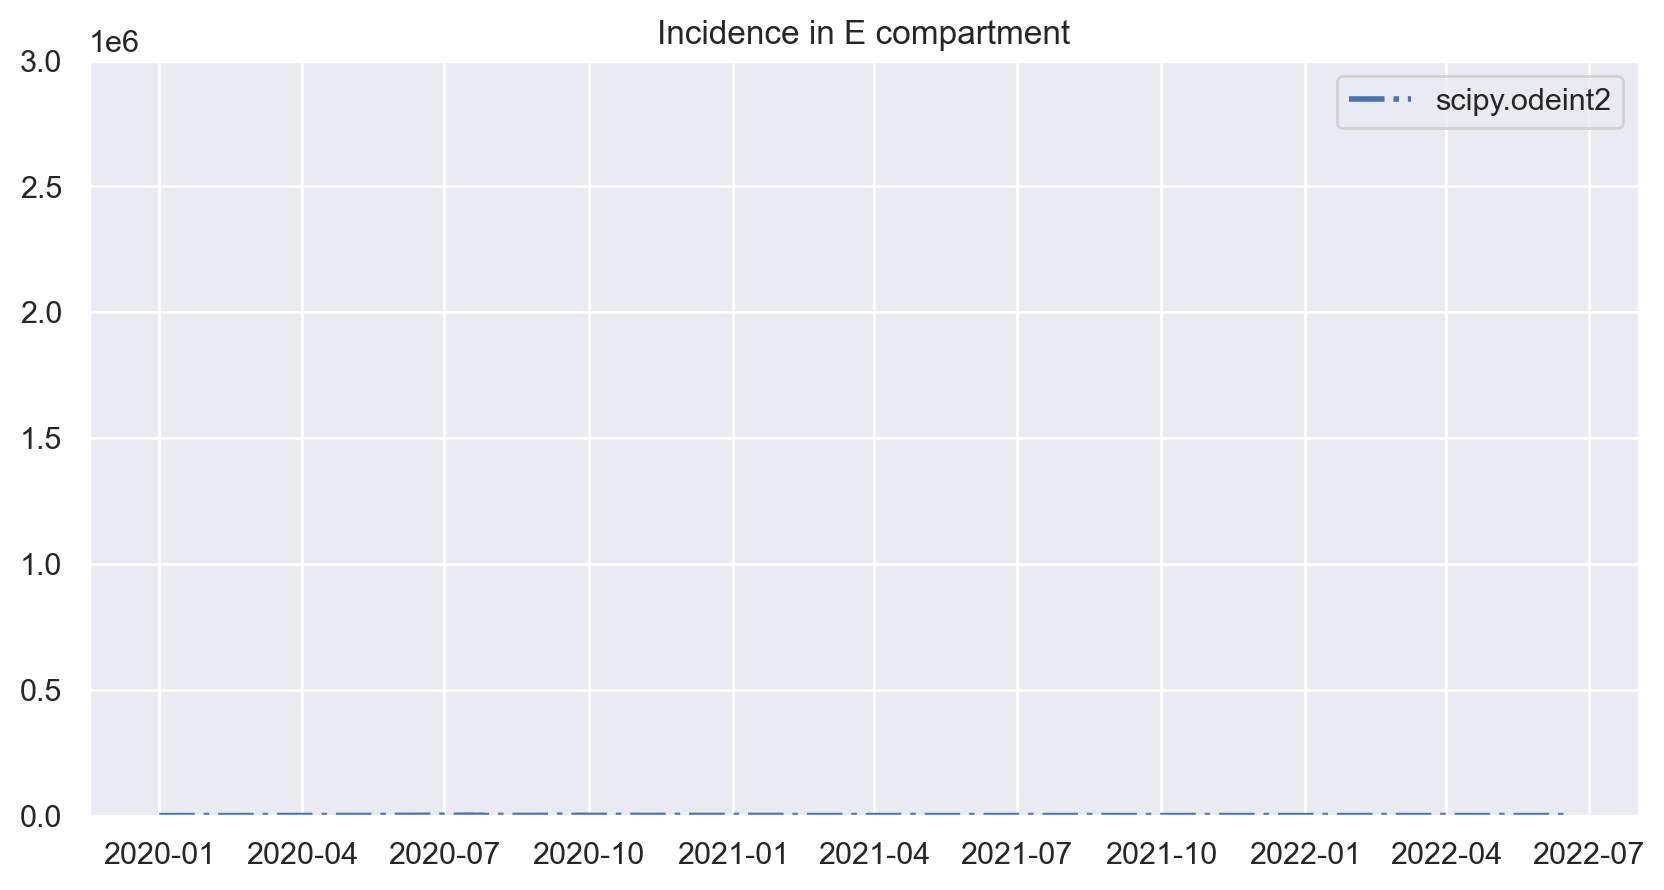

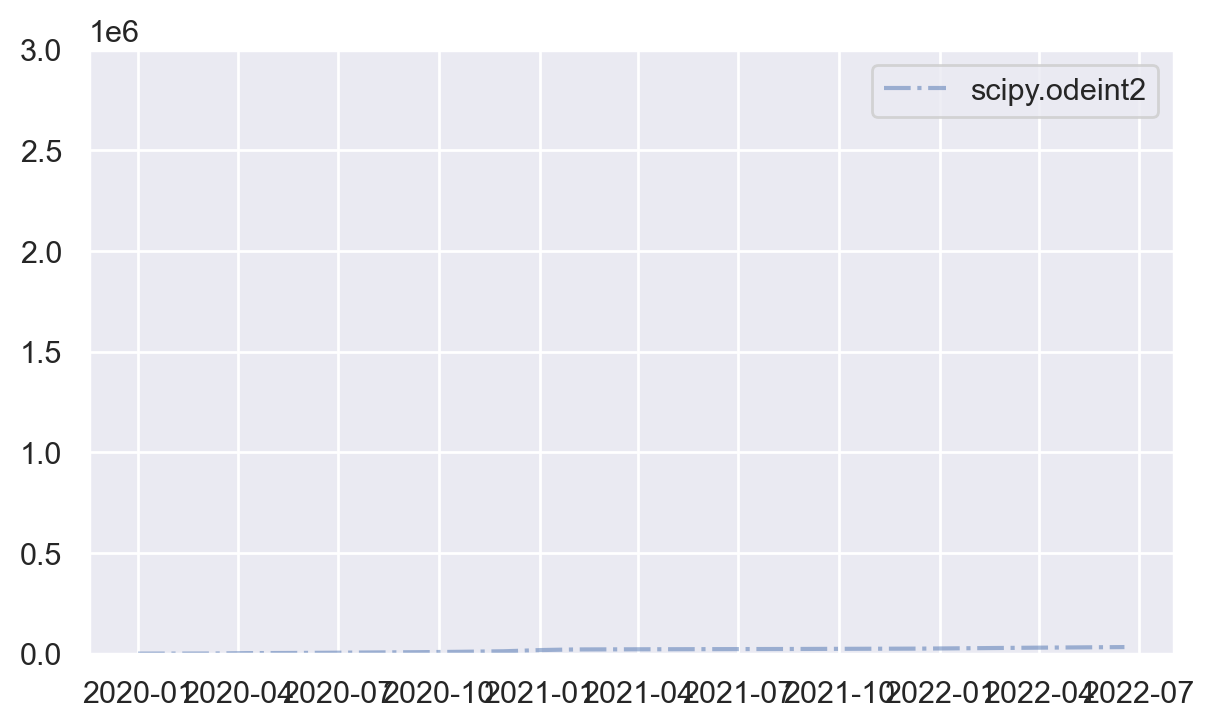

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=200)
lw = 2#0
for met, dat in data.items():
    if 'alpha' not in met:
        df = dat[(dat['value_type'] == 'incidence') & (dat['mc_infection_stage'] == 'E')]
        df = df.reset_index(drop=True).groupby(by='date').sum().sum(axis=1)
        ax.plot(df, label = met, ls = '-.', alpha = 1, lw=lw)
    #lw -=2
ax.legend()
ax.set_title('Incidence in E compartment')
ax.set_ylim(0,3e6)

fig, ax = plt.subplots(1,1, figsize=(7,4), dpi=200)

for met, dat in data.items():
    df = dat[(dat['value_type'] == 'prevalence') & (dat['mc_infection_stage'] == 'I1')]
    df = df.reset_index(drop=True).groupby(by='date').sum().sum(axis=1)
    ax.plot(df, label = met, ls = '-.', alpha = .5)
ax.legend()
ax.set_ylim(0,3e6)

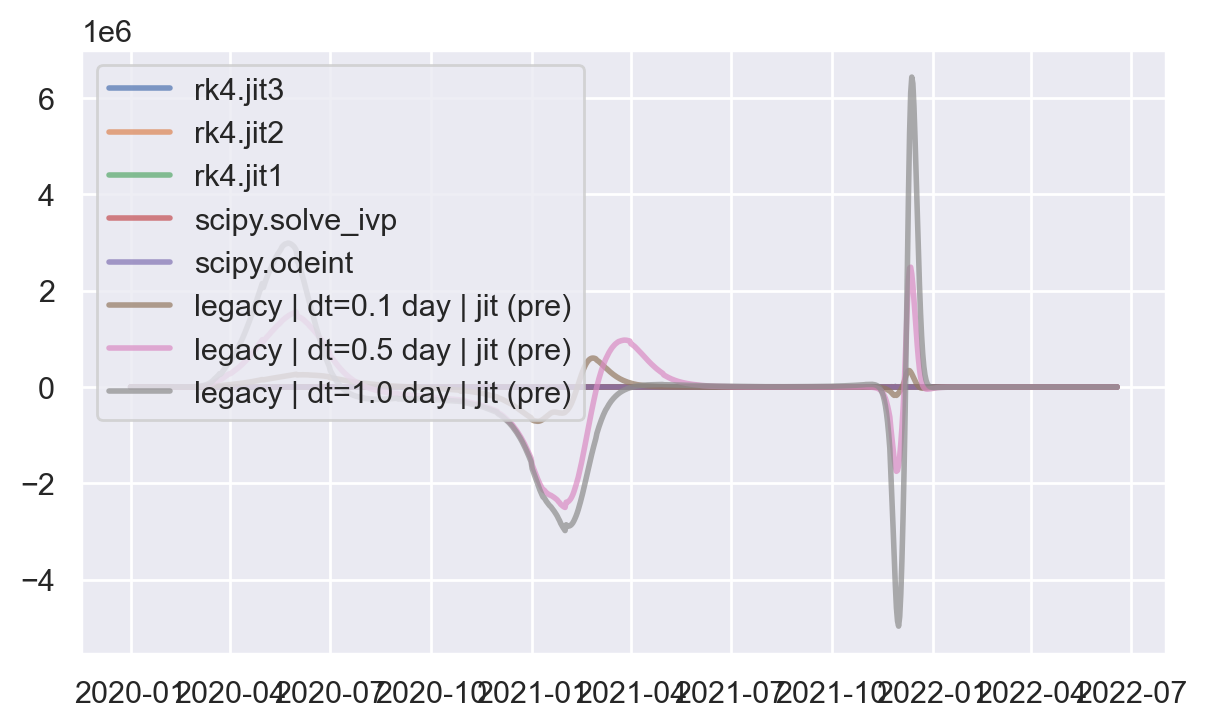

In [23]:
fig, ax = plt.subplots(1,1, figsize=(7,4), dpi=200)
lw = 2#0
dat = data['scipy.solve_ivp']
df = dat[(dat['value_type'] == 'incidence') & (dat['mc_infection_stage'] == 'E')]
ref = df.reset_index(drop=True).groupby(by='date').sum().sum(axis=1)
for met, dat in data.items():
    df = dat[(dat['value_type'] == 'incidence') & (dat['mc_infection_stage'] == 'E')]
    df = df.reset_index(drop=True).groupby(by='date').sum().sum(axis=1) 
    df = df - ref#).abs()
    ax.plot(df, label = met, ls = '-', alpha = .7, lw=lw)
    #lw -=2
ax.legend()

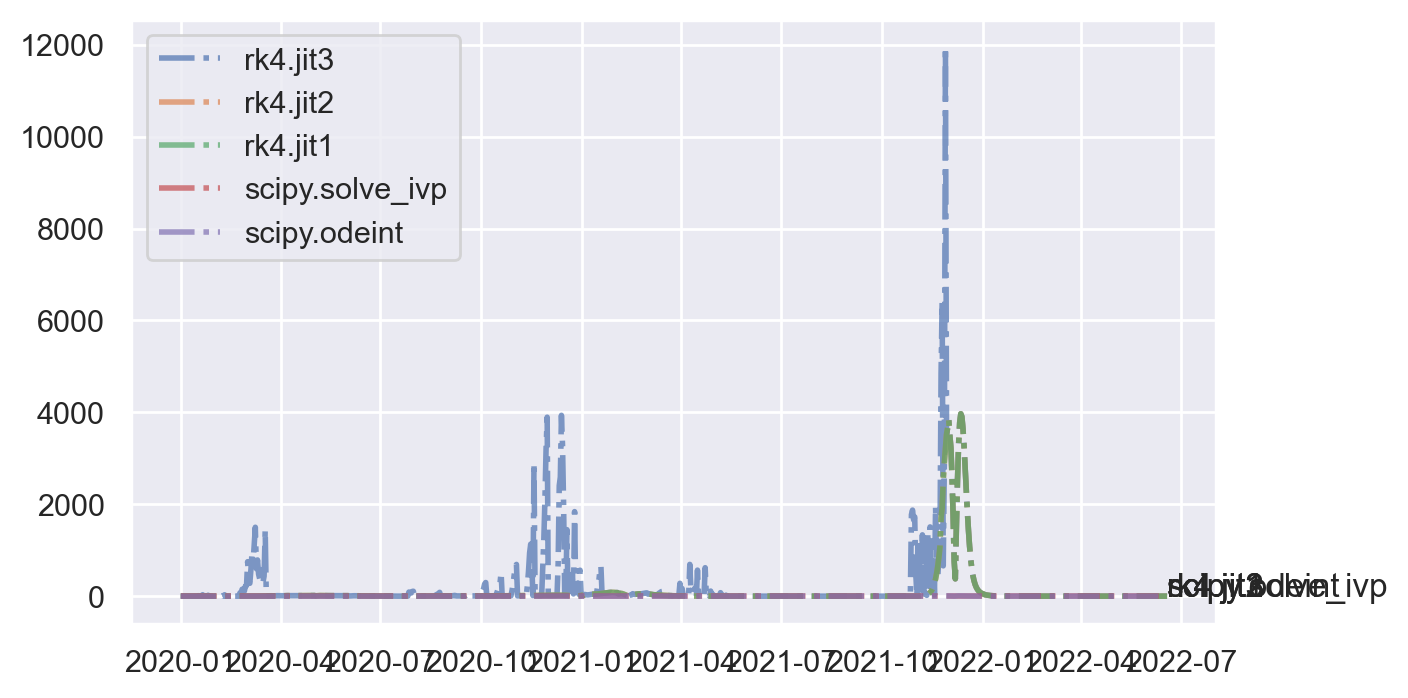

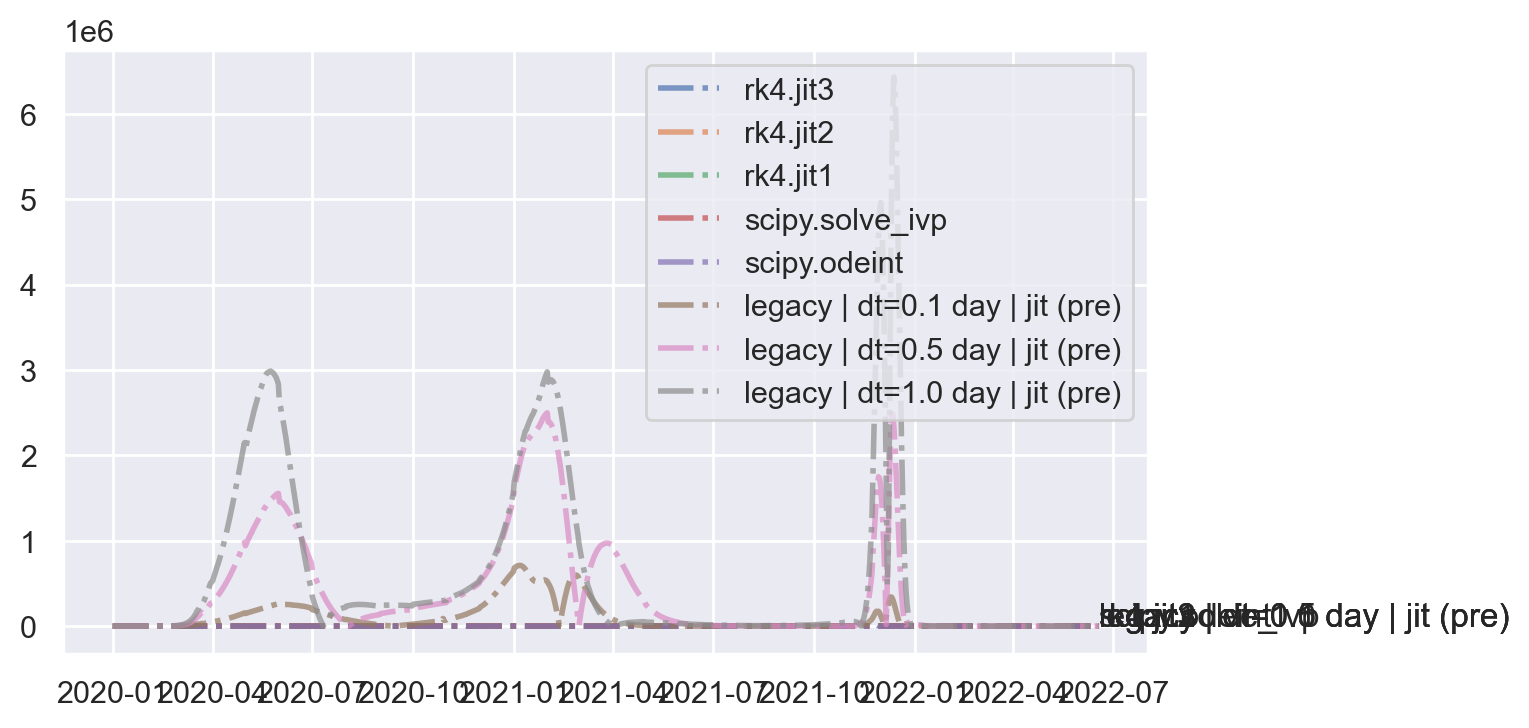

In [43]:
fig, ax = plt.subplots(1,1, figsize=(7,4), dpi=200)
lw = 2#0
dat = data['scipy.solve_ivp']
df = dat[(dat['value_type'] == 'incidence') & (dat['mc_infection_stage'] == 'E')]
ref = df.reset_index(drop=True).groupby(by='date').sum().sum(axis=1)
for met, dat in data.items():
    if 'legacy' not in met:
        df = dat[(dat['value_type'] == 'incidence') & (dat['mc_infection_stage'] == 'E')]
        df = df.reset_index(drop=True).groupby(by='date').sum().sum(axis=1)
        df = (df - ref).abs()#.cumsum()
        ax.plot(df, label = met, ls = '-.', alpha = .7, lw=lw)
        plt.text(df.index[-1], df[-1], f'{met}')
    #lw -=2
ax.legend()

fig, ax = plt.subplots(1,1, figsize=(7,4), dpi=200)
lw = 2#0
dat = data['scipy.solve_ivp']
df = dat[(dat['value_type'] == 'incidence') & (dat['mc_infection_stage'] == 'E')]
ref = df.reset_index(drop=True).groupby(by='date').sum().sum(axis=1)
for met, dat in data.items():
        df = dat[(dat['value_type'] == 'incidence') & (dat['mc_infection_stage'] == 'E')]
        df = df.reset_index(drop=True).groupby(by='date').sum().sum(axis=1)
        df = (df - ref).abs()#.cumsum()
        ax.plot(df, label = met, ls = '-.', alpha = .7, lw=lw)
        plt.text(df.index[-1], df[-1], f'{met}')
    #lw -=2
ax.legend()